In [1]:
import pandas as pd
import seaborn as sbn
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

from time import time
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, ConstantKernel
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from matplotlib.colors import ListedColormap
import matplotlib.pylab as pylab
from sklearn.model_selection import train_test_split
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
import random

In [2]:
def strat_group_tt_split(X, y, groups, p_per_class=1, rnd_state=1):
  # Split observations with stratification at the "group" level.
  # This is to be used when we want to predict the subject's class from individual 
  # observations, in case we have multiple observations per subject.
  # In this example, "group" refer to the subject ID (it is a "group" of observations)
  # and "class" refers to the subject's experimental group.
  # This type of split is needed to avoid training and testing on different observations
  # from each subject, which would bias the classifier to recognize the subject himself
  # instead of his experimental group.
  
  
  #### NON-EXHAUSTIF  
  #### FOR UNSTRATIFIED ----> use sklearn.model_selection.GroupShuffleSplit
  
    groups_by_class = []
    groups_lab, groups_lab_idx = np.unique(groups, return_index=True)
    classes_lab = np.unique(y)
    print('GROUPS_BY_CLASS', groups_lab_idx)
    random.seed(rnd_state)
  
  #stocker les index (sur groups_lab) des participants appartenant à chaque classe
    for class_toclassif in classes_lab:
        groups_by_class.append([i for i in range(len(groups_lab)) if y[groups_lab_idx[i]] == class_toclassif])

  #choisir au hasard un ptcp dans chaque classe
    group_to_keep = []
    for class_name, class_content in enumerate(groups_by_class):
        tokeep_idx = random.sample(class_content, p_per_class)
        group_to_keep.append(groups_lab[tokeep_idx])
    
  #créer test_set à partir des participants choisis
    X_test = X[[i for i in range(len(X)) if groups[i] in np.asarray(group_to_keep).flatten()]]
    y_test = y[[i for i in range(len(y)) if groups[i] in np.asarray(group_to_keep).flatten()]]
    groups_test = groups[[i for i in range(len(groups)) if groups[i] in np.asarray(group_to_keep).flatten()]]
  
  #créer train_set
    X_train = X[[i for i in range(len(X)) if not groups[i] in np.asarray(group_to_keep).flatten()]]
    y_train = y[[i for i in range(len(y)) if not groups[i] in np.asarray(group_to_keep).flatten()]]
    groups_train = groups[[i for i in range(len(groups)) if not groups[i] in np.asarray(group_to_keep).flatten()]]
  
  #print(classes_lab)
    return X_train, y_train, groups_train, X_test, y_test, groups_test


def creationMesh(X):
    """
    Crée un grille sur un espace bidimensionnel. Prends le min et le max de chaque dimension et calcule la grille avec une résolution de 0.02. 
    X: un vecteur à deux colonnes de données. 
    """
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx,yy

def AccScores(clf,data, groups=None, rdn=1):
  
    X, y = data
    X = StandardScaler().fit_transform(X)
    # Séparation des données en TRAIN - TEST
    if groups == None:
        print(rdn)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rdn)
    if groups is not None:
        X_train, y_train, groups_train, X_test, y_test, groups_test = strat_group_tt_split(X, y, groups, p_per_class=5, rnd_state=rng_seed_p)
    
    # entrainement du classificateur et calcul du score final (accuracy)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    
    return score
  
def plotClassifierOnData(name,clf,data,i=3,n=1,multi=False, groups=None, rdn=55):
    """
    Pour Afficher les récultat d'un classificateur sur un dataset
    name : le titre du graphique
    clf : le classificateur à utiliser
    data : les données à utiliser
    i : Le ième graphique sur n à afficher (pour afficher 3 graphiques par ligne)
    n : Le nombre total de graphiques à afficher
    multi: détermine si on affiche juste la frontière de décision (true) ou 
           le score/proba de chaque point de l'espace car on ne peut afficher le score en multiclasse.
    """
   
    # Préparation rapide des données : 
    # normalisation des données 
    X, y = data
    X = StandardScaler().fit_transform(X)
    # Séparation des données en TRAIN - TEST
    if groups == None:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rdn)
    if groups is not None:
        X_train, y_train, groups_train, X_test, y_test, groups_test = strat_group_tt_split(X, y, groups, p_per_class=5, rnd_state=rng_seed_p)
    
   # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.10, random_state=rng_seed)
    # Pour la visualisation des régions et calcul des bornes 
    xx,yy = creationMesh(X)

    # creation du bon nombre de figures à afficher (3 par lignes)
    ax = plt.subplot(n/3,3,i)
    
    # entrainement du classificateur et calcul du score final (accuracy)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    
    # Pour afficher les frontières de décision on va choisir une color pour 
    # chacun des points x,y du mesh [x_min, x_max]x[y_min, y_max].

    # Si on est en multiclasse (2 ou +) on affiche juste les frontières
    if multi:
         Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    else:# sinon on peut afficher le gradient du score
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # On affiche le mesh de décision
    Z = Z.reshape(xx.shape)
    test = ax.contourf(xx, yy, Z, 100, cmap=cm, alpha=.8)

    #On affiche la légende
    cbar = plt.colorbar(test)
    cbar.ax.set_title('score')
    
    # On affiche les points d'entrainement
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_points,
               edgecolors='k',s=100)
    # Et les points de test
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_points, 
               edgecolors='k',marker='X',s=100)

    # on définit les limites des axes et autres gogosses
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    
    ax.set_title(name,fontsize=22)
    # dont le score en bas à droite
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
            size=15, horizontalalignment='right')

    return X_train, y_train, X_test, y_test, score

# On définit une fonction pour adfficher la projection
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y2[i]),
                 color=plt.cm.Set1((y2[i]+1) / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [99]:
OneVsRestClassifier(clf)

OneVsRestClassifier(estimator=GradientBoostingClassifier(learning_rate=0.5,
                                                         max_depth=2,
                                                         n_estimators=15,
                                                         random_state=1,
                                                         subsample=1))

In [77]:
################################CLASSIFICATORS#########################################################
from sklearn.utils import resample

##DIMENSIONALITY REDUCTION TO PREDICT QUESTIONNAIRE GROUPS

rng_seed = 1
kernel = 1.0 * RBF(1.0)

data = pd.read_csv('df_ALL_metadata_MEG_sub00to11_epo_RT_before.csv')
TO_PREDICT = 'parei'
c1 = 'theta'
c2 = 'alpha'



df_ = data.loc[data['participant'] == 4]

df_list = []
elec_min = np.min(df_['electrodes'].unique())
elec_max = np.max(df_['electrodes'].unique())+1
for elec in range(elec_min, elec_max):
    df_ml = df_.loc[df_['electrodes'] == elec]


    df_ml = df_ml[[TO_PREDICT, c1, c2, 'participant']]

    X2 = df_ml.drop(TO_PREDICT, axis=1).values
    y2 = df_ml[TO_PREDICT].values

    #X=X.values
    #y=y.values
    n_samples, n_features = X2.shape
    #n_neighbors = 15

    R_frame = df_ml.copy()


    #Balance classes
    parei = R_frame.loc[R_frame[TO_PREDICT] == 1]
    NOparei = R_frame.loc[R_frame[TO_PREDICT] == 0]

    
    parei = resample(parei,
                 replace=True,
                 n_samples=len(NOparei),
                 random_state=42)
    print('N observations : ', len(parei))
    R_frame = pd.concat([parei, NOparei])
    ##Keep only specific FDs
    #R_frame = R_frame[(R_frame.loc[:, 'FD'] == 1.3) | (R_frame.loc[:, 'FD'] > 1.6)]
    #R_frame = R_frame[R_frame['FD'] > 1.5]
    R_frame.index = pd.RangeIndex(len(R_frame.index))

    #Keep relevant variables
    R_frame = R_frame.loc[:, [c1, c2, TO_PREDICT, 'participant']]

    groups = R_frame.loc[:, 'participant'].values

    #R_frame = R_frame.drop('participant', axis=1)

    f1 = c1
    f2 = c2
    f3=c3

    # Création du dataset 
    X = R_frame[[c1, c2]].values

    ## Encodage des espèces en valeurs numériques pour la coloration
    le = LabelEncoder()
    le.fit(R_frame.parei.unique())
    y = le.transform(R_frame.parei)
    R_frame = [X,y]

    #  ----------------------
    # Affichage des frontières de décision pour nos neuf classificateurs 
    f = plt.figure(figsize= (20,20))
    R_frame[1]

    clfs = [
        KNeighborsClassifier(n_neighbors=3, weights='uniform', leaf_size=30),
        LogisticRegression(random_state=rng_seed,max_iter=1000,penalty='l2',C=0.01,solver='liblinear'),
        SVC(kernel='rbf', C=1,gamma=.2,max_iter=1000),
        DecisionTreeClassifier(max_depth=30, random_state=rng_seed),
        RandomForestClassifier(max_depth=None, n_estimators=15, max_features=2, random_state=rng_seed),
        AdaBoostClassifier(n_estimators=15, learning_rate=0.5,random_state=rng_seed),
        MLPClassifier(hidden_layer_sizes=(5,), activation='relu', alpha=0.01, max_iter=10000, random_state=rng_seed),
        GaussianProcessClassifier(kernel=kernel),
        GradientBoostingClassifier(n_estimators=15, learning_rate=0.5, subsample=1, max_depth=2, random_state=rng_seed),
    ]
    # Liste des noms associés
    clf_names = [
        'k-NN','Régression Logistique',
        'SVM',
        'Arbre de décision','Forêt aléatoire','AdaBoost',
        'Perceptron','Processus Gaussien','Gradient Boosting'   ]
    ##Calculate the mean Accuracy scores on 9 classifiers for a definite set of Random Seeds

    Acc_scores = []
    Score_multiclass = []

    for cnt, clf in enumerate(clfs):
        print(clf)
        for seed in range(5):
            rng_seed_p = seed
            score = AccScores(OneVsRestClassifier(clf), R_frame, groups=None, rdn=seed)
            print(score)
            Acc_scores.append(score)

            scores = pd.DataFrame(Acc_scores)
            scores = scores.mean()
        Score_multiclass.append(scores)

    Score_multiclass = pd.DataFrame(Score_multiclass).T
    Score_multiclass['electrodes'] = elec
    Score_multiclass['participant'] = participant
    df_list.append(Score_multiclass)
    
df_Acc = pd.concat(df_list)
'''for clf in enumerate(clf_names):
  
    Score_multiclass.loc[:, clf[1]] = Score_multiclass[clf[0]]
Score_multiclass = Score_multiclass.iloc[:, 9:19]'''

'''##PLOT 9 CLASSIFIERS WITH ONLY ONE RANDOM SEED

for cnt, clf in enumerate(clfs):
    X_train, y_train, X_test, y_test, score = plotClassifierOnData(clf_names[cnt],
                                                                   OneVsRestClassifier(clf),
                                                                   R_frame,cnt+1,len(clfs),True, groups=None)
    Acc_scores.append(score) 
plt.tight_layout()
plt.show()'''

N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7682926829268293
1
0.5975609756097561
2
0.7073170731707317
3
0.7195121951219512
4
0.6341463414634146
LogisticRegression(C=0.01, max_iter=1000, random_state=1, solver='liblinear')
0
0.4634146341463415
1
0.45121951219512196
2
0.4878048780487805
3
0.43902439024390244
4
0.45121951219512196
SVC(C=1, gamma=0.2, max_iter=1000)
0
0.4268292682926829
1
0.43902439024390244
2
0.43902439024390244
3
0.4268292682926829
4
0.47560975609756095
DecisionTreeClassifier(max_depth=30, random_state=1)
0
0.7804878048780488
1
0.7926829268292683
2
0.7195121951219512
3
0.8048780487804879
4
0.6585365853658537
RandomForestClassifier(max_features=2, n_estimators=15, random_state=1)
0
0.7560975609756098
1
0.7317073170731707
2
0.7560975609756098
3
0.7804878048780488
4
0.7195121951219512
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5853658536585366
1
0.524390243902439
2
0.6097560975609756
3
0.6341463414634146
4
0.5
MLPClassifier

0.7439024390243902
3
0.7195121951219512
4
0.7804878048780488
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6097560975609756
1
0.5365853658536586
2
0.5487804878048781
3
0.5853658536585366
4
0.5609756097560976
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5853658536585366
1
0.6097560975609756
2
0.5
3
0.4634146341463415
4
0.5487804878048781
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8658536585365854
2
0.8902439024390244
3
0.8902439024390244
4
0.8048780487804879
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6585365853658537
1
0.6829268292682927
2
0.524390243902439
3
0.7073170731707317
4
0.6219512195121951
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7317073170731707
1
0.7073170731707317
2
0.6951219512195121
3
0.7439024390243902
4
0.6951219512195121
LogisticReg

0.6097560975609756
1
0.5975609756097561
2
0.5853658536585366
3
0.5975609756097561
4
0.6097560975609756
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8658536585365854
1
0.8780487804878049
2
0.7317073170731707
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7560975609756098
1
0.6097560975609756
2
0.6097560975609756
3
0.7926829268292683
4
0.7195121951219512
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7073170731707317
1
0.7439024390243902
2
0.7317073170731707
3
0.6707317073170732
4
0.6707317073170732
LogisticRegression(C=0.01, max_iter=1000, random_state=1, solver='liblinear')
0
0.4878048780487805
1
0.5975609756097561
2
0.5365853658536586
3
0.5487804878048781
4
0.5853658536585366
SVC(C=1, gamma=0.2, max_iter=1000)
0
0.5365853658536586
1
0.5853658536585366
2
0.5487804878048781
3
0.6097560975609756
4
0.6829268292682927
DecisionT

0.8048780487804879
4
0.8780487804878049
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7073170731707317
1
0.7195121951219512
2
0.6219512195121951
3
0.5609756097560976
4
0.6463414634146342
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6707317073170732
1
0.573170731707317
2
0.6097560975609756
3
0.6951219512195121
4
0.6219512195121951
LogisticRegression(C=0.01, max_iter=1000, random_state=1, solver='liblinear')
0
0.5853658536585366
1
0.5365853658536586
2
0.4634146341463415
3
0.45121951219512196
4
0.4878048780487805
SVC(C=1, gamma=0.2, max_iter=1000)
0
0.47560975609756095
1
0.5365853658536586
2
0.47560975609756095
3
0.5
4
0.6463414634146342
DecisionTreeClassifier(max_depth=30, random_state=1)
0
0.8048780487804879
1
0.7926829268292683
2
0.8658536585365854
3
0.7804878048780488
4
0.7073170731707317
RandomForestClassifier(max_features=2, n_estimators=15, random_state=1)
0
0.7682926829268293

C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpc.py:426: RuntimeWarning: overflow encountered in exp
  - np.log1p(np.exp(-(self.y_train_ * 2 - 1) * f)).sum() \


0.7317073170731707
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6585365853658537
1
0.6829268292682927
2
0.7073170731707317
3
0.6951219512195121
4
0.7195121951219512
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6341463414634146
1
0.573170731707317
2
0.6097560975609756
3
0.7195121951219512
4
0.6219512195121951
LogisticRegression(C=0.01, max_iter=1000, random_state=1, solver='liblinear')
0
0.6463414634146342
1
0.5365853658536586
2
0.5
3
0.6463414634146342
4
0.524390243902439
SVC(C=1, gamma=0.2, max_iter=1000)
0
0.6585365853658537
1
0.6097560975609756
2
0.5609756097560976
3
0.6341463414634146
4
0.5975609756097561
DecisionTreeClassifier(max_depth=30, random_state=1)
0
0.7195121951219512
1
0.7195121951219512
2
0.8048780487804879
3
0.8292682926829268
4
0.8414634146341463
RandomForestClassifier(max_features=2, n_estimators=15, random_state=1)
0
0.7195121951219512
1
0.7439024390243902
2
0

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8536585365853658
4
0.7682926829268293
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6341463414634146
1
0.5609756097560976
2
0.6463414634146342
3
0.6707317073170732
4
0.6585365853658537
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.6463414634146342
1
0.6341463414634146
2
0.573170731707317
3
0.6707317073170732
4
0.6707317073170732
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.6463414634146342
1
0.8780487804878049
2
0.573170731707317
3
0.6463414634146342
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6951219512195121
1
0.6341463414634146
2
0.6341463414634146
3
0.7317073170731707
4
0.6951219512195121
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6585365853658537
1
0.6463414634146342
2
0.5853658536585366
3
0.6951219512195121
4
0.6585365853658537
LogisticRegress

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7682926829268293
3
0.7682926829268293
4
0.7317073170731707
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6341463414634146
1
0.6097560975609756
2
0.5975609756097561
3
0.6341463414634146
4
0.5487804878048781
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.6219512195121951
1
0.5609756097560976
2
0.5
3
0.5975609756097561
4
0.573170731707317
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.4634146341463415
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7926829268292683
1
0.6585365853658537
2
0.6463414634146342
3
0.7073170731707317
4
0.6463414634146342
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7317073170731707
1
0.6829268292682927
2
0.6585365853658537
3
0.6463414634146342
4
0.6829268292682927
LogisticR

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.7439024390243902
4
0.7560975609756098
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.573170731707317
1
0.6097560975609756
2
0.5853658536585366
3
0.6585365853658537
4
0.6219512195121951
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.6341463414634146
1
0.5609756097560976
2
0.5487804878048781
3
0.6463414634146342
4
0.6097560975609756
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.5365853658536586
3
0.926829268292683
4
0.5975609756097561
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6951219512195121
1
0.6219512195121951
2
0.5975609756097561
3
0.6585365853658537
4
0.6707317073170732
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7195121951219512
1
0.7317073170731707
2
0.5853658536585366
3
0.7073170731707317
4
0.7195121951219512
LogisticRegress

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


3
0.8048780487804879
4
0.8048780487804879
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6341463414634146
1
0.6341463414634146
2
0.5
3
0.573170731707317
4
0.6341463414634146
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.6097560975609756
1
0.5487804878048781
2
0.4634146341463415
3
0.6463414634146342
4
0.6097560975609756
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.5975609756097561
1
0.5609756097560976
2
0.5
3
0.8292682926829268
4
0.6341463414634146
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7317073170731707
1
0.6341463414634146
2
0.5487804878048781
3
0.6585365853658537
4
0.5975609756097561
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7439024390243902
1
0.5853658536585366
2
0.6341463414634146
3
0.6829268292682927
4
0.6341463414634146
LogisticRegression(C=0.01, max_iter=1000, ran

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7682926829268293
3
0.7560975609756098
4
0.7073170731707317
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5365853658536586
1
0.6463414634146342
2
0.5
3
0.5609756097560976
4
0.524390243902439
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5121951219512195
1
0.5121951219512195
2
0.5853658536585366
3
0.5121951219512195
4
0.47560975609756095
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7073170731707317
1
0.7073170731707317
2
0.6463414634146342
3
0.7073170731707317
4
0.6097560975609756
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6829268292682927
1
0.5853658536585366
2
0.6341463414634146
3
0.7317073170731707
4
0.7195121951219512
Logistic

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7682926829268293
3
0.7682926829268293
4
0.8292682926829268
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.524390243902439
1
0.5609756097560976
2
0.5487804878048781
3
0.5975609756097561
4
0.5853658536585366
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5121951219512195
1
0.5975609756097561
2
0.5121951219512195
3
0.5487804878048781
4
0.573170731707317
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8292682926829268
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6585365853658537
1
0.6341463414634146
2
0.6829268292682927
3
0.7073170731707317
4
0.6219512195121951
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6707317073170732
1
0.6341463414634146
2
0.6341463414634146
3
0.6707317073170732
4
0.670731707317

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7560975609756098
3
0.6951219512195121
4
0.7439024390243902
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5
1
0.5853658536585366
2
0.5975609756097561
3
0.6219512195121951
4
0.573170731707317
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5
1
0.5365853658536586
2
0.5
3
0.5
4
0.573170731707317
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.573170731707317
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7073170731707317
1
0.6463414634146342
2
0.6585365853658537
3
0.6341463414634146
4
0.6463414634146342
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6097560975609756
1
0.6097560975609756
2
0.6341463414634146
3
0.6585365853658537
4
0.6707317073170732
LogisticRegression(C=0.01, max_iter=1000, random_state=

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8292682926829268
4
0.7560975609756098
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.4878048780487805
1
0.5609756097560976
2
0.524390243902439
3
0.5487804878048781
4
0.5487804878048781
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5
1
0.5121951219512195
2
0.4634146341463415
3
0.524390243902439
4
0.524390243902439
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8292682926829268
2
0.8536585365853658
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.5853658536585366
1
0.5609756097560976
2
0.573170731707317
3
0.7439024390243902
4
0.6097560975609756
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6707317073170732
1
0.6097560975609756
2
0.5487804878048781
3
0.6219512195121951
4
0.524390243902439
LogisticRegression(C=0.01, max_ite

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7317073170731707
3
0.8048780487804879
4
0.7073170731707317
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5
1
0.5609756097560976
2
0.4268292682926829
3
0.5609756097560976
4
0.5365853658536586
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.4634146341463415
1
0.43902439024390244
2
0.5853658536585366
3
0.5487804878048781
4
0.5365853658536586
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6707317073170732
1
0.6341463414634146
2
0.4878048780487805
3
0.6585365853658537
4
0.5853658536585366
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6463414634146342
1
0.6707317073170732
2
0.6219512195121951
3
0.6219512195121951
4
0.6341463414634146
Logisti

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.6951219512195121
3
0.8658536585365854
4
0.7439024390243902
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5487804878048781
1
0.5975609756097561
2
0.5853658536585366
3
0.573170731707317
4
0.5365853658536586
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.47560975609756095
1
0.5
2
0.524390243902439
3
0.5609756097560976
4
0.5487804878048781
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.7439024390243902
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6951219512195121
1
0.7439024390243902
2
0.7073170731707317
3
0.6585365853658537
4
0.6097560975609756
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7073170731707317
1
0.5853658536585366
2
0.5609756097560976
3
0.6829268292682927
4
0.6341463414634146
LogisticR

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7439024390243902
3
0.7926829268292683
4
0.7439024390243902
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5365853658536586
1
0.6341463414634146
2
0.5
3
0.5975609756097561
4
0.5
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.47560975609756095
1
0.4878048780487805
2
0.34146341463414637
3
0.4878048780487805
4
0.524390243902439
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8414634146341463
1
0.8658536585365854
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6341463414634146
1
0.6463414634146342
2
0.6219512195121951
3
0.7073170731707317
4
0.6341463414634146
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6951219512195121
1
0.6707317073170732
2
0.6585365853658537
3
0.7073170731707317
4
0.7073170731707317
LogisticRegression(C=0

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.7682926829268293
4
0.7560975609756098
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6829268292682927
1
0.4878048780487805
2
0.5853658536585366
3
0.6341463414634146
4
0.5487804878048781
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5
1
0.5365853658536586
2
0.4634146341463415
3
0.6097560975609756
4
0.5487804878048781
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8658536585365854
3
0.9390243902439024
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6951219512195121
1
0.6585365853658537
2
0.6463414634146342
3
0.7073170731707317
4
0.7195121951219512
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6463414634146342
1
0.5975609756097561
2
0.6829268292682927
3
0.6341463414634146
4
0.6341463414634146
LogisticRegression(C=0.01, m

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


3
0.7317073170731707
4
0.7682926829268293
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5
1
0.524390243902439
2
0.5487804878048781
3
0.5121951219512195
4
0.524390243902439
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.4878048780487805
1
0.5487804878048781
2
0.45121951219512196
3
0.4634146341463415
4
0.5121951219512195
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8170731707317073
1
0.8780487804878049
2
0.8902439024390244
3
0.7926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.573170731707317
1
0.6341463414634146
2
0.6951219512195121
3
0.6219512195121951
4
0.6097560975609756
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6951219512195121
1
0.5365853658536586
2
0.5975609756097561
3
0.6951219512195121
4
0.6219512195121951
LogisticRegression(C=0.01, max_

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7926829268292683
3
0.9024390243902439
4
0.7804878048780488
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.573170731707317
1
0.573170731707317
2
0.6097560975609756
3
0.6219512195121951
4
0.6097560975609756
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.4634146341463415
1
0.4146341463414634
2
0.5121951219512195
3
0.524390243902439
4
0.524390243902439
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.45121951219512196
1
0.7682926829268293
2
0.8414634146341463
3
0.45121951219512196
4
0.5
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6341463414634146
1
0.5853658536585366
2
0.6219512195121951
3
0.6951219512195121
4
0.6585365853658537
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6585365853658537
1
0.6097560975609756
2
0.7682926829268293
3
0.7073170731707317
4
0.6341463414634146
LogisticR

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



1
0.6585365853658537
2
0.8048780487804879
3
0.8048780487804879
4
0.7682926829268293
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.573170731707317
1
0.5975609756097561
2
0.6829268292682927
3
0.6951219512195121
4
0.6097560975609756
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5365853658536586
1
0.4268292682926829
2
0.3902439024390244
3
0.5121951219512195
4
0.5609756097560976
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6829268292682927
1
0.6829268292682927
2
0.6585365853658537
3
0.7439024390243902
4
0.6707317073170732
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6707317073170732
1
0.6341463414634146
2
0.6341463414634146
3
0.69512195121

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



0.7682926829268293
3
0.8292682926829268
4
0.8170731707317073
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6097560975609756
1
0.5365853658536586
2
0.5853658536585366
3
0.5975609756097561
4
0.573170731707317
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.4146341463414634
1
0.4634146341463415
2
0.4024390243902439
3
0.4878048780487805
4
0.573170731707317
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.7682926829268293
1
0.8780487804878049
2
0.7560975609756098
3
0.8048780487804879
4
0.7926829268292683
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7073170731707317
1
0.6951219512195121
2
0.6585365853658537
3
0.7317073170731707
4
0.6341463414634146
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6707317073170732
1
0.6341463414634146
2
0.6951219512195121
3
0.7073170731707317
4
0.6829268292682

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7560975609756098
3
0.8048780487804879
4
0.7926829268292683
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5487804878048781
1
0.573170731707317
2
0.573170731707317
3
0.573170731707317
4
0.5609756097560976
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5
1
0.5121951219512195
2
0.4634146341463415
3
0.5
4
0.5365853658536586
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.7804878048780488
1
0.7682926829268293
2
0.8536585365853658
3
0.9146341463414634
4


C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpc.py:426: RuntimeWarning: overflow encountered in exp
  - np.log1p(np.exp(-(self.y_train_ * 2 - 1) * f)).sum() \


0.8536585365853658
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7195121951219512
1
0.6097560975609756
2
0.5853658536585366
3
0.6585365853658537
4
0.5609756097560976
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6707317073170732
1
0.6463414634146342
2
0.6951219512195121
3
0.5975609756097561
4
0.6219512195121951
LogisticRegression(C=0.01, max_iter=1000, random_state=1, solver='liblinear')
0
0.5
1
0.47560975609756095
2
0.43902439024390244
3
0.43902439024390244
4
0.5365853658536586
SVC(C=1, gamma=0.2, max_iter=1000)
0
0.4878048780487805
1
0.4878048780487805
2
0.573170731707317
3
0.573170731707317
4
0.5365853658536586
DecisionTreeClassifier(max_depth=30, random_state=1)
0
0.8170731707317073
1
0.7560975609756098
2
0.7560975609756098
3
0.8658536585365854
4
0.7804878048780488
RandomForestClassifier(max_features=2, n_estimators=15, random_state=1)
0
0.7926829268292683
1
0.7073170731707317

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7682926829268293
3
0.7926829268292683
4
0.7926829268292683
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.573170731707317
1
0.524390243902439
2
0.5975609756097561
3
0.5609756097560976
4
0.573170731707317
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5975609756097561
1
0.4878048780487805
2
0.5121951219512195
3
0.6707317073170732
4
0.5853658536585366
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.8170731707317073
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.5853658536585366
1
0.5975609756097561
2
0.7195121951219512
3
0.7317073170731707
4
0.6219512195121951
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.5853658536585366
1
0.6097560975609756
2
0.6585365853658537
3
0.7317073170731707
4
0.658536585365

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



1
0.7195121951219512
2
0.7804878048780488
3
0.8170731707317073
4
0.8170731707317073
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5365853658536586
1
0.43902439024390244
2
0.4634146341463415
3
0.5975609756097561
4
0.573170731707317
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5121951219512195
1
0.4146341463414634
2
0.43902439024390244
3
0.4268292682926829
4
0.5121951219512195
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6341463414634146
1
0.6341463414634146
2
0.6341463414634146
3
0.6463414634146342
4
0.7439024390243902
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7682926829268293
1
0.6951219512195121
2
0.6341463414634146
3
0.743902439

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8536585365853658
4
0.7439024390243902
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5609756097560976
1
0.6585365853658537
2
0.5975609756097561
3
0.7073170731707317
4
0.524390243902439
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5609756097560976
1
0.4268292682926829
2
0.43902439024390244
3
0.524390243902439
4
0.573170731707317
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.8048780487804879
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6951219512195121
1
0.6707317073170732
2
0.6341463414634146
3
0.7195121951219512
4
0.6097560975609756
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6341463414634146
1
0.6341463414634146
2
0.5975609756097561
3
0.6341463414634146
4
0.6097560975609756
LogisticRegress

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7195121951219512
3
0.8170731707317073
4
0.7317073170731707
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5975609756097561
1
0.5487804878048781
2
0.6219512195121951
3
0.573170731707317
4
0.5121951219512195
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.524390243902439
1
0.5365853658536586
2
0.3902439024390244
3
0.5
4
0.5
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8658536585365854
1
0.8780487804878049
2
0.8902439024390244
3
0.8414634146341463
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6829268292682927
1
0.5609756097560976
2
0.5975609756097561
3
0.6341463414634146
4
0.6463414634146342
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6829268292682927
1
0.6341463414634146
2
0.6951219512195121
3
0.5975609756097561
4
0.6585365853658537
LogisticRegression(C=0.0

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7560975609756098
3
0.7682926829268293
4
0.7317073170731707
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.4634146341463415
1
0.5
2
0.5853658536585366
3
0.6463414634146342
4
0.5609756097560976
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5365853658536586
1
0.43902439024390244
2
0.4146341463414634
3
0.573170731707317
4
0.5365853658536586
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.45121951219512196
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.573170731707317
1
0.6219512195121951
2
0.6097560975609756
3
0.6585365853658537
4
0.6341463414634146
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6951219512195121
1
0.6951219512195121
2
0.6463414634146342
3
0.6585365853658537
4
0.6585365853658537
Logistic

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7682926829268293
3
0.8170731707317073
4
0.7560975609756098
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5975609756097561
1
0.4878048780487805
2
0.6097560975609756
3
0.573170731707317
4
0.5853658536585366
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.524390243902439
1
0.524390243902439
2
0.43902439024390244
3
0.573170731707317
4
0.5121951219512195
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.7317073170731707
2
0.8170731707317073
3
0.926829268292683
4
0.7926829268292683
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6707317073170732
1
0.6951219512195121
2
0.7317073170731707
3
0.6341463414634146
4
0.6341463414634146
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6951219512195121
1
0.7560975609756098
2
0.6341463414634146
3
0.7073170731707317
4
0.7560975609756

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


0.7560975609756098
3
0.7926829268292683
4
0.8048780487804879
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5
1
0.5487804878048781
2
0.5853658536585366
3
0.6463414634146342
4
0.5609756097560976
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5365853658536586
1
0.573170731707317
2
0.4024390243902439
3
0.5365853658536586
4
0.5975609756097561
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8658536585365854
1
0.8170731707317073
2
0.8902439024390244
3
0.926829268292683
4
0.7682926829268293
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6341463414634146
1
0.7439024390243902
2
0.6463414634146342
3
0.7682926829268293
4
0.6707317073170732
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6829268292682927
1
0.6585365853658537
2
0.6219512195121951
3
0.5975609756097561
4
0.6707317073170732
LogisticRegr

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7804878048780488
3
0.8048780487804879
4
0.7926829268292683
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5853658536585366
1
0.6097560975609756
2
0.6463414634146342
3
0.5853658536585366
4
0.6341463414634146
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.47560975609756095
1
0.4024390243902439
2
0.43902439024390244
3
0.4146341463414634
4
0.5487804878048781
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.7926829268292683
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6585365853658537
1
0.6585365853658537
2
0.6219512195121951
3
0.6951219512195121
4
0.6707317073170732
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6707317073170732
1
0.6585365853658537
2
0.7073170731707317
3
0.6463414634146342
4
0.53658536

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.7439024390243902
4
0.7560975609756098
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6219512195121951
1
0.5365853658536586
2
0.5365853658536586
3
0.524390243902439
4
0.5365853658536586
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.45121951219512196
1
0.3780487804878049
2
0.4268292682926829
3
0.4146341463414634
4
0.5
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.5
1
0.8780487804878049
2
0.8780487804878049
3
0.926829268292683
4
0.8902439024390244
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6341463414634146
1
0.6829268292682927
2
0.5121951219512195
3
0.6219512195121951
4
0.5609756097560976
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6219512195121951
1
0.6463414634146342
2
0.6829268292682927
3
0.7195121951219512
4
0.5975609756097561
LogisticRegression(C=0.01, max_iter=1000, ra

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.8170731707317073
3
0.8048780487804879
4
0.7560975609756098
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6707317073170732
1
0.5487804878048781
2
0.6219512195121951
3
0.6829268292682927
4
0.6097560975609756
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5
1
0.5609756097560976
2
0.5609756097560976
3
0.5487804878048781
4
0.5609756097560976
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.7682926829268293
1
0.8780487804878049
2
0.8780487804878049
3
0.8902439024390244
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6341463414634146
1
0.6707317073170732
2
0.7682926829268293
3
0.7073170731707317
4
0.6219512195121951
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.573170731707317
1
0.6097560975609756
2
0.6463414634146342
3
0.6341463414634146
4
0.7195121951219512
Logistic

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.7317073170731707
4
0.8414634146341463
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5609756097560976
1
0.6097560975609756
2
0.6341463414634146
3
0.5487804878048781
4
0.5975609756097561
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5121951219512195
1
0.5365853658536586
2
0.5365853658536586
3
0.573170731707317
4
0.6341463414634146
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8780487804878049
1
0.8658536585365854
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7439024390243902
1
0.7804878048780488
2
0.6829268292682927
3
0.6341463414634146
4
0.6707317073170732
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7317073170731707
1
0.6707317073170732
2
0.6585365853658537
3
0.7073170731707317
4
0.6951219512195121
LogisticRegress

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


0.6951219512195121
2
0.7682926829268293
3
0.7682926829268293
4
0.7317073170731707
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5121951219512195
1
0.5487804878048781
2
0.6341463414634146
3
0.524390243902439
4
0.5975609756097561
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5365853658536586
1
0.4878048780487805
2
0.5121951219512195
3
0.5853658536585366
4
0.5609756097560976
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8048780487804879
1
0.7560975609756098
2
0.8048780487804879
3
0.8170731707317073
4
0.7682926829268293
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.5975609756097561
1
0.6585365853658537
2
0.6463414634146342
3
0.5975609756097561
4
0.6219512195121951
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6707317073170732
1
0.5975609756097561
2
0.6097560975609756
3
0.6829268292682

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


3
0.7926829268292683
4
0.8048780487804879
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.3902439024390244
1
0.5365853658536586
2
0.5609756097560976
3
0.573170731707317
4
0.573170731707317
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.6097560975609756
1
0.5
2
0.4634146341463415
3
0.47560975609756095
4
0.4878048780487805
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.7682926829268293
1


C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpc.py:426: RuntimeWarning: overflow encountered in exp
  - np.log1p(np.exp(-(self.y_train_ * 2 - 1) * f)).sum() \


0.7195121951219512
2
0.7804878048780488
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.573170731707317
1
0.6097560975609756
2
0.6219512195121951
3
0.5975609756097561
4
0.5365853658536586
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6707317073170732
1
0.6219512195121951
2
0.6097560975609756
3
0.6463414634146342
4
0.5487804878048781
LogisticRegression(C=0.01, max_iter=1000, random_state=1, solver='liblinear')
0
0.45121951219512196
1
0.5121951219512195
2
0.5121951219512195
3
0.43902439024390244
4
0.4878048780487805
SVC(C=1, gamma=0.2, max_iter=1000)
0
0.4634146341463415
1
0.5121951219512195
2
0.4634146341463415
3
0.4634146341463415
4
0.4634146341463415
DecisionTreeClassifier(max_depth=30, random_state=1)
0
0.8170731707317073
1
0.7926829268292683
2
0.7804878048780488
3
0.7439024390243902
4
0.7073170731707317
RandomForestClassifier(max_features=2

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



1
0.7926829268292683
2
0.7804878048780488
3
0.7682926829268293
4
0.7195121951219512
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5853658536585366
1
0.43902439024390244
2
0.5487804878048781
3
0.524390243902439
4
0.5609756097560976
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5365853658536586
1
0.36585365853658536
2
0.3902439024390244
3
0.36585365853658536
4
0.5365853658536586
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8902439024390244
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.8902439024390244
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6951219512195121
1
0.6219512195121951
2
0.7073170731707317
3
0.7317073170731707
4
0.6219512195121951
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6463414634146342
1
0.6219512195121951
2
0.5853658536585366
3
0.68292682

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


3
0.7804878048780488
4
0.7073170731707317
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.7195121951219512
1
0.6219512195121951
2
0.5365853658536586
3
0.6463414634146342
4
0.6097560975609756
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.4634146341463415
1
0.5365853658536586
2
0.4024390243902439
3
0.524390243902439
4
0.5121951219512195
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.7682926829268293
1
0.8048780487804879
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7317073170731707
1
0.6829268292682927
2
0.573170731707317
3
0.7195121951219512
4
0.6585365853658537
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6341463414634146
1
0.5853658536585366
2
0.6219512195121951
3
0.6829268292682927
4
0.7195121951219512
LogisticRegressio

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


2
0.7682926829268293
3
0.7804878048780488
4
0.8536585365853658
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6341463414634146
1
0.5853658536585366
2
0.6097560975609756
3
0.7073170731707317
4
0.6097560975609756
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.4024390243902439
1
0.573170731707317
2
0.43902439024390244
3
0.45121951219512196
4
0.5609756097560976
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.9146341463414634
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6585365853658537
1
0.6707317073170732
2
0.6463414634146342
3
0.7804878048780488
4
0.6707317073170732
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6341463414634146
1
0.5975609756097561
2
0.6829268292682927
3
0.6829268292682927
4
0.573170731

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7804878048780488
3
0.8292682926829268
4
0.7317073170731707
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5975609756097561
1
0.5975609756097561
2
0.573170731707317
3
0.5
4
0.5
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5609756097560976
1
0.47560975609756095
2
0.5
3
0.5365853658536586
4
0.5487804878048781
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.45121951219512196
1
0.8780487804878049
2
0.4634146341463415
3
0.926829268292683
4
0.7804878048780488
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6951219512195121
1
0.6585365853658537
2
0.573170731707317
3
0.5487804878048781
4
0.5609756097560976
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7195121951219512
1
0.5853658536585366
2
0.6829268292682927
3
0.6829268292682927
4
0.6463414634146342
LogisticRegression(C=0.01, max_iter=10

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


3
0.7682926829268293
4
0.7560975609756098
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.573170731707317
1
0.5487804878048781
2
0.5609756097560976
3
0.5121951219512195
4
0.6219512195121951
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.6097560975609756
1
0.5609756097560976
2
0.45121951219512196
3
0.5
4
0.6219512195121951
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.45121951219512196
1
0.4634146341463415
2
0.4634146341463415
3
0.45121951219512196
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6341463414634146
1
0.6097560975609756
2
0.6219512195121951
3
0.5853658536585366
4
0.6219512195121951
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7195121951219512
1
0.6951219512195121
2
0.5853658536585366
3
0.7195121951219512
4
0.6951219512195121
LogisticRegression(C=0.01, 

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8536585365853658
4
0.8292682926829268
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6707317073170732
1
0.7073170731707317
2
0.6585365853658537
3
0.573170731707317
4
0.5853658536585366
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.524390243902439
1
0.5975609756097561
2
0.4634146341463415
3
0.47560975609756095
4
0.5121951219512195
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.8902439024390244
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7073170731707317
1
0.7195121951219512
2
0.7073170731707317
3
0.7439024390243902
4
0.7560975609756098
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6707317073170732
1
0.6463414634146342
2
0.6219512195121951
3
0.6707317073170732
4
0.6463414634146342
LogisticRegres

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8170731707317073
4
0.7560975609756098
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5
1
0.6341463414634146
2
0.5487804878048781
3
0.6829268292682927
4
0.6463414634146342
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5975609756097561
1
0.6097560975609756
2
0.47560975609756095
3
0.47560975609756095
4
0.5853658536585366
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.573170731707317
1
0.7073170731707317
2
0.6219512195121951
3
0.6585365853658537
4
0.7073170731707317
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6463414634146342
1
0.6097560975609756
2
0.6829268292682927
3
0.7682926829268293
4
0.6707317073170732
LogisticRegression(C=0.01, m

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


3
0.8292682926829268
4
0.7926829268292683
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6585365853658537
1
0.5609756097560976
2
0.5975609756097561
3
0.7195121951219512
4
0.6707317073170732
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5
1
0.5609756097560976
2
0.5121951219512195
3
0.6951219512195121
4
0.6951219512195121
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8658536585365854
1
0.8658536585365854
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6951219512195121
1
0.5975609756097561
2
0.6463414634146342
3
0.7439024390243902
4
0.7560975609756098
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6707317073170732
1
0.6097560975609756
2
0.573170731707317
3
0.6829268292682927
4
0.6341463414634146
LogisticRegression(C=0.01, max_

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7926829268292683
3
0.8414634146341463
4
0.8414634146341463
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6097560975609756
1
0.5975609756097561
2
0.5487804878048781
3
0.6707317073170732
4
0.6829268292682927
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.573170731707317
1
0.5609756097560976
2
0.524390243902439
3
0.6341463414634146
4
0.5975609756097561
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.5487804878048781
1
0.9024390243902439
2
0.47560975609756095
3
0.6341463414634146
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6829268292682927
1
0.6463414634146342
2
0.6829268292682927
3
0.7195121951219512
4
0.7682926829268293
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7073170731707317
1
0.6463414634146342
2
0.6097560975609756
3
0.7195121951219512
4
0.6951219512

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7682926829268293
3
0.7804878048780488
4
0.7804878048780488
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5365853658536586
1
0.5487804878048781
2
0.573170731707317
3
0.5853658536585366
4
0.6341463414634146
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5
1
0.6097560975609756
2
0.524390243902439
3
0.5975609756097561
4
0.6219512195121951
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.5121951219512195
1
0.8780487804878049
2
0.5487804878048781
3
0.5853658536585366
4
0.8902439024390244
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.5975609756097561
1
0.6219512195121951
2
0.6463414634146342
3
0.6951219512195121
4
0.6707317073170732
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6829268292682927
1
0.6707317073170732
2
0.6829268292682927
3
0.6707317073170732
4
0.7317073170731707
LogisticR

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.7926829268292683
4
0.7317073170731707
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5975609756097561
1
0.6219512195121951
2
0.5853658536585366
3
0.5853658536585366
4
0.573170731707317
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5
1
0.573170731707317
2
0.5853658536585366
3
0.573170731707317
4
0.573170731707317
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.524390243902439
1
0.8780487804878049
2
0.8536585365853658
3
0.926829268292683
4
0.8780487804878049
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6951219512195121
1
0.6341463414634146
2
0.6097560975609756
3
0.6219512195121951
4
0.6585365853658537
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6585365853658537
1
0.6341463414634146
2
0.5975609756097561
3
0.7195121951219512
4
0.6829268292682927
LogisticRegression(C=0.01, max_ite

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8780487804878049
4
0.7682926829268293
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5609756097560976
1
0.5
2
0.5975609756097561
3
0.6341463414634146
4
0.6097560975609756
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5365853658536586
1
0.4634146341463415
2
0.4268292682926829
3
0.6463414634146342
4
0.5365853658536586
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.573170731707317
1
0.6463414634146342
2
0.6219512195121951
3
0.6341463414634146
4
0.6585365853658537
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6951219512195121
1
0.6341463414634146
2
0.6097560975609756
3
0.7317073170731707
4
0.7073170731707317
LogisticRegression(C=0.01, max

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


3
0.8536585365853658
4
0.8048780487804879
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5609756097560976
1
0.6585365853658537
2
0.5975609756097561
3
0.6585365853658537
4
0.6951219512195121
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5975609756097561
1
0.5487804878048781
2
0.524390243902439
3
0.6219512195121951
4
0.5853658536585366
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6707317073170732
1
0.7682926829268293
2
0.6585365853658537
3
0.7317073170731707
4
0.7439024390243902
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7439024390243902
1
0.5853658536585366
2
0.6463414634146342
3
0.6341463414634146
4
0.6341463414634146
LogisticRegressi

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.8292682926829268
3
0.7682926829268293
4
0.7682926829268293
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6219512195121951
1
0.6707317073170732
2
0.6829268292682927
3
0.6585365853658537
4
0.6097560975609756
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5975609756097561
1
0.6097560975609756
2
0.573170731707317
3
0.6097560975609756
4
0.5853658536585366
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.524390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.6341463414634146
4
0.5853658536585366
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6585365853658537
1
0.7195121951219512
2
0.7804878048780488
3
0.7560975609756098
4
0.6951219512195121
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6585365853658537
1
0.5609756097560976
2
0.573170731707317
3
0.6585365853658537
4
0.634146341463

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



RandomForestClassifier(max_features=2, n_estimators=15, random_state=1)
0
0.8170731707317073
1
0.7682926829268293
2
0.7682926829268293
3
0.7439024390243902
4
0.7195121951219512
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6097560975609756
1
0.5609756097560976
2
0.5365853658536586
3
0.5853658536585366
4
0.5121951219512195
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5
1
0.4878048780487805
2
0.524390243902439
3
0.5365853658536586
4
0.5975609756097561
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.5975609756097561
1
0.8780487804878049
2
0.5975609756097561
3
0.926829268292683
4
0.6951219512195121
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6463414634146342
1
0.6463414634146342
2
0.5975609756097561
3
0.6951219512195121
4
0.6097560975609756
N observations :  204
KNeighborsClassifier(n_neighbors=3)


<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.7439024390243902
4
0.8170731707317073
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5365853658536586
1
0.4878048780487805
2
0.524390243902439
3
0.5487804878048781
4
0.6463414634146342
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.524390243902439
1
0.5121951219512195
2
0.524390243902439
3
0.6097560975609756
4
0.6219512195121951
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.8414634146341463
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.573170731707317
1
0.573170731707317
2
0.6585365853658537
3
0.6829268292682927
4
0.7317073170731707
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6463414634146342
1
0.6829268292682927
2
0.6707317073170732
3
0.6463414634146342
4
0.6707317073170732
LogisticRegression(

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


0.8048780487804879
3
0.8048780487804879
4
0.7073170731707317
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5853658536585366
1
0.6219512195121951
2
0.5975609756097561
3
0.573170731707317
4
0.573170731707317
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.524390243902439
1
0.5487804878048781
2
0.524390243902439
3
0.5853658536585366
4
0.573170731707317
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8048780487804879
1
0.8780487804878049
2
0.8170731707317073
3
0.8658536585365854
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.573170731707317
1
0.7439024390243902
2
0.6341463414634146
3
0.6707317073170732
4
0.573170731707317
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.5487804878048781
1
0.5975609756097561
2
0.5609756097560976
3
0.6829268292682927
4
0.6341463414634146
Lo

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7560975609756098
3
0.7926829268292683
4
0.8170731707317073
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.524390243902439
1
0.6829268292682927
2
0.5975609756097561
3
0.5853658536585366
4
0.5975609756097561
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5609756097560976
1
0.5487804878048781
2
0.5365853658536586
3
0.573170731707317
4
0.5609756097560976
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6097560975609756
1
0.6951219512195121
2
0.6341463414634146
3
0.6707317073170732
4
0.7073170731707317
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6341463414634146
1
0.6951219512195121
2
0.7073170731707317
3
0.7439024390243902
4
0.646341463414

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8048780487804879
4
0.8414634146341463
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5609756097560976
1
0.6341463414634146
2
0.5487804878048781
3
0.5609756097560976
4
0.7195121951219512
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5365853658536586
1
0.524390243902439
2
0.4634146341463415
3
0.4634146341463415
4
0.4878048780487805
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8292682926829268
1
0.7317073170731707
2
0.8902439024390244
3
0.7804878048780488
4
0.7682926829268293
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7073170731707317
1
0.6463414634146342
2
0.6219512195121951
3
0.7073170731707317
4
0.7073170731707317
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6097560975609756
1
0.5
2
0.5487804878048781
3
0.6585365853658537
4
0.5853658536585366
LogisticRegression(C=0.01, ma

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7317073170731707
3
0.7682926829268293
4
0.7317073170731707
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.524390243902439
1
0.573170731707317
2
0.6951219512195121
3
0.4634146341463415
4
0.5
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.4634146341463415
1
0.43902439024390244
2
0.5
3
0.5487804878048781
4
0.573170731707317
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8658536585365854
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6097560975609756
1
0.6463414634146342
2
0.6219512195121951
3
0.6585365853658537
4
0.5609756097560976
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6219512195121951
1
0.5487804878048781
2
0.573170731707317
3
0.6585365853658537
4
0.5609756097560976
LogisticRegression(C=0.01,

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7439024390243902
3
0.7195121951219512
4
0.6829268292682927
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.524390243902439
1
0.6219512195121951
2
0.5487804878048781
3
0.5
4
0.4878048780487805
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.4634146341463415
1
0.4878048780487805
2
0.5
3
0.5
4
0.5609756097560976
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6463414634146342
1
0.6341463414634146
2
0.6341463414634146
3
0.6585365853658537
4
0.5609756097560976
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6829268292682927
1
0.6585365853658537
2
0.6951219512195121
3
0.7317073170731707
4
0.7073170731707317
LogisticRegression(C=0.01, max_iter=100

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


2
0.7926829268292683
3
0.8780487804878049
4
0.8048780487804879
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.47560975609756095
1
0.5853658536585366
2
0.5609756097560976
3
0.6097560975609756
4
0.5975609756097561
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5365853658536586
1
0.5
2
0.47560975609756095
3
0.5853658536585366
4
0.5487804878048781
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.45121951219512196
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6707317073170732
1
0.7195121951219512
2
0.6585365853658537
3
0.7073170731707317
4
0.7073170731707317
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.5487804878048781
1
0.6219512195121951
2
0.5365853658536586
3
0.6097560975609756
4
0.5975609756097561
Logis

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7195121951219512
3
0.7804878048780488
4
0.7926829268292683
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5609756097560976
1
0.5975609756097561
2
0.6463414634146342
3
0.6951219512195121
4
0.5853658536585366
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5853658536585366
1
0.524390243902439
2
0.5853658536585366
3
0.6341463414634146
4
0.5975609756097561
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.7804878048780488
2
0.8902439024390244
3
0.7804878048780488
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6097560975609756
1
0.6829268292682927
2
0.6341463414634146
3
0.6707317073170732
4
0.6585365853658537
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7073170731707317
1
0.6097560975609756
2
0.6341463414634146
3
0.6097560975609756
4
0.6707317073

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7926829268292683
3
0.7682926829268293
4
0.7682926829268293
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6097560975609756
1
0.5853658536585366
2
0.573170731707317
3
0.5121951219512195
4
0.5853658536585366
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.47560975609756095
1
0.45121951219512196
2
0.4878048780487805
3
0.5609756097560976
4
0.5487804878048781
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8292682926829268
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6585365853658537
1
0.6463414634146342
2
0.7073170731707317
3
0.6829268292682927
4
0.6829268292682927
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6341463414634146
1
0.7682926829268293
2
0.6463414634146342
3
0.6829268292682927
4
0.756097560

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.8170731707317073
3
0.8414634146341463
4
0.8292682926829268
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.4878048780487805
1
0.6829268292682927
2
0.5121951219512195
3
0.5609756097560976
4
0.5487804878048781
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.524390243902439
1
0.5609756097560976
2
0.4878048780487805
3
0.5853658536585366
4
0.5853658536585366
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.573170731707317
1
0.8780487804878049
2
0.7560975609756098
3
0.7804878048780488
4
0.8902439024390244
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6341463414634146
1
0.6585365853658537
2
0.6341463414634146
3
0.6829268292682927
4
0.6341463414634146
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.5853658536585366
1
0.6707317073170732
2
0.6707317073170732
3
0.6219512195121951
4
0.70731707317

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.7560975609756098
4
0.7804878048780488
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5
1
0.5609756097560976
2
0.5365853658536586
3
0.5609756097560976
4
0.6219512195121951
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5609756097560976
1
0.524390243902439
2
0.573170731707317
3
0.524390243902439
4
0.6341463414634146
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.7682926829268293
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.573170731707317
1
0.6707317073170732
2
0.6097560975609756
3
0.6219512195121951
4
0.6829268292682927
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7195121951219512
1
0.6951219512195121
2
0.6707317073170732
3
0.7682926829268293
4
0.6829268292682927
LogisticRegression(C=0.01, max_it

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8536585365853658
4
0.8048780487804879
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6341463414634146
1
0.5487804878048781
2
0.6097560975609756
3
0.6951219512195121
4
0.6219512195121951
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.6341463414634146
1
0.573170731707317
2
0.6097560975609756
3
0.6585365853658537
4
0.6829268292682927
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.6341463414634146
1
0.5853658536585366
2
0.5975609756097561
3
0.6829268292682927
4
0.6463414634146342
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7560975609756098
1
0.6585365853658537
2
0.6097560975609756
3
0.7439024390243902
4
0.7195121951219512
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7926829268292683
1
0.6951219512195121
2
0.6707317073170732
3
0.7560975609756098
4
0.6341463414634146
LogisticRegres

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8536585365853658
4
0.8536585365853658
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6341463414634146
1
0.6341463414634146
2
0.5365853658536586
3
0.6219512195121951
4
0.6463414634146342
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.6585365853658537
1
0.6463414634146342
2
0.6097560975609756
3
0.6707317073170732
4
0.6219512195121951
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8414634146341463
1
0.8780487804878049
2
0.6219512195121951
3
0.8536585365853658
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7439024390243902
1
0.7073170731707317
2
0.6463414634146342
3
0.7073170731707317
4
0.7073170731707317
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7682926829268293
1
0.6707317073170732
2
0.6097560975609756
3
0.7804878048780488
4
0.7682926829268293
LogisticRegre

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7439024390243902
3
0.9024390243902439
4
0.8292682926829268
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6341463414634146
1
0.6463414634146342
2
0.5609756097560976
3
0.6951219512195121
4
0.6707317073170732
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.6341463414634146
1
0.5975609756097561
2
0.573170731707317
3
0.7073170731707317
4
0.6951219512195121
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.6341463414634146
1
0.5975609756097561
2
0.573170731707317
3
0.7073170731707317
4
0.6829268292682927
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7195121951219512
1
0.6707317073170732
2
0.5853658536585366
3
0.6829268292682927
4
0.7073170731707317
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6097560975609756
1
0.6341463414634146
2
0.6829268292682927
3
0.6829268292682927
4
0.69512195121

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8536585365853658
4
0.7926829268292683
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6585365853658537
1
0.6097560975609756
2
0.5853658536585366
3
0.6463414634146342
4
0.6951219512195121
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.6707317073170732
1
0.5487804878048781
2
0.6219512195121951
3
0.6707317073170732
4
0.6707317073170732
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.6463414634146342
1
0.5487804878048781
2
0.6097560975609756
3
0.6707317073170732
4
0.6707317073170732
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6829268292682927
1
0.6829268292682927
2
0.6951219512195121
3
0.6951219512195121
4
0.7073170731707317
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7926829268292683
1
0.6585365853658537
2
0.7682926829268293
3
0.7560975609756098
4
0.7073170731707317
LogisticRegre

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7804878048780488
3
0.8048780487804879
4
0.7682926829268293
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5487804878048781
1
0.5609756097560976
2
0.5975609756097561
3
0.6341463414634146
4
0.6341463414634146
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.573170731707317
1
0.5487804878048781
2
0.573170731707317
3
0.6341463414634146
4
0.5609756097560976
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.573170731707317
1
0.5487804878048781
2
0.5975609756097561
3
0.926829268292683
4
0.5853658536585366
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6463414634146342
1
0.6585365853658537
2
0.6219512195121951
3
0.5487804878048781
4
0.6219512195121951
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6463414634146342
1
0.6585365853658537
2
0.6585365853658537
3
0.7926829268292683
4
0.6951219512195

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.8170731707317073
3
0.8536585365853658
4
0.8170731707317073
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6097560975609756
1
0.6219512195121951
2
0.5609756097560976
3
0.6951219512195121
4
0.573170731707317
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5853658536585366
1
0.6097560975609756
2
0.524390243902439
3
0.6463414634146342
4
0.7073170731707317
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.6097560975609756
1
0.5853658536585366
2
0.5609756097560976
3
0.6585365853658537
4
0.7317073170731707
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6829268292682927
1
0.6829268292682927
2
0.5975609756097561
3
0.6829268292682927
4
0.6463414634146342
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6585365853658537
1
0.6219512195121951
2
0.6463414634146342
3
0.6829268292682927
4
0.67073170731

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



0.7439024390243902
3
0.8414634146341463
4
0.7804878048780488
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6463414634146342
1
0.6341463414634146
2
0.6585365853658537
3
0.6707317073170732
4
0.7682926829268293
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5975609756097561
1
0.5609756097560976
2
0.5853658536585366
3
0.6463414634146342
4
0.6463414634146342
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.7439024390243902
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6219512195121951
1
0.5853658536585366
2
0.6219512195121951
3
0.7560975609756098
4
0.7439024390243902
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6829268292682927
1
0.5975609756097561
2
0.6829268292682927
3
0.6707317073170732
4
0.634146341463

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8048780487804879
4
0.7682926829268293
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.573170731707317
1
0.5365853658536586
2
0.6097560975609756
3
0.573170731707317
4
0.6463414634146342
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5975609756097561
1
0.6219512195121951
2
0.5487804878048781
3
0.6097560975609756
4
0.6097560975609756
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.573170731707317
1
0.6219512195121951
2
0.5365853658536586
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6585365853658537
1
0.6219512195121951
2
0.5975609756097561
3
0.6829268292682927
4
0.6585365853658537
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6951219512195121
1
0.6341463414634146
2
0.6951219512195121
3
0.7317073170731707
4
0.6951219512195121
LogisticRegressio

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8414634146341463
4
0.7682926829268293
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5487804878048781
1
0.5487804878048781
2
0.6341463414634146
3
0.5975609756097561
4
0.5975609756097561
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5487804878048781
1
0.5975609756097561
2
0.573170731707317
3
0.6219512195121951
4
0.6097560975609756
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.5609756097560976
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.6219512195121951
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6463414634146342
1
0.6097560975609756
2
0.6707317073170732
3
0.7317073170731707
4
0.7195121951219512
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7560975609756098
1
0.6585365853658537
2
0.6341463414634146
3
0.7439024390243902
4
0.7439024390243902
LogisticRegress

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


3
0.8536585365853658
4
0.7195121951219512
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6219512195121951
1
0.5609756097560976
2
0.5975609756097561
3
0.6219512195121951
4
0.6707317073170732
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.6097560975609756
1
0.524390243902439
2
0.5365853658536586
3
0.6829268292682927
4
0.7195121951219512
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.6219512195121951
1
0.524390243902439
2
0.5365853658536586
3
0.6951219512195121
4
0.6951219512195121
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6951219512195121
1
0.573170731707317
2
0.6219512195121951
3
0.7195121951219512
4
0.7195121951219512
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6829268292682927
1
0.6951219512195121
2
0.6829268292682927
3
0.7560975609756098
4
0.7195121951219512
LogisticRegressio

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8170731707317073
4
0.8170731707317073
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6097560975609756
1
0.573170731707317
2
0.5609756097560976
3
0.6219512195121951
4
0.6951219512195121
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5609756097560976
1
0.573170731707317
2
0.5365853658536586
3
0.6341463414634146
4
0.6707317073170732
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.5609756097560976
1
0.5975609756097561
2
0.5487804878048781
3
0.6585365853658537
4
0.6585365853658537
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6829268292682927
1
0.7317073170731707
2
0.6097560975609756
3
0.7682926829268293
4
0.6951219512195121
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7073170731707317
1
0.6707317073170732
2
0.6219512195121951
3
0.6707317073170732
4
0.6341463414634146
LogisticRegress

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.7804878048780488
4
0.7439024390243902
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6219512195121951
1
0.6341463414634146
2
0.5487804878048781
3
0.6341463414634146
4
0.5853658536585366
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5365853658536586
1
0.6219512195121951
2
0.5365853658536586
3
0.6219512195121951
4
0.6341463414634146
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.5487804878048781
1
0.6341463414634146
2
0.5365853658536586
3
0.6219512195121951
4
0.5975609756097561
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6341463414634146
1
0.5975609756097561
2
0.6707317073170732
3
0.6829268292682927
4
0.5975609756097561
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6097560975609756
1
0.7195121951219512
2
0.5853658536585366
3
0.7073170731707317
4
0.7073170731707317
LogisticRegre

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



0.7804878048780488
3
0.8170731707317073
4
0.8170731707317073
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5853658536585366
1
0.6707317073170732
2
0.5975609756097561
3
0.5853658536585366
4
0.5975609756097561
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5121951219512195
1
0.5975609756097561
2
0.5609756097560976
3
0.6341463414634146
4
0.6097560975609756
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.573170731707317
2
0.7317073170731707
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6341463414634146
1
0.7195121951219512
2
0.5853658536585366
3
0.6463414634146342
4
0.6707317073170732
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7317073170731707
1
0.6829268292682927
2
0.7317073170731707
3
0.6951219512195121
4
0.7439024390243

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8414634146341463
4
0.8048780487804879
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6585365853658537
1
0.6585365853658537
2
0.6585365853658537
3
0.6219512195121951
4
0.6463414634146342
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.4878048780487805
1
0.573170731707317
2
0.5609756097560976
3
0.5121951219512195
4
0.6341463414634146
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.5853658536585366
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7317073170731707
1
0.6951219512195121
2
0.6951219512195121
3
0.7439024390243902
4
0.7195121951219512
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6463414634146342
1
0.6341463414634146
2
0.6829268292682927
3
0.6463414634146342
4
0.7439024390243902
LogisticRegress

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7439024390243902
3
0.7926829268292683
4
0.7682926829268293
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5975609756097561
1
0.5975609756097561
2
0.6219512195121951
3
0.5975609756097561
4
0.5609756097560976
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5365853658536586
1
0.573170731707317
2
0.5121951219512195
3
0.5975609756097561
4
0.6463414634146342
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.5975609756097561
2
0.5975609756097561
3
0.8536585365853658
4
0.8048780487804879
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6707317073170732
1
0.7195121951219512
2
0.7439024390243902
3
0.6463414634146342
4
0.7439024390243902
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7073170731707317
1
0.5609756097560976
2
0.6341463414634146
3
0.7317073170731707
4
0.6829268292

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8536585365853658
4
0.7682926829268293
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6219512195121951
1
0.6463414634146342
2
0.5853658536585366
3
0.6585365853658537
4
0.6951219512195121
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.6341463414634146
1
0.5975609756097561
2
0.5609756097560976
3
0.7073170731707317
4
0.6951219512195121
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.7926829268292683
1
0.6585365853658537
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7073170731707317
1
0.7195121951219512
2
0.6951219512195121
3
0.7560975609756098
4
0.7195121951219512
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6829268292682927
1
0.6341463414634146
2
0.6341463414634146
3
0.7439024390243902
4
0.6951219512195121
LogisticRegres

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


0.8170731707317073
4
0.7804878048780488
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6097560975609756
1
0.5975609756097561
2
0.573170731707317
3
0.5853658536585366
4
0.6097560975609756
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5853658536585366
1
0.573170731707317
2
0.524390243902439
3
0.6707317073170732
4
0.6341463414634146
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.7317073170731707
1
0.8780487804878049
2
0.8536585365853658
3
0.7682926829268293
4
0.8902439024390244
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6707317073170732
1
0.6829268292682927
2
0.6585365853658537
3
0.7317073170731707
4
0.7195121951219512
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6707317073170732
1
0.6707317073170732
2
0.6707317073170732
3
0.6219512195121951
4
0.6707317073170732
LogisticRegression(

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



0.7926829268292683
3
0.8048780487804879
4
0.7560975609756098
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.573170731707317
1
0.6097560975609756
2
0.5975609756097561
3
0.6341463414634146
4
0.6097560975609756
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5487804878048781
1
0.5975609756097561
2
0.5487804878048781
3
0.6585365853658537
4
0.6463414634146342
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.524390243902439
1
0.5975609756097561
2
0.5487804878048781
3
0.6463414634146342
4
0.6341463414634146
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.5975609756097561
1
0.6585365853658537
2
0.7317073170731707
3
0.7317073170731707
4
0.6463414634146342
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7439024390243902
1
0.7195121951219512
2
0.7804878048780488
3
0.7560975609756098
4
0.6707317073170

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7439024390243902
3
0.8414634146341463
4
0.7560975609756098
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6951219512195121
1
0.6097560975609756
2
0.5975609756097561
3
0.6463414634146342
4
0.6463414634146342
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.524390243902439
1
0.5853658536585366
2
0.573170731707317
3
0.6219512195121951
4
0.6097560975609756
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.5609756097560976
1
0.8780487804878049
2
0.5853658536585366
3
0.926829268292683
4
0.8292682926829268
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7439024390243902
1
0.6707317073170732
2
0.7439024390243902
3
0.7804878048780488
4
0.6463414634146342
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7073170731707317
1
0.6341463414634146
2
0.7317073170731707
3
0.6585365853658537
4
0.658536585365

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.8414634146341463
3
0.7804878048780488
4
0.7804878048780488
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6097560975609756
1
0.6707317073170732
2
0.6707317073170732
3
0.6341463414634146
4
0.6463414634146342
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5609756097560976
1
0.5487804878048781
2
0.6097560975609756
3
0.6097560975609756
4
0.5609756097560976
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8536585365853658
1
0.8170731707317073
2
0.8902439024390244
3
0.7804878048780488
4
0.8780487804878049
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6341463414634146
1
0.6951219512195121
2
0.7195121951219512
3
0.6707317073170732
4
0.6585365853658537
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.5853658536585366
1
0.5975609756097561
2
0.6097560975609756
3
0.7195121951219512
4
0.585365853

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7804878048780488
3
0.7804878048780488
4
0.7682926829268293
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5853658536585366
1
0.6341463414634146
2
0.6219512195121951
3
0.5853658536585366
4
0.6341463414634146
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.573170731707317
1
0.524390243902439
2
0.5365853658536586
3
0.5121951219512195
4
0.573170731707317
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.5365853658536586
1
0.8780487804878049
2
0.5609756097560976
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6219512195121951
1
0.6707317073170732
2
0.6097560975609756
3
0.6585365853658537
4
0.5975609756097561
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.573170731707317
1
0.6097560975609756
2
0.6097560975609756
3
0.6463414634146342
4
0.64634146341463

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7804878048780488
3
0.7560975609756098
4
0.7560975609756098
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.573170731707317
1
0.524390243902439
2
0.5853658536585366
3
0.5
4
0.5853658536585366
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.6097560975609756
1
0.47560975609756095
2
0.45121951219512196
3
0.5609756097560976
4
0.5853658536585366
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6097560975609756
1
0.6585365853658537
2
0.5975609756097561
3
0.7073170731707317
4
0.6341463414634146
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6829268292682927
1
0.5853658536585366
2
0.6585365853658537
3
0.6585365853658537
4
0.6341463414634146
Logistic

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


0.7195121951219512
3
0.7926829268292683
4
0.7439024390243902
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5975609756097561
1
0.6341463414634146
2
0.5121951219512195
3
0.5609756097560976
4
0.5121951219512195
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.6219512195121951
1
0.5
2
0.5
3
0.5609756097560976
4
0.5853658536585366
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.45121951219512196
1
0.8780487804878049
2
0.8902439024390244
3
0.4268292682926829
4
0.8536585365853658
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.5609756097560976
1
0.6829268292682927
2
0.5487804878048781
3
0.6829268292682927
4
0.573170731707317
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6097560975609756
1
0.6219512195121951
2
0.573170731707317
3
0.7195121951219512
4
0.5853658536585366
LogisticRegression(C=0.01,

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.7439024390243902
4
0.7317073170731707
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5121951219512195
1
0.6951219512195121
2
0.573170731707317
3
0.5975609756097561
4
0.573170731707317
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.6341463414634146
1
0.5853658536585366
2
0.4878048780487805
3
0.573170731707317
4
0.573170731707317
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.7926829268292683
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.5
1
0.7926829268292683
2
0.6585365853658537
3
0.6341463414634146
4
0.6219512195121951
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6585365853658537
1
0.6829268292682927
2
0.6463414634146342
3
0.6829268292682927
4
0.6707317073170732
LogisticRegression(C=0.01, max_it

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


2
0.7439024390243902
3
0.7926829268292683
4
0.7926829268292683
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6585365853658537
1
0.5975609756097561
2
0.5487804878048781
3
0.5
4
0.6341463414634146
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.524390243902439
1
0.5609756097560976
2
0.524390243902439
3
0.43902439024390244
4
0.6097560975609756
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7073170731707317
1
0.6463414634146342
2
0.6463414634146342
3
0.6707317073170732
4
0.6463414634146342
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6219512195121951
1
0.6951219512195121
2
0.6707317073170732
3
0.6829268292682927
4
0.7073170731707317
LogisticRe

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7439024390243902
3
0.8048780487804879
4
0.8536585365853658
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6707317073170732
1
0.6341463414634146
2
0.6463414634146342
3
0.5853658536585366
4
0.6463414634146342
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5365853658536586
1
0.5975609756097561
2
0.5609756097560976
3
0.5121951219512195
4
0.5975609756097561
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.7439024390243902
1
0.8780487804878049
2
0.8414634146341463
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7195121951219512
1
0.6463414634146342
2
0.6585365853658537
3
0.6585365853658537
4
0.6829268292682927
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6707317073170732
1
0.6341463414634146
2
0.7682926829268293
3
0.6463414634146342
4
0.6097560975

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.6951219512195121
4
0.7560975609756098
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5121951219512195
1
0.5853658536585366
2
0.573170731707317
3
0.5975609756097561
4
0.5
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5365853658536586
1
0.5853658536585366
2
0.5487804878048781
3
0.5975609756097561
4
0.5853658536585366
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.8780487804878049
4
0.7560975609756098
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6341463414634146
1
0.5487804878048781
2
0.6707317073170732
3
0.6707317073170732
4
0.6097560975609756
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6585365853658537
1
0.6585365853658537
2
0.6097560975609756
3
0.6219512195121951
4
0.5975609756097561
LogisticRegression(C=0.01, ma

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7682926829268293
3
0.7926829268292683
4
0.7560975609756098
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5975609756097561
1
0.6585365853658537
2
0.5853658536585366
3
0.6585365853658537
4
0.6097560975609756
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.6097560975609756
1
0.5487804878048781
2
0.5121951219512195
3
0.573170731707317
4
0.5487804878048781
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6097560975609756
1
0.6463414634146342
2
0.6463414634146342
3
0.7317073170731707
4
0.6585365853658537
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6707317073170732
1
0.6219512195121951
2
0.6463414634146342
3
0.6951219512195121
4
0.63414634146

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7804878048780488
3
0.8292682926829268
4
0.7560975609756098
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6585365853658537
1
0.6097560975609756
2
0.5365853658536586
3
0.6219512195121951
4
0.5975609756097561
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5975609756097561
1
0.573170731707317
2
0.45121951219512196
3
0.573170731707317
4
0.6585365853658537
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.47560975609756095
3
0.8780487804878049
4
0.8170731707317073
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6219512195121951
1
0.5853658536585366
2
0.6219512195121951
3
0.6707317073170732
4
0.6829268292682927
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6829268292682927
1
0.6341463414634146
2
0.5975609756097561
3
0.6585365853658537
4
0.597560975

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


3
0.7926829268292683
4
0.6829268292682927
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5
1
0.6707317073170732
2
0.5121951219512195
3
0.573170731707317
4
0.5609756097560976
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.6219512195121951
1
0.573170731707317
2
0.5365853658536586
3
0.5975609756097561
4
0.6341463414634146
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.5
3
0.8170731707317073
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6097560975609756
1
0.6585365853658537
2
0.5975609756097561
3
0.6707317073170732
4
0.5853658536585366
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.5975609756097561
1
0.5487804878048781
2
0.5975609756097561
3
0.7195121951219512
4
0.6707317073170732
LogisticRegression(C=0.01, max_iter=1000, rand

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


3
0.8292682926829268
4
0.7804878048780488
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5
1
0.5487804878048781
2
0.5487804878048781
3
0.43902439024390244
4
0.5121951219512195
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.4878048780487805
1
0.5487804878048781
2
0.4634146341463415
3
0.43902439024390244
4
0.5975609756097561
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.5121951219512195
1
0.6097560975609756
2
0.6463414634146342
3
0.6219512195121951
4
0.6219512195121951
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6585365853658537
1
0.6219512195121951
2
0.573170731707317
3
0.7317073170731707
4
0.7317073170731707
LogisticRegression(C=0.01, ma

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7195121951219512
3
0.8414634146341463
4
0.7560975609756098
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.524390243902439
1
0.5853658536585366
2
0.5609756097560976
3
0.4878048780487805
4
0.5609756097560976
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5365853658536586
1
0.5365853658536586
2
0.5365853658536586
3
0.4268292682926829
4
0.573170731707317
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8048780487804879
1
0.7926829268292683
2
0.7560975609756098
3
0.926829268292683
4
0.8170731707317073
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6829268292682927
1
0.6463414634146342
2
0.573170731707317
3
0.6585365853658537
4
0.5853658536585366
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6707317073170732
1
0.6707317073170732
2
0.6829268292682927
3
0.7317073170731707
4
0.6707317073170

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.7926829268292683
4
0.7682926829268293
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6585365853658537
1
0.6707317073170732
2
0.5853658536585366
3
0.6341463414634146
4
0.5975609756097561
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.524390243902439
1
0.5853658536585366
2
0.5853658536585366
3
0.5487804878048781
4
0.5975609756097561
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8658536585365854
1
0.8658536585365854
2
0.8902439024390244
3
0.5365853658536586
4
0.7804878048780488
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7317073170731707
1
0.7073170731707317
2
0.524390243902439
3
0.6951219512195121
4
0.6951219512195121
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7073170731707317
1
0.7195121951219512
2
0.5609756097560976
3
0.6951219512195121
4
0.6463414634146342
LogisticRegress

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7439024390243902
3
0.7804878048780488
4
0.7439024390243902
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6463414634146342
1
0.6097560975609756
2
0.6585365853658537
3
0.573170731707317
4
0.6341463414634146
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.524390243902439
1
0.4634146341463415
2
0.5365853658536586
3
0.524390243902439
4
0.573170731707317
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0


C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpc.py:426: RuntimeWarning: overflow encountered in exp
  - np.log1p(np.exp(-(self.y_train_ * 2 - 1) * f)).sum() \


0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6463414634146342
1
0.6585365853658537
2
0.6341463414634146
3
0.6951219512195121
4
0.6097560975609756
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7195121951219512
1
0.6707317073170732
2
0.6707317073170732
3
0.6585365853658537
4
0.6951219512195121
LogisticRegression(C=0.01, max_iter=1000, random_state=1, solver='liblinear')
0
0.5609756097560976
1
0.524390243902439
2
0.573170731707317
3
0.5975609756097561
4
0.6463414634146342
SVC(C=1, gamma=0.2, max_iter=1000)
0
0.5487804878048781
1
0.5487804878048781
2
0.573170731707317
3
0.5609756097560976
4
0.5487804878048781
DecisionTreeClassifier(max_depth=30, random_state=1)
0
0.8048780487804879
1
0.7560975609756098
2
0.7560975609756098
3
0.8292682926829268
4
0.7317073170731707
RandomForestClassifi

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


0.7317073170731707
3
0.8536585365853658
4
0.6951219512195121
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6951219512195121
1
0.5853658536585366
2
0.6585365853658537
3
0.6707317073170732
4
0.6097560975609756
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5365853658536586
1
0.6097560975609756
2
0.5487804878048781
3
0.5365853658536586
4
0.5975609756097561
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8414634146341463
1
0.8536585365853658
2
0.8902439024390244
3
0.8902439024390244
4
0.8170731707317073
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7560975609756098
1
0.6829268292682927
2
0.6951219512195121
3
0.7439024390243902
4
0.7195121951219512
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6829268292682927
1
0.6707317073170732
2
0.6341463414634146
3
0.6951219512195121
4
0.670731707317

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7560975609756098
3
0.8414634146341463
4
0.7317073170731707
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5975609756097561
1
0.573170731707317
2
0.5487804878048781
3
0.6097560975609756
4
0.5975609756097561
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.6097560975609756
1
0.573170731707317
2
0.4634146341463415
3
0.5609756097560976
4
0.5853658536585366
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.5853658536585366
1
0.573170731707317
2
0.8902439024390244
3
0.5487804878048781
4
0.8292682926829268
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6829268292682927
1
0.6341463414634146
2
0.6951219512195121
3
0.6097560975609756
4
0.6829268292682927
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6707317073170732
1
0.6341463414634146
2
0.6097560975609756
3
0.6707317073170732
4
0.658536585365

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


0.8414634146341463
1
0.7926829268292683
2
0.8292682926829268
3
0.7560975609756098
4
0.7804878048780488
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6219512195121951
1
0.6341463414634146
2
0.5609756097560976
3
0.5609756097560976
4
0.5487804878048781
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5609756097560976
1
0.5
2
0.4634146341463415
3
0.573170731707317
4
0.6463414634146342
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6341463414634146
1
0.7073170731707317
2
0.6707317073170732
3
0.6829268292682927
4
0.6951219512195121
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6585365853658537
1
0.6341463414634146
2
0.5853658536585366
3
0.67073170

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.7439024390243902
4
0.7926829268292683
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6463414634146342
1
0.6585365853658537
2
0.6097560975609756
3
0.573170731707317
4
0.573170731707317
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.6097560975609756
1
0.5
2
0.5
3
0.573170731707317
4
0.5853658536585366
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8780487804878049
1
0.7560975609756098
2
0.8292682926829268
3
0.7804878048780488
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6707317073170732
1
0.6585365853658537
2
0.6829268292682927
3
0.573170731707317
4
0.5853658536585366
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6341463414634146
1
0.6219512195121951
2
0.5487804878048781
3
0.7560975609756098
4
0.573170731707317
LogisticRegression(C=0.01, max_iter=1000, random

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



1
0.6707317073170732
2
0.7317073170731707
3
0.7926829268292683
4
0.7317073170731707
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5365853658536586
1
0.5487804878048781
2
0.5487804878048781
3
0.5609756097560976
4
0.5975609756097561
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5487804878048781
1
0.573170731707317
2
0.524390243902439
3
0.5121951219512195
4
0.5365853658536586
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.8414634146341463
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7560975609756098
1
0.7439024390243902
2
0.6219512195121951
3
0.7317073170731707
4
0.6585365853658537
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6341463414634146
1
0.6341463414634146
2
0.7439024390243902
3
0.70731707317

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



0.7804878048780488
4
0.8170731707317073
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5365853658536586
1
0.5
2
0.5121951219512195
3
0.524390243902439
4
0.5
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5609756097560976
1
0.4878048780487805
2
0.5853658536585366
3
0.43902439024390244
4
0.4634146341463415
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.45121951219512196
1
0.8170731707317073
2
0.8902439024390244
3
0.45121951219512196
4
0.5121951219512195
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.5975609756097561
1
0.5975609756097561
2
0.6341463414634146
3
0.6951219512195121
4
0.6463414634146342
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6829268292682927
1
0.6829268292682927
2
0.6341463414634146
3
0.7073170731707317
4
0.6219512195121951
LogisticRegression(C=0.01, max_iter=1000, r

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8536585365853658
4
0.7682926829268293
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.4878048780487805
1
0.6219512195121951
2
0.5487804878048781
3
0.4878048780487805
4
0.573170731707317
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5121951219512195
1
0.5
2
0.5121951219512195
3
0.5121951219512195
4
0.5365853658536586
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8292682926829268
3
0.8536585365853658
4
0.7926829268292683
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6463414634146342
1
0.5609756097560976
2
0.6097560975609756
3
0.6463414634146342
4
0.6341463414634146
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6097560975609756
1
0.6219512195121951
2
0.5975609756097561
3
0.6341463414634146
4
0.573170731707317
LogisticRegression(C=0.01, max

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.7682926829268293
4
0.7195121951219512
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6097560975609756
1
0.6097560975609756
2
0.6341463414634146
3
0.6829268292682927
4
0.573170731707317
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.573170731707317
1
0.5
2
0.5
3
0.5365853658536586
4
0.524390243902439
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.524390243902439
1
0.5975609756097561
2
0.5609756097560976
3
0.5609756097560976
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.5853658536585366
1
0.6829268292682927
2
0.6585365853658537
3
0.6707317073170732
4
0.6707317073170732
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6829268292682927
1
0.6463414634146342
2
0.7073170731707317
3
0.7560975609756098
4
0.6829268292682927
LogisticRegression(C=0.01, max_iter=1000, rando

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


3
0.8658536585365854
4
0.8048780487804879
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5975609756097561
1
0.6219512195121951
2
0.5609756097560976
3
0.6341463414634146
4
0.6219512195121951
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5365853658536586
1
0.47560975609756095
2
0.4878048780487805
3
0.5365853658536586
4
0.5853658536585366
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.6341463414634146
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6951219512195121
1
0.6341463414634146
2
0.7195121951219512
3
0.7317073170731707
4
0.6951219512195121
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7317073170731707
1
0.6585365853658537
2
0.7195121951219512
3
0.6829268292682927
4
0.6341463414634146
LogisticRegres

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7439024390243902
3
0.8048780487804879
4
0.7439024390243902
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6463414634146342
1
0.6219512195121951
2
0.6707317073170732
3
0.6097560975609756
4
0.5975609756097561
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5487804878048781
1
0.4146341463414634
2
0.47560975609756095
3
0.5
4
0.524390243902439
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8170731707317073
1
0.8292682926829268
2
0.8780487804878049
3
0.8658536585365854
4
0.8414634146341463
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6951219512195121
1
0.6707317073170732
2
0.6829268292682927
3
0.6707317073170732
4
0.6097560975609756
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6829268292682927
1
0.6463414634146342
2
0.6585365853658537
3
0.6707317073170732
4
0.7195121951219512
Logisti

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.7560975609756098
4
0.7682926829268293
RandomForestClassifier(max_features=2, n_estimators=15, random_state=1)
0
0.8170731707317073
1
0.7195121951219512
2
0.7682926829268293
3
0.7804878048780488
4
0.7926829268292683
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5487804878048781
1
0.5609756097560976
2
0.5365853658536586
3
0.5853658536585366
4
0.5609756097560976
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5609756097560976
1
0.4146341463414634
2
0.45121951219512196
3
0.5121951219512195
4
0.5853658536585366
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8658536585365854
1
0.8780487804878049
2
0.7439024390243902
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6463414634146342
1
0.6097560975609756
2
0.6585365853658537
3
0.6585365853658537
4
0.6829268292682927

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7439024390243902
3
0.8170731707317073
4
0.8536585365853658
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6341463414634146
1
0.5975609756097561
2
0.524390243902439
3
0.5121951219512195
4
0.6707317073170732
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5487804878048781
1
0.4024390243902439
2
0.5365853658536586
3
0.4634146341463415
4
0.524390243902439
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.7682926829268293
3
0.9146341463414634
4
0.8902439024390244
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.5975609756097561
1
0.6341463414634146
2
0.6097560975609756
3
0.7073170731707317
4
0.6951219512195121
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7560975609756098
1
0.5853658536585366
2
0.573170731707317
3
0.6707317073170732
4
0.634146341463

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8048780487804879
4
0.7926829268292683
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5853658536585366
1
0.4878048780487805
2
0.43902439024390244
3
0.5121951219512195
4
0.4878048780487805
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.43902439024390244
1
0.4146341463414634
2
0.47560975609756095
3
0.5
4
0.4146341463414634
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.45121951219512196
1
0.8292682926829268
2
0.7804878048780488
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6951219512195121
1
0.5853658536585366
2
0.5365853658536586
3
0.6829268292682927
4
0.6097560975609756
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6219512195121951
1
0.6951219512195121
2
0.6951219512195121
3
0.6585365853658537
4
0.6829268292682927
LogisticRegression(C=0.01

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7682926829268293
3
0.8658536585365854
4
0.8414634146341463
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6707317073170732
1
0.5853658536585366
2
0.5975609756097561
3
0.6219512195121951
4
0.5853658536585366
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5609756097560976
1
0.524390243902439
2
0.573170731707317
3
0.573170731707317
4
0.524390243902439
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8780487804878049
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7195121951219512
1
0.6585365853658537
2
0.6707317073170732
3
0.6829268292682927
4
0.7317073170731707
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7317073170731707
1
0.6097560975609756
2
0.6829268292682927
3
0.7439024390243902
4
0.58536585365853

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


0.7926829268292683
3
0.8048780487804879
4
0.7195121951219512
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5365853658536586
1
0.6463414634146342
2
0.5609756097560976
3
0.5975609756097561
4
0.5
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5121951219512195
1
0.5365853658536586
2
0.5975609756097561
3
0.5609756097560976
4
0.5853658536585366
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.5365853658536586
1
0.5
2
0.573170731707317
3
0.5609756097560976
4
0.5487804878048781
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.5975609756097561
1
0.6585365853658537
2
0.6219512195121951
3
0.6341463414634146
4
0.524390243902439
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6341463414634146
1
0.6097560975609756
2
0.6707317073170732
3
0.7195121951219512
4
0.6951219512195121
LogisticRegression(C=0.01, 

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



0.7682926829268293
2
0.7804878048780488
3
0.8048780487804879
4
0.7560975609756098
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5609756097560976
1
0.5609756097560976
2
0.5975609756097561
3
0.5853658536585366
4
0.5853658536585366
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5853658536585366
1
0.5121951219512195
2
0.5365853658536586
3
0.5365853658536586
4
0.4878048780487805
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8048780487804879
1
0.4268292682926829
2
0.5609756097560976
3
0.4634146341463415
4
0.45121951219512196
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6097560975609756
1
0.6463414634146342
2
0.6097560975609756
3
0.6585365853658537
4
0.5609756097560976
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7195121951219512
1
0.6097560975609756
2
0.6097560975609756
3
0.7195121951

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7317073170731707
3
0.8536585365853658
4
0.7682926829268293
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6341463414634146
1
0.6341463414634146
2
0.47560975609756095
3
0.5853658536585366
4
0.5
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5365853658536586
1
0.45121951219512196
2
0.5121951219512195
3
0.5609756097560976
4
0.43902439024390244
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.4634146341463415
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6829268292682927
1
0.6585365853658537
2
0.524390243902439
3
0.6951219512195121
4
0.5975609756097561
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6707317073170732
1
0.5853658536585366
2
0.5853658536585366
3
0.6341463414634146
4
0.5853658536585366
Logist

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7682926829268293
3
0.7317073170731707
4
0.7682926829268293
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6585365853658537
1
0.5121951219512195
2
0.5853658536585366
3
0.47560975609756095
4
0.5853658536585366
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5365853658536586
1
0.4268292682926829
2
0.47560975609756095
3
0.4878048780487805
4
0.5
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.8414634146341463
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7439024390243902
1
0.6219512195121951
2
0.6585365853658537
3
0.45121951219512196
4
0.6707317073170732
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7195121951219512
1
0.6829268292682927
2
0.5975609756097561
3
0.7195121951219512
4
0.6463414634146342
Logi

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.8048780487804879
3
0.8536585365853658
4
0.7926829268292683
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6219512195121951
1
0.6341463414634146
2
0.5853658536585366
3
0.6219512195121951
4
0.5609756097560976
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5
1
0.4146341463414634
2
0.5121951219512195
3
0.47560975609756095
4
0.5365853658536586
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8902439024390244
1
0.7560975609756098
2
0.8048780487804879
3
0.8658536585365854
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7682926829268293
1
0.7195121951219512
2
0.6829268292682927
3
0.7560975609756098
4
0.6829268292682927
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7073170731707317
1
0.6219512195121951
2
0.6585365853658537
3
0.7560975609756098
4
0.7073170731707317
Logist

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.8170731707317073
3
0.7926829268292683
4
0.7926829268292683
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6707317073170732
1
0.5487804878048781
2
0.5975609756097561
3
0.5609756097560976
4
0.5975609756097561
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5609756097560976
1
0.4878048780487805
2
0.5609756097560976
3
0.5853658536585366
4
0.5853658536585366
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.7804878048780488
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6829268292682927
1
0.7073170731707317
2
0.6707317073170732
3
0.7317073170731707
4
0.6951219512195121
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6951219512195121
1
0.6951219512195121
2
0.6463414634146342
3
0.6951219512195121
4
0.6951219512

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7439024390243902
3
0.7926829268292683
4
0.7439024390243902
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.573170731707317
1
0.6097560975609756
2
0.5853658536585366
3
0.6707317073170732
4
0.5853658536585366
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5609756097560976
1
0.45121951219512196
2
0.5121951219512195
3
0.6341463414634146
4
0.5365853658536586
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.7682926829268293
3
0.9390243902439024
4
0.8170731707317073
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6951219512195121
1
0.6829268292682927
2
0.6829268292682927
3
0.7073170731707317
4
0.6463414634146342
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7560975609756098
1
0.6463414634146342
2
0.6585365853658537
3
0.7195121951219512
4
0.682926829

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7926829268292683
3
0.8048780487804879
4
0.7317073170731707
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5975609756097561
1
0.4878048780487805
2
0.6097560975609756
3
0.5853658536585366
4
0.5609756097560976
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.573170731707317
1
0.5853658536585366
2
0.5121951219512195
3
0.4634146341463415
4
0.5487804878048781
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.7926829268292683
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6829268292682927
1
0.6341463414634146
2
0.6463414634146342
3
0.6585365853658537
4
0.6585365853658537
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7073170731707317
1
0.573170731707317
2
0.6341463414634146
3
0.6463414634146342
4
0.707317073170

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



1
0.6585365853658537
2
0.7317073170731707
3
0.8048780487804879
4
0.7439024390243902
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.573170731707317
1
0.5487804878048781
2
0.6463414634146342
3
0.6463414634146342
4
0.5365853658536586
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.524390243902439
1
0.3902439024390244
2
0.4878048780487805
3
0.4634146341463415
4
0.5487804878048781
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.573170731707317
1
0.5365853658536586
2
0.5487804878048781
3
0.5853658536585366
4
0.7926829268292683
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.5975609756097561
1
0.573170731707317
2
0.6951219512195121
3
0.6219512195121951
4
0.6585365853658537
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7195121951219512
1
0.6463414634146342
2
0.6829268292682927
3
0.6219512195121

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


0.7804878048780488
2
0.7682926829268293
3
0.7073170731707317
4
0.8292682926829268
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5365853658536586
1
0.6097560975609756
2
0.5121951219512195
3
0.5975609756097561
4
0.6219512195121951
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5487804878048781
1
0.4146341463414634
2
0.4634146341463415
3
0.5
4
0.5121951219512195
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6585365853658537
1
0.6463414634146342
2
0.5975609756097561
3
0.6341463414634146
4
0.6707317073170732
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.573170731707317
1
0.6951219512195121
2
0.6707317073170732
3
0.6707317073170732
4
0.59756097

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7926829268292683
3
0.7317073170731707
4
0.7682926829268293
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5365853658536586
1
0.5365853658536586
2
0.573170731707317
3
0.6097560975609756
4
0.5609756097560976
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5609756097560976
1
0.47560975609756095
2
0.4146341463414634
3
0.5975609756097561
4
0.5121951219512195
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.47560975609756095
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6585365853658537
1
0.6341463414634146
2
0.5853658536585366
3
0.5853658536585366
4
0.5853658536585366
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6829268292682927
1
0.6951219512195121
2
0.6829268292682927
3
0.7804878048780488
4
0.707317073

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.8170731707317073
3
0.7926829268292683
4
0.8048780487804879
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5853658536585366
1
0.6097560975609756
2
0.573170731707317
3
0.6829268292682927
4
0.6585365853658537
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5609756097560976
1
0.4878048780487805
2
0.524390243902439
3
0.6219512195121951
4
0.5365853658536586
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7195121951219512
1
0.6951219512195121
2
0.7073170731707317
3
0.7195121951219512
4
0.7682926829268293
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6097560975609756
1
0.6097560975609756
2
0.573170731707317
3
0.7073170731707317
4
0.6341463414634

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.6707317073170732
3
0.8536585365853658
4
0.7926829268292683
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.524390243902439
1
0.5853658536585366
2
0.4878048780487805
3
0.5
4
0.5
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5121951219512195
1
0.43902439024390244
2
0.4268292682926829
3
0.5609756097560976
4
0.5609756097560976
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.7682926829268293
1
0.4634146341463415
2
0.7926829268292683
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6707317073170732
1
0.6341463414634146
2
0.47560975609756095
3
0.6829268292682927
4
0.6097560975609756
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6707317073170732
1
0.6341463414634146
2
0.6585365853658537
3
0.6707317073170732
4
0.5975609756097561
LogisticRegression(C=0

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


0.7682926829268293
4
0.7073170731707317
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5487804878048781
1
0.524390243902439
2
0.524390243902439
3
0.573170731707317
4
0.5609756097560976
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5365853658536586
1
0.5121951219512195
2
0.4878048780487805
3
0.4878048780487805
4
0.5
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.7682926829268293
1
0.8170731707317073
2
0.7926829268292683
3
0.7926829268292683
4
0.6707317073170732
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6097560975609756
1
0.6097560975609756
2
0.6829268292682927
3
0.5853658536585366
4
0.6097560975609756
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6463414634146342
1
0.6585365853658537
2
0.6463414634146342
3
0.6951219512195121
4
0.6219512195121951
LogisticRegression(C=0.01, max_ite

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


0.7317073170731707
2
0.8048780487804879
3
0.8170731707317073
4
0.8292682926829268
RandomForestClassifier(max_features=2, n_estimators=15, random_state=1)
0
0.7804878048780488
1
0.8048780487804879
2
0.7926829268292683
3
0.7926829268292683
4
0.7560975609756098
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5975609756097561
1
0.5853658536585366
2
0.6341463414634146
3
0.6097560975609756
4
0.573170731707317
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5121951219512195
1
0.43902439024390244
2
0.5365853658536586
3
0.45121951219512196
4
0.47560975609756095
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8170731707317073
3
0.926829268292683
4
0.7804878048780488
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6097560975609756
1
0.6341463414634146
2
0.6707317073170732
3

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



4
0.7195121951219512
RandomForestClassifier(max_features=2, n_estimators=15, random_state=1)
0
0.8048780487804879
1
0.7073170731707317
2
0.7682926829268293
3
0.7195121951219512
4
0.7439024390243902
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6219512195121951
1
0.5975609756097561
2
0.6097560975609756
3
0.5975609756097561
4
0.6341463414634146
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.524390243902439
1
0.43902439024390244
2
0.5609756097560976
3
0.4146341463414634
4
0.5121951219512195
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8780487804878049
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6829268292682927
1
0.6097560975609756
2
0.5853658536585366
3
0.6341463414634146
4
0.6341463414634146
N observations :  204

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



1
0.6951219512195121
2
0.7682926829268293
3
0.8170731707317073
4
0.7439024390243902
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6341463414634146
1
0.4878048780487805
2
0.5121951219512195
3
0.5121951219512195
4
0.6463414634146342
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5975609756097561
1
0.4634146341463415
2
0.45121951219512196
3
0.4024390243902439
4
0.5
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.45121951219512196
1
0.4634146341463415
2
0.4634146341463415
3
0.45121951219512196
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6585365853658537
1
0.5853658536585366
2
0.5609756097560976
3
0.6951219512195121
4
0.6707317073170732
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6585365853658537
1
0.6951219512195121
2
0.573170731707317
3
0.6829268292682927
4
0.6

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.7560975609756098
4
0.8048780487804879
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5975609756097561
1
0.5975609756097561
2
0.573170731707317
3
0.5853658536585366
4
0.6707317073170732
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5365853658536586
1
0.5487804878048781
2
0.5121951219512195
3
0.43902439024390244
4
0.5365853658536586
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.7682926829268293
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6829268292682927
1
0.7073170731707317
2
0.6219512195121951
3
0.6707317073170732
4
0.6341463414634146
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7439024390243902
1
0.7073170731707317
2
0.6463414634146342
3
0.7195121951219512
4
0.7073170731707317
LogisticRegre

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



1
0.7682926829268293
2
0.7317073170731707
3
0.8536585365853658
4
0.8414634146341463
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6585365853658537
1
0.6951219512195121
2
0.6097560975609756
3
0.5853658536585366
4
0.7317073170731707
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5487804878048781
1
0.6463414634146342
2
0.6463414634146342
3
0.6829268292682927
4
0.7073170731707317
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8170731707317073
1
0.8658536585365854
2
0.8902439024390244
3
0.9512195121951219
4
0.8780487804878049
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6463414634146342
1
0.6707317073170732
2
0.6829268292682927
3
0.6585365853658537
4
0.6829268292682927
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7439024390243902
1
0.6585365853658537
2
0.6219512195121951
3
0.719512195

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



4
0.8414634146341463
RandomForestClassifier(max_features=2, n_estimators=15, random_state=1)
0
0.8536585365853658
1
0.8048780487804879
2
0.8170731707317073
3
0.8048780487804879
4
0.8414634146341463
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5975609756097561
1
0.6463414634146342
2
0.6463414634146342
3
0.5609756097560976
4
0.6341463414634146
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5975609756097561
1
0.6097560975609756
2
0.6219512195121951
3
0.5609756097560976
4
0.7439024390243902
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.9024390243902439
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7073170731707317
1
0.7439024390243902
2
0.7317073170731707
3
0.7317073170731707
4
0.6463414634146342
N observations :  20

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



1
0.7073170731707317
2
0.7926829268292683
3
0.8170731707317073
4
0.8170731707317073
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.573170731707317
1
0.5365853658536586
2
0.5853658536585366
3
0.6585365853658537
4
0.6463414634146342
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.524390243902439
1
0.45121951219512196
2
0.4878048780487805
3
0.573170731707317
4
0.4634146341463415
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.7804878048780488
3
0.926829268292683
4
0.8658536585365854
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7073170731707317
1
0.6951219512195121
2
0.7195121951219512
3
0.7073170731707317
4
0.7195121951219512
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6951219512195121
1
0.7073170731707317
2
0.6707317073170732
3
0.743902439024

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7682926829268293
3
0.8048780487804879
4
0.7804878048780488
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6097560975609756
1
0.6951219512195121
2
0.6463414634146342
3
0.6585365853658537
4
0.6219512195121951
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.573170731707317
1
0.5975609756097561
2
0.573170731707317
3
0.5
4
0.6219512195121951
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.6341463414634146
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6951219512195121
1
0.6829268292682927
2
0.7195121951219512
3
0.6951219512195121
4
0.6585365853658537
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7804878048780488
1
0.7317073170731707
2
0.6341463414634146
3
0.7926829268292683
4
0.7560975609756098
LogisticRe

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



4
0.7073170731707317
RandomForestClassifier(max_features=2, n_estimators=15, random_state=1)
0
0.9024390243902439
1
0.7926829268292683
2
0.7682926829268293
3
0.8048780487804879
4
0.7439024390243902
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5853658536585366
1
0.5365853658536586
2
0.43902439024390244
3
0.573170731707317
4
0.573170731707317
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5365853658536586
1
0.4268292682926829
2
0.45121951219512196
3
0.5487804878048781
4
0.524390243902439
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8170731707317073
2
0.7926829268292683
3
0.926829268292683
4
0.8536585365853658
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6341463414634146
1
0.6829268292682927
2
0.573170731707317
3
0.6707317073170732
4
0.6707317073170732
N observations :  204
K

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.7926829268292683
4
0.8292682926829268
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6585365853658537
1
0.6219512195121951
2
0.6463414634146342
3
0.6219512195121951
4
0.6829268292682927
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5487804878048781
1
0.5487804878048781
2
0.524390243902439
3
0.5609756097560976
4
0.5487804878048781
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.6829268292682927
1
0.6097560975609756
2
0.573170731707317
3
0.5853658536585366
4
0.5975609756097561
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.5853658536585366
1
0.6219512195121951
2
0.6951219512195121
3
0.6829268292682927
4
0.7195121951219512
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.5975609756097561
1
0.5975609756097561
2
0.6951219512195121
3
0.5975609756097561
4
0.7073170731707317
LogisticRegress

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7682926829268293
3
0.8414634146341463
4
0.8414634146341463
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6585365853658537
1
0.6219512195121951
2
0.6463414634146342
3
0.6219512195121951
4
0.6219512195121951
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.6219512195121951
1
0.524390243902439
2
0.6219512195121951
3
0.5609756097560976
4
0.6097560975609756
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.8780487804878049
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6585365853658537
1
0.6463414634146342
2
0.6829268292682927
3
0.7317073170731707
4
0.6585365853658537
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6463414634146342
1
0.6707317073170732
2
0.5975609756097561
3
0.7073170731707317
4
0.74390243902

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7560975609756098
3
0.8048780487804879
4
0.8170731707317073
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6097560975609756
1
0.4634146341463415
2
0.5487804878048781
3
0.5975609756097561
4
0.5853658536585366
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.524390243902439
1
0.5121951219512195
2
0.45121951219512196
3
0.5487804878048781
4
0.4878048780487805
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.7804878048780488
1
0.8292682926829268
2
0.7926829268292683
3
0.8414634146341463
4
0.8780487804878049
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.573170731707317
1
0.5487804878048781
2
0.6585365853658537
3
0.7073170731707317
4
0.6707317073170732
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6341463414634146
1
0.573170731707317
2
0.6219512195121951
3
0.6585365853658537
4
0.58536585365

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7804878048780488
3
0.8780487804878049
4
0.7439024390243902
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6219512195121951
1
0.5487804878048781
2
0.5853658536585366
3
0.5853658536585366
4
0.5853658536585366
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5487804878048781
1
0.5
2
0.4878048780487805
3
0.4878048780487805
4
0.47560975609756095
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8780487804878049
1
0.7317073170731707
2
0.7804878048780488
3
0.8292682926829268
4
0.7926829268292683
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.8414634146341463
1
0.5975609756097561
2
0.7073170731707317
3
0.6585365853658537
4
0.6341463414634146
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6951219512195121
1
0.573170731707317
2
0.6951219512195121
3
0.7073170731707317
4
0.5487804878048781
Logisti

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


2
0.7560975609756098
3
0.7926829268292683
4
0.7195121951219512
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6951219512195121
1
0.5609756097560976
2
0.6585365853658537
3
0.5853658536585366
4
0.5853658536585366
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.573170731707317
1
0.4634146341463415
2
0.5365853658536586
3
0.4634146341463415
4
0.5
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8536585365853658
2
0.8902439024390244
3
0.7560975609756098
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6585365853658537
1
0.573170731707317
2
0.6341463414634146
3
0.6951219512195121
4
0.5853658536585366
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6951219512195121
1
0.6585365853658537
2
0.5853658536585366
3
0.7439024390243902
4
0.6707317073170732
LogisticRe

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8170731707317073
4
0.7317073170731707
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5609756097560976
1
0.524390243902439
2
0.5365853658536586
3
0.6585365853658537
4
0.5609756097560976
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5121951219512195
1
0.5121951219512195
2
0.45121951219512196
3
0.573170731707317
4
0.5
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.4634146341463415
2
0.43902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6707317073170732
1
0.5975609756097561
2
0.6341463414634146
3
0.7804878048780488
4
0.573170731707317
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6341463414634146
1
0.6829268292682927
2
0.6585365853658537
3
0.6219512195121951
4
0.6829268292682927
LogisticRegression(C=0.01, max

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



RandomForestClassifier(max_features=2, n_estimators=15, random_state=1)
0
0.8536585365853658
1
0.7682926829268293
2
0.7682926829268293
3
0.7804878048780488
4
0.7560975609756098
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5487804878048781
1
0.5365853658536586
2
0.6341463414634146
3
0.5609756097560976
4
0.6585365853658537
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.4878048780487805
1
0.5121951219512195
2
0.6097560975609756
3
0.5853658536585366
4
0.5365853658536586
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.5121951219512195
1
0.8780487804878049
2
0.8902439024390244
3
0.5487804878048781
4
0.8902439024390244
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7317073170731707
1
0.6707317073170732
2
0.5975609756097561
3
0.6707317073170732
4
0.6829268292682927
N observations :  204
KNeighborsClassifie

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


3
0.7804878048780488
4
0.8048780487804879
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5609756097560976
1
0.5853658536585366
2
0.6463414634146342
3
0.6341463414634146
4
0.6341463414634146
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.524390243902439
1
0.573170731707317
2
0.6341463414634146
3
0.6219512195121951
4
0.6463414634146342
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.5487804878048781
2
0.8048780487804879
3
0.9146341463414634
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6341463414634146
1
0.6463414634146342
2
0.6585365853658537
3
0.6097560975609756
4
0.6463414634146342
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6341463414634146
1
0.6097560975609756
2
0.6829268292682927
3
0.6463414634146342
4
0.6219512195121951
LogisticRegressi

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.8170731707317073
3
0.7560975609756098
4
0.7926829268292683
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5487804878048781
1
0.6341463414634146
2
0.6219512195121951
3
0.6341463414634146
4
0.6219512195121951
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5609756097560976
1
0.6463414634146342
2
0.6219512195121951
3
0.6219512195121951
4
0.6219512195121951
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.5853658536585366
1
0.5853658536585366
2
0.6097560975609756
3
0.6585365853658537
4
0.6097560975609756
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6463414634146342
1
0.6097560975609756
2
0.7195121951219512
3
0.6341463414634146
4
0.7073170731707317
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7073170731707317
1
0.6097560975609756
2
0.6463414634146342
3
0.7560975609756098
4
0.731707317

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


2
0.8292682926829268
3
0.7804878048780488
4
0.8658536585365854
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6097560975609756
1
0.6585365853658537
2
0.6585365853658537
3
0.6829268292682927
4
0.6829268292682927
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.4878048780487805
1
0.6585365853658537
2
0.5365853658536586
3
0.5121951219512195
4
0.573170731707317
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.6219512195121951
4
0.8902439024390244
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7317073170731707
1
0.7073170731707317
2
0.6707317073170732
3
0.7073170731707317
4
0.7317073170731707
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7560975609756098
1
0.6097560975609756
2
0.524390243902439
3
0.7439024390243902
4
0.646341463414

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


0.7804878048780488
4
0.7195121951219512
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.45121951219512196
1
0.5
2
0.5365853658536586
3
0.524390243902439
4
0.5487804878048781
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.47560975609756095
1
0.5
2
0.573170731707317
3
0.5975609756097561
4
0.5365853658536586
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.47560975609756095
1
0.7560975609756098
2
0.8902439024390244
3
0.926829268292683
4
0.8048780487804879
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6219512195121951
1
0.6219512195121951
2
0.5121951219512195
3
0.6951219512195121
4
0.6707317073170732
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7073170731707317
1
0.6585365853658537
2
0.6707317073170732
3
0.7317073170731707
4
0.7439024390243902
LogisticRegression(C=0.01, max_iter=1000, rand

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8170731707317073
4
0.8536585365853658
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6219512195121951
1
0.5609756097560976
2
0.6707317073170732
3
0.6097560975609756
4
0.6463414634146342
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5853658536585366
1
0.5121951219512195
2
0.6951219512195121
3
0.6341463414634146
4
0.6463414634146342
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.5853658536585366
1
0.6219512195121951
2
0.6585365853658537
3
0.6219512195121951
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6707317073170732
1
0.7439024390243902
2
0.7195121951219512
3
0.6707317073170732
4
0.7682926829268293
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7195121951219512
1
0.5975609756097561
2
0.5853658536585366
3
0.7439024390243902
4
0.6341463414634146
LogisticRegre

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


1
0.6219512195121951
2
0.8292682926829268
3
0.8780487804878049
4
0.7195121951219512
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6341463414634146
1
0.5853658536585366
2
0.7317073170731707
3
0.6585365853658537
4
0.6951219512195121
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5975609756097561
1
0.524390243902439
2
0.6829268292682927
3
0.6219512195121951
4
0.6585365853658537
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8658536585365854
3
0.8902439024390244
4
0.8658536585365854
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6951219512195121
1
0.6463414634146342
2
0.7439024390243902
3
0.7560975609756098
4
0.7317073170731707
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6341463414634146
1
0.6097560975609756
2
0.5609756097560976
3
0.67073170731

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


3
0.8292682926829268
4
0.7926829268292683
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6219512195121951
1
0.6585365853658537
2
0.6829268292682927
3
0.6829268292682927
4
0.5975609756097561
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.6097560975609756
1
0.5365853658536586
2
0.5975609756097561
3
0.6463414634146342
4
0.6463414634146342
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6951219512195121
1
0.6707317073170732
2
0.6951219512195121
3
0.7195121951219512
4
0.6097560975609756
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6463414634146342
1
0.6707317073170732
2
0.6585365853658537
3
0.7682926829268293
4
0.6951219512195121
LogisticRegress

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7560975609756098
3
0.8536585365853658
4
0.8414634146341463
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.524390243902439
1
0.6219512195121951
2
0.5975609756097561
3
0.5975609756097561
4
0.6829268292682927
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.573170731707317
1
0.5487804878048781
2
0.573170731707317
3
0.5487804878048781
4
0.5853658536585366
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8170731707317073
1
0.7682926829268293
2
0.8902439024390244
3
0.8414634146341463
4
0.8780487804878049
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6463414634146342
1
0.6585365853658537
2
0.6463414634146342
3
0.6951219512195121
4
0.7439024390243902
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6219512195121951
1
0.7195121951219512
2
0.573170731707317
3
0.7682926829268293
4
0.6829268292682

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7682926829268293
3
0.8170731707317073
4
0.7682926829268293
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.573170731707317
1
0.6585365853658537
2
0.5487804878048781
3
0.6463414634146342
4
0.5365853658536586
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5365853658536586
1
0.4634146341463415
2
0.524390243902439
3
0.45121951219512196
4
0.5609756097560976
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7195121951219512
1
0.6585365853658537
2
0.5975609756097561
3
0.6707317073170732
4
0.7195121951219512
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6951219512195121
1
0.6585365853658537
2
0.6341463414634146
3
0.7317073170731707
4
0.64634146341

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8170731707317073
4
0.8048780487804879
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6341463414634146
1
0.4878048780487805
2
0.5365853658536586
3
0.5975609756097561
4
0.6463414634146342
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5487804878048781
1
0.47560975609756095
2
0.4878048780487805
3
0.43902439024390244
4
0.5487804878048781
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8414634146341463
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6951219512195121
1
0.6829268292682927
2
0.6341463414634146
3
0.7317073170731707
4
0.7439024390243902
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7317073170731707
1
0.7073170731707317
2
0.8170731707317073
3
0.7195121951219512
4
0.7317073170731707
LogisticRegr

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8048780487804879
4
0.7195121951219512
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6097560975609756
1
0.5487804878048781
2
0.5365853658536586
3
0.5121951219512195
4
0.6097560975609756
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5609756097560976
1
0.5
2
0.47560975609756095
3
0.524390243902439
4
0.5
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8414634146341463
1
0.7439024390243902
2
0.8658536585365854
3
0.926829268292683
4
0.7926829268292683
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7073170731707317
1
0.6097560975609756
2
0.5975609756097561
3
0.6951219512195121
4
0.6707317073170732
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6951219512195121
1
0.6341463414634146
2
0.6341463414634146
3
0.7439024390243902
4
0.6585365853658537
LogisticRegression(C=0.01, max_iter=1000, ra

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7439024390243902
3
0.8292682926829268
4
0.7560975609756098
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5853658536585366
1
0.6707317073170732
2
0.6341463414634146
3
0.6341463414634146
4
0.5853658536585366
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.573170731707317
1
0.5487804878048781
2
0.524390243902439
3
0.5121951219512195
4
0.45121951219512196
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8414634146341463
1
0.8048780487804879
2
0.8048780487804879
3
0.8658536585365854
4
0.7926829268292683
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.5487804878048781
1
0.6951219512195121
2
0.6585365853658537
3
0.6463414634146342
4
0.5975609756097561
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6829268292682927
1
0.6341463414634146
2
0.6585365853658537
3
0.6585365853658537
4
0.7073170731

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


0.7195121951219512
2
0.7195121951219512
3
0.8292682926829268
4
0.8658536585365854
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5
1
0.47560975609756095
2
0.5121951219512195
3
0.6219512195121951
4
0.5975609756097561
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5609756097560976
1
0.524390243902439
2
0.524390243902439
3
0.5487804878048781
4
0.5487804878048781
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.7560975609756098
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.5975609756097561
1
0.6341463414634146
2
0.7073170731707317
3
0.6951219512195121
4
0.7195121951219512
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7317073170731707
1
0.6463414634146342
2
0.6463414634146342
3
0.7682926829268293
4
0.78048780

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



4
0.8414634146341463
RandomForestClassifier(max_features=2, n_estimators=15, random_state=1)
0
0.8414634146341463
1
0.6585365853658537
2
0.8170731707317073
3
0.8292682926829268
4
0.8170731707317073
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.573170731707317
1
0.573170731707317
2
0.573170731707317
3
0.6707317073170732
4
0.524390243902439
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.4634146341463415
1
0.5121951219512195
2
0.43902439024390244
3
0.43902439024390244
4
0.5121951219512195
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8292682926829268
1
0.8780487804878049
2
0.5365853658536586
3
0.573170731707317
4
0.8170731707317073
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7317073170731707
1
0.6585365853658537
2
0.6829268292682927
3
0.7560975609756098
4
0.6585365853658537
N observations :  204
K

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7804878048780488
3
0.8536585365853658
4
0.8414634146341463
RandomForestClassifier(max_features=2, n_estimators=15, random_state=1)
0
0.8780487804878049
1
0.7804878048780488
2
0.7560975609756098
3
0.7682926829268293
4
0.8658536585365854
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5853658536585366
1
0.573170731707317
2
0.5975609756097561
3
0.5121951219512195
4
0.5487804878048781
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.524390243902439
1
0.43902439024390244
2
0.4146341463414634
3
0.5
4
0.47560975609756095
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8902439024390244
2
0.7926829268292683
3
0.8414634146341463
4
0.8292682926829268
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6951219512195121
1
0.6951219512195121
2
0.7317073170731707
3
0.7317073170731707
4
0.6707317073

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


1
0.6951219512195121
2
0.7317073170731707
3
0.7926829268292683
4
0.6951219512195121
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5365853658536586
1
0.45121951219512196
2
0.43902439024390244
3
0.43902439024390244
4
0.524390243902439
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5365853658536586
1
0.45121951219512196
2
0.43902439024390244
3
0.573170731707317
4
0.5487804878048781
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8536585365853658
2
0.7439024390243902
3
0.926829268292683
4
0.8536585365853658
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6829268292682927
1
0.6341463414634146
2
0.5365853658536586
3
0.6463414634146342
4
0.6585365853658537
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7073170731707317
1
0.6585365853658537
2
0.6219512195121951
3
0.64634146

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



1
0.7439024390243902
2
0.7926829268292683
3
0.7439024390243902
4
0.7560975609756098
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6097560975609756
1
0.5975609756097561
2
0.6341463414634146
3
0.6341463414634146
4
0.7073170731707317
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5121951219512195
1
0.45121951219512196
2
0.45121951219512196
3
0.573170731707317
4
0.5609756097560976
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.926829268292683
1
0.8414634146341463
2
0.8780487804878049
3
0.8536585365853658
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6707317073170732
1
0.7073170731707317
2
0.6829268292682927
3
0.6219512195121951
4
0.7682926829268293
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.5853658536585366
1
0.6707317073170732
2
0.6463414634146342
3
0.621951219

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



1
0.7317073170731707
2
0.8170731707317073
3
0.8170731707317073
4
0.8048780487804879
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6585365853658537
1
0.5365853658536586
2
0.5121951219512195
3
0.5487804878048781
4
0.5853658536585366
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.4878048780487805
1
0.4878048780487805
2
0.47560975609756095
3
0.5
4
0.5365853658536586
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8292682926829268
1
0.7682926829268293
2
0.8902439024390244
3
0.7804878048780488
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6951219512195121
1
0.6219512195121951
2
0.6951219512195121
3
0.6707317073170732
4
0.6951219512195121
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7317073170731707
1
0.6707317073170732
2
0.6219512195121951
3
0.6463414634146342
4
0.64

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7560975609756098
3
0.7439024390243902
4
0.6951219512195121
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.524390243902439
1
0.6097560975609756
2
0.5
3
0.4878048780487805
4
0.5365853658536586
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5365853658536586
1
0.47560975609756095
2
0.5
3
0.6463414634146342
4
0.4878048780487805
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8658536585365854
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6463414634146342
1
0.7317073170731707
2
0.5365853658536586
3
0.5365853658536586
4
0.5609756097560976
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6341463414634146
1
0.6219512195121951
2
0.6097560975609756
3
0.7073170731707317
4
0.5975609756097561
LogisticRegression(C=0.

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8536585365853658
4
0.7926829268292683
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6463414634146342
1
0.6097560975609756
2
0.5609756097560976
3
0.5365853658536586
4
0.5853658536585366
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.4878048780487805
1
0.4146341463414634
2
0.47560975609756095
3
0.5121951219512195
4
0.5365853658536586
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.8780487804878049
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6585365853658537
1
0.6707317073170732
2
0.6829268292682927
3
0.6707317073170732
4
0.7073170731707317
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6585365853658537
1
0.6829268292682927
2
0.6463414634146342
3
0.7317073170731707
4
0.6951219512195121
LogisticRegr

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.7926829268292683
4
0.8414634146341463
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.7195121951219512
1
0.5853658536585366
2
0.524390243902439
3
0.5365853658536586
4
0.5853658536585366
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.47560975609756095
1
0.4878048780487805
2
0.47560975609756095
3
0.5487804878048781
4
0.5121951219512195
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.4878048780487805
1
0.45121951219512196
2
0.8780487804878049
3
0.926829268292683
4
0.8658536585365854
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6951219512195121
1
0.6951219512195121
2
0.6097560975609756
3
0.6829268292682927
4
0.7317073170731707
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6829268292682927
1
0.6097560975609756
2
0.5121951219512195
3
0.7195121951219512
4
0.573170731707317
LogisticRegre

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8414634146341463
4
0.7317073170731707
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6097560975609756
1
0.5853658536585366
2
0.5365853658536586
3
0.6219512195121951
4
0.524390243902439
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5487804878048781
1
0.4634146341463415
2
0.5
3
0.5853658536585366
4
0.5853658536585366
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8902439024390244
2
0.7926829268292683
3
0.926829268292683
4
0.8536585365853658
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6097560975609756
1
0.6219512195121951
2
0.6341463414634146
3
0.6341463414634146
4
0.5975609756097561
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6097560975609756
1
0.5853658536585366
2
0.524390243902439
3
0.6707317073170732
4
0.5975609756097561
LogisticRegression(C=0.01, max_

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


2
0.7804878048780488
3
0.7926829268292683
4
0.6951219512195121
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5609756097560976
1
0.5609756097560976
2
0.6341463414634146
3
0.6341463414634146
4
0.5975609756097561
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.4878048780487805
1
0.4634146341463415
2
0.4878048780487805
3
0.5853658536585366
4
0.573170731707317
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.4634146341463415
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6829268292682927
1
0.6463414634146342
2
0.6829268292682927
3
0.7439024390243902
4
0.7073170731707317
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.5487804878048781
1
0.6463414634146342
2
0.6219512195121951
3
0.7195121951219512
4
0.670731707317

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7439024390243902
3
0.7560975609756098
4
0.7439024390243902
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5609756097560976
1
0.5365853658536586
2
0.43902439024390244
3
0.43902439024390244
4
0.5487804878048781
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5609756097560976
1
0.4634146341463415
2
0.4634146341463415
3
0.5853658536585366
4
0.4878048780487805
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.7560975609756098
1
0.8048780487804879
2
0.8902439024390244
3
0.8780487804878049
4
0.7560975609756098
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6463414634146342
1
0.6463414634146342
2
0.6219512195121951
3
0.6219512195121951
4
0.6219512195121951
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6951219512195121
1
0.7317073170731707
2
0.7073170731707317
3
0.6341463414634146
4
0.6463414

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7926829268292683
3
0.8048780487804879
4
0.7682926829268293
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6219512195121951
1
0.6951219512195121
2
0.7195121951219512
3
0.4878048780487805
4
0.5487804878048781
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5365853658536586
1
0.43902439024390244
2
0.5
3
0.6097560975609756
4
0.43902439024390244
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7926829268292683
1
0.7560975609756098
2
0.7073170731707317
3
0.6463414634146342
4
0.6463414634146342
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6829268292682927
1
0.6219512195121951
2
0.6707317073170732
3
0.6463414634146342
4
0.7073170731707317
Logist

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.6707317073170732
3
0.7804878048780488
4
0.7682926829268293
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.573170731707317
1
0.573170731707317
2
0.5
3
0.573170731707317
4
0.5365853658536586
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5
1
0.47560975609756095
2
0.4878048780487805
3
0.47560975609756095
4
0.524390243902439
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8414634146341463
1
0.524390243902439
2
0.8902439024390244
3
0.573170731707317
4
0.8292682926829268
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.5975609756097561
1
0.6585365853658537
2
0.5609756097560976
3
0.5975609756097561
4
0.5487804878048781
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6341463414634146
1
0.6341463414634146
2
0.573170731707317
3
0.7073170731707317
4
0.7317073170731707
LogisticRegression(C=0.01, 

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8048780487804879
4
0.8170731707317073
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5121951219512195
1
0.5121951219512195
2
0.5609756097560976
3
0.5121951219512195
4
0.5853658536585366
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.524390243902439
1
0.4634146341463415
2
0.5121951219512195
3
0.4634146341463415
4
0.573170731707317
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.6707317073170732
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.5975609756097561
1
0.6829268292682927
2
0.6829268292682927
3
0.7073170731707317
4
0.6951219512195121
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6219512195121951
1
0.6585365853658537
2
0.6341463414634146
3
0.6707317073170732
4
0.6951219512195121
LogisticRegress

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.8048780487804879
3
0.7804878048780488
4
0.7195121951219512
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6097560975609756
1
0.5975609756097561
2
0.5975609756097561
3
0.5365853658536586
4
0.6219512195121951
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.573170731707317
1
0.4634146341463415
2
0.5
3
0.5975609756097561
4
0.5487804878048781
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8902439024390244
1
0.8780487804878049
2
0.8902439024390244
3
0.8414634146341463
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7073170731707317
1
0.7195121951219512
2
0.6707317073170732
3
0.6585365853658537
4
0.6219512195121951
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6951219512195121
1
0.6829268292682927
2
0.7073170731707317
3
0.6951219512195121
4
0.6585365853658537
Logistic

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


2
0.7804878048780488
3
0.8414634146341463
4
0.8414634146341463
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6463414634146342
1
0.5487804878048781
2
0.6219512195121951
3
0.6829268292682927
4
0.6951219512195121
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5975609756097561
1
0.4634146341463415
2
0.4878048780487805
3
0.6097560975609756
4
0.5487804878048781
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7560975609756098
1
0.5975609756097561
2
0.7317073170731707
3
0.7804878048780488
4
0.7439024390243902
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6829268292682927
1
0.6707317073170732
2
0.6219512195121951
3
0.6951219512195121
4
0.63414634146

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


0.8170731707317073
3
0.8048780487804879
4
0.7317073170731707
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6341463414634146
1
0.5609756097560976
2
0.5487804878048781
3
0.5121951219512195
4
0.4634146341463415
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.573170731707317
1
0.4878048780487805
2
0.5
3
0.6097560975609756
4
0.524390243902439
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7195121951219512
1
0.6219512195121951
2
0.6707317073170732
3
0.7073170731707317
4
0.7317073170731707
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.573170731707317
1
0.5853658536585366
2
0.6219512195121951
3
0.6463414634146342
4
0.6707317073170732
LogisticRegres

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


2
0.7926829268292683
3
0.7439024390243902
4
0.7560975609756098
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6219512195121951
1
0.6341463414634146
2
0.6219512195121951
3
0.573170731707317
4
0.6097560975609756
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5365853658536586
1
0.45121951219512196
2
0.4268292682926829
3
0.5975609756097561
4
0.524390243902439
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8536585365853658
2
0.8902439024390244
3
0.7682926829268293
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7073170731707317
1
0.7073170731707317
2
0.7073170731707317
3
0.6463414634146342
4
0.6097560975609756
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6707317073170732
1
0.5609756097560976
2
0.5975609756097561
3
0.6341463414634146
4
0.63414634146

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.6707317073170732
3
0.6829268292682927
4
0.6951219512195121
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5609756097560976
1
0.5609756097560976
2
0.5
3
0.573170731707317
4
0.5
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5
1
0.4878048780487805
2
0.47560975609756095
3
0.6463414634146342
4
0.5975609756097561
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8780487804878049
1
0.8780487804878049
2
0.8414634146341463
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6219512195121951
1
0.6585365853658537
2
0.5365853658536586
3
0.6341463414634146
4
0.5975609756097561
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6951219512195121
1
0.6829268292682927
2
0.6219512195121951
3
0.7073170731707317
4
0.6829268292682927
LogisticRegression(C=0.01, max_iter=10

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



0.7195121951219512
3
0.7926829268292683
4
0.7682926829268293
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5975609756097561
1
0.6097560975609756
2
0.5121951219512195
3
0.6219512195121951
4
0.5609756097560976
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.43902439024390244
1
0.43902439024390244
2
0.47560975609756095
3
0.43902439024390244
4
0.43902439024390244
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.5853658536585366
1
0.7073170731707317
2
0.8902439024390244
3
0.524390243902439
4
0.5609756097560976
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6219512195121951
1
0.5609756097560976
2
0.573170731707317
3
0.7439024390243902
4
0.5365853658536586
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6585365853658537
1
0.6585365853658537
2
0.573170731707317
3
0.6951219512195121
4
0.609756097

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7682926829268293
3
0.7804878048780488
4
0.7439024390243902
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6585365853658537
1
0.6219512195121951
2
0.5853658536585366
3
0.6585365853658537
4
0.5853658536585366
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5
1
0.5487804878048781
2
0.4878048780487805
3
0.47560975609756095
4
0.5365853658536586
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8048780487804879
2
0.8902439024390244
3
0.6097560975609756
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7317073170731707
1
0.7073170731707317
2
0.6219512195121951
3
0.7317073170731707
4
0.6585365853658537
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7073170731707317
1
0.6829268292682927
2
0.6219512195121951
3
0.7439024390243902
4
0.6341463414634146
Logist

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8292682926829268
4
0.7073170731707317
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6097560975609756
1
0.6219512195121951
2
0.5487804878048781
3
0.6097560975609756
4
0.6097560975609756
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5487804878048781
1
0.5609756097560976
2
0.43902439024390244
3
0.5853658536585366
4
0.6219512195121951
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8292682926829268
1
0.8780487804878049
2
0.8292682926829268
3
0.8170731707317073
4
0.7560975609756098
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6707317073170732
1
0.6707317073170732
2
0.6219512195121951
3
0.6951219512195121
4
0.7073170731707317
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6341463414634146
1
0.6341463414634146
2
0.5365853658536586
3
0.7317073170731707
4
0.6097560975609756
LogisticRegr

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



0.8292682926829268
4
0.7439024390243902
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5121951219512195
1
0.524390243902439
2
0.5853658536585366
3
0.6097560975609756
4
0.5609756097560976
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5609756097560976
1
0.573170731707317
2
0.47560975609756095
3
0.5975609756097561
4
0.5975609756097561
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.45121951219512196
1
0.8780487804878049
2
0.8170731707317073
3
0.926829268292683
4
0.8414634146341463
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.5365853658536586
1
0.5975609756097561
2
0.5609756097560976
3
0.7073170731707317
4
0.6341463414634146
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6585365853658537
1
0.6097560975609756
2
0.6341463414634146
3
0.6951219512195121
4
0.6707317073170732
LogisticRegressi

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.7926829268292683
4
0.7317073170731707
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.573170731707317
1
0.5365853658536586
2
0.4634146341463415
3
0.5365853658536586
4
0.5487804878048781
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.47560975609756095
1
0.524390243902439
2
0.5365853658536586
3
0.47560975609756095
4
0.5609756097560976
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8292682926829268
1
0.8780487804878049
2
0.8536585365853658
3
0.8536585365853658
4
0.7804878048780488
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6951219512195121
1
0.6097560975609756
2
0.6341463414634146
3
0.6585365853658537
4
0.6707317073170732
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6341463414634146
1
0.5365853658536586
2
0.573170731707317
3
0.7195121951219512
4
0.6219512195121951
LogisticRegres

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8048780487804879
4
0.7682926829268293
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5853658536585366
1
0.5487804878048781
2
0.4878048780487805
3
0.6097560975609756
4
0.5609756097560976
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5
1
0.5487804878048781
2
0.5609756097560976
3
0.5365853658536586
4
0.573170731707317
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.5975609756097561
1
0.5853658536585366
2
0.8902439024390244
3
0.5487804878048781
4
0.8292682926829268
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6951219512195121
1
0.5853658536585366
2
0.5853658536585366
3
0.6829268292682927
4
0.6341463414634146
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6585365853658537
1
0.6341463414634146
2
0.6707317073170732
3
0.7195121951219512
4
0.6707317073170732
LogisticRegression(C=0.01, ma

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


0.7926829268292683
3
0.7804878048780488
4
0.7682926829268293
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5487804878048781
1
0.5
2
0.6097560975609756
3
0.6585365853658537
4
0.6707317073170732
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.524390243902439
1
0.5
2
0.47560975609756095
3
0.5365853658536586
4
0.5853658536585366
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.8902439024390244
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6463414634146342
1
0.6097560975609756
2
0.6951219512195121
3
0.6707317073170732
4
0.7317073170731707
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6219512195121951
1
0.6097560975609756
2
0.6097560975609756
3
0.6219512195121951
4
0.6829268292682927
LogisticRegression(C=0.01,

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7073170731707317
3
0.8048780487804879
4
0.7804878048780488
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5975609756097561
1
0.5121951219512195
2
0.524390243902439
3
0.4634146341463415
4
0.5365853658536586
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.4634146341463415
1
0.4878048780487805
2
0.5
3
0.43902439024390244
4
0.5487804878048781
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8658536585365854
2
0.8902439024390244
3
0.926829268292683
4
0.8902439024390244
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6951219512195121
1
0.6219512195121951
2
0.5487804878048781
3
0.6097560975609756
4
0.6341463414634146
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6463414634146342
1
0.6219512195121951
2
0.6707317073170732
3
0.6341463414634146
4
0.6829268292682927
Logistic

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


0.7804878048780488
3
0.7682926829268293
4
0.7195121951219512
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.7073170731707317
1
0.6219512195121951
2
0.6707317073170732
3
0.6341463414634146
4
0.6097560975609756
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.524390243902439
1
0.5365853658536586
2
0.5365853658536586
3
0.4634146341463415
4
0.6341463414634146
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8780487804878049
1
0.7682926829268293
2
0.8658536585365854
3
0.8658536585365854
4
0.7804878048780488
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7073170731707317
1
0.7560975609756098
2
0.7195121951219512
3
0.6951219512195121
4
0.6585365853658537
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.573170731707317
1
0.6829268292682927
2
0.6219512195121951
3
0.6829268292682927
4
0.69512195121951

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



0.7804878048780488
3
0.8170731707317073
4
0.8902439024390244
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5853658536585366
1
0.6707317073170732
2
0.5975609756097561
3
0.6097560975609756
4
0.6585365853658537
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5
1
0.47560975609756095
2
0.47560975609756095
3
0.45121951219512196
4
0.573170731707317
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.5609756097560976
1
0.6829268292682927
2
0.6707317073170732
3
0.7317073170731707
4
0.6951219512195121
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7926829268292683
1
0.6585365853658537
2
0.6219512195121951
3
0.6463414634146342
4
0.6951219512195121
Logistic

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8170731707317073
4
0.8536585365853658
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6097560975609756
1
0.6097560975609756
2
0.6951219512195121
3
0.5853658536585366
4
0.6341463414634146
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5487804878048781
1
0.43902439024390244
2
0.47560975609756095
3
0.4268292682926829
4
0.45121951219512196
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8780487804878049
1
0.8780487804878049
2
0.8902439024390244
3
0.6951219512195121
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7195121951219512
1
0.5853658536585366
2
0.6951219512195121
3
0.7195121951219512
4
0.6585365853658537
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7195121951219512
1
0.7317073170731707
2
0.6463414634146342
3
0.6829268292682927
4
0.7195121951219512
LogisticRe

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7926829268292683
3
0.7926829268292683
4
0.7560975609756098
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5365853658536586
1
0.5853658536585366
2
0.6829268292682927
3
0.6707317073170732
4
0.6341463414634146
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5
1
0.4146341463414634
2
0.524390243902439
3
0.3780487804878049
4
0.524390243902439
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8658536585365854
1
0.8658536585365854
2
0.8414634146341463
3
0.8780487804878049
4
0.8780487804878049
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7073170731707317
1
0.7560975609756098
2
0.7804878048780488
3
0.7560975609756098
4
0.6829268292682927
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6829268292682927
1
0.6219512195121951
2
0.6219512195121951
3
0.7073170731707317
4
0.6097560975609756
LogisticR

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


0.7926829268292683
4
0.7195121951219512
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6341463414634146
1
0.5365853658536586
2
0.573170731707317
3
0.4634146341463415
4
0.5975609756097561
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.45121951219512196
1
0.4024390243902439
2
0.47560975609756095
3
0.47560975609756095
4
0.5365853658536586
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8048780487804879
1
0.8292682926829268
2
0.8536585365853658
3
0.7926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6463414634146342
1
0.5609756097560976
2
0.5975609756097561
3
0.6707317073170732
4
0.6097560975609756
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6829268292682927
1
0.6341463414634146
2
0.6463414634146342
3
0.7195121951219512
4
0.6219512195121951
LogisticRegres

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.7439024390243902
4
0.7682926829268293
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5609756097560976
1
0.573170731707317
2
0.5121951219512195
3
0.573170731707317
4
0.5487804878048781
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.43902439024390244
1
0.4268292682926829
2
0.43902439024390244
3
0.4146341463414634
4
0.5121951219512195
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.4634146341463415
3
0.926829268292683
4
0.8780487804878049
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6585365853658537
1
0.5487804878048781
2
0.5365853658536586
3
0.6097560975609756
4
0.5853658536585366
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.573170731707317
1
0.6097560975609756
2
0.6707317073170732
3
0.6463414634146342
4
0.6707317073170732
LogisticRegress

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.7195121951219512
4
0.7926829268292683
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6097560975609756
1
0.6219512195121951
2
0.6097560975609756
3
0.5853658536585366
4
0.6585365853658537
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5609756097560976
1
0.4146341463414634
2
0.4878048780487805
3
0.4268292682926829
4
0.573170731707317
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8048780487804879
1
0.7926829268292683
2
0.8780487804878049
3
0.7926829268292683
4
0.8170731707317073
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.573170731707317
1
0.6341463414634146
2
0.6463414634146342
3
0.6707317073170732
4
0.573170731707317
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6341463414634146
1
0.6463414634146342
2
0.5975609756097561
3
0.7439024390243902
4
0.7073170731707317
LogisticRegressi

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7804878048780488
3
0.7926829268292683
4
0.7926829268292683
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5975609756097561
1
0.573170731707317
2
0.6341463414634146
3
0.7073170731707317
4
0.573170731707317
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.4634146341463415
1
0.45121951219512196
2
0.47560975609756095
3
0.5609756097560976
4
0.573170731707317
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8658536585365854
2
0.8902439024390244
3
0.45121951219512196
4
0.8414634146341463
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6219512195121951
1
0.6097560975609756
2
0.6707317073170732
3
0.6707317073170732
4
0.5853658536585366
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7195121951219512
1
0.6219512195121951
2
0.6341463414634146
3
0.7439024390243902
4
0.634146341

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.7926829268292683
4
0.7804878048780488
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6341463414634146
1
0.6463414634146342
2
0.5121951219512195
3
0.6219512195121951
4
0.573170731707317
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.45121951219512196
1
0.4878048780487805
2
0.4634146341463415
3
0.5975609756097561
4
0.524390243902439
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.573170731707317
1
0.8780487804878049
2
0.7804878048780488
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.573170731707317
1
0.6341463414634146
2
0.573170731707317
3
0.6707317073170732
4
0.5853658536585366
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7073170731707317
1
0.6463414634146342
2
0.6707317073170732
3
0.6707317073170732
4
0.6585365853658537
LogisticRegression

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8536585365853658
4
0.8414634146341463
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5853658536585366
1
0.7073170731707317
2
0.6707317073170732
3
0.5975609756097561
4
0.6463414634146342
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.6097560975609756
1
0.4878048780487805
2
0.6341463414634146
3
0.5609756097560976
4
0.5487804878048781
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7439024390243902
1
0.7560975609756098
2
0.7317073170731707
3
0.7682926829268293
4
0.7439024390243902
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6707317073170732
1
0.5975609756097561
2
0.7195121951219512
3
0.7560975609756098
4
0.7073170731707317
LogisticRegres

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8658536585365854
4
0.8536585365853658
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.573170731707317
1
0.6341463414634146
2
0.524390243902439
3
0.6829268292682927
4
0.6585365853658537
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5487804878048781
1
0.5609756097560976
2
0.47560975609756095
3
0.6219512195121951
4
0.6219512195121951
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.6097560975609756
2
0.4878048780487805
3
0.6341463414634146
4
0.6951219512195121
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6707317073170732
1
0.5975609756097561
2
0.6585365853658537
3
0.7317073170731707
4
0.6463414634146342
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6341463414634146
1
0.6829268292682927
2
0.6219512195121951
3
0.7804878048780488
4
0.6341463414634146
LogisticRegres

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



RandomForestClassifier(max_features=2, n_estimators=15, random_state=1)
0
0.7926829268292683
1
0.6951219512195121
2
0.8170731707317073
3
0.8048780487804879
4
0.8048780487804879
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6463414634146342
1
0.6707317073170732
2
0.6341463414634146
3
0.6097560975609756
4
0.6951219512195121
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.6341463414634146
1
0.4878048780487805
2
0.5609756097560976
3
0.6463414634146342
4
0.6341463414634146
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6707317073170732
1
0.6829268292682927
2
0.7073170731707317
3
0.7195121951219512
4
0.7439024390243902
N observations :  204
KNeighborsClassifier

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8292682926829268
4
0.7926829268292683
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6097560975609756
1
0.5975609756097561
2
0.5853658536585366
3
0.6829268292682927
4
0.6463414634146342
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5365853658536586
1
0.524390243902439
2
0.524390243902439
3
0.6829268292682927
4
0.6829268292682927
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8902439024390244
1
0.6219512195121951
2
0.6463414634146342
3
0.926829268292683
4
0.7073170731707317
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7195121951219512
1
0.5975609756097561
2
0.6829268292682927
3
0.7317073170731707
4
0.6707317073170732
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7195121951219512
1
0.6219512195121951
2
0.6585365853658537
3
0.7804878048780488
4
0.6463414634146342
LogisticRegressi

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.6951219512195121
3
0.8902439024390244
4
0.7560975609756098
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5487804878048781
1
0.6097560975609756
2
0.5853658536585366
3
0.6707317073170732
4
0.6341463414634146
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5975609756097561
1
0.5487804878048781
2
0.6097560975609756
3
0.6707317073170732
4
0.6097560975609756
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.7560975609756098
2
0.8780487804878049
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6951219512195121
1
0.6951219512195121
2
0.6463414634146342
3
0.7317073170731707
4
0.6951219512195121
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6951219512195121
1
0.6341463414634146
2
0.6829268292682927
3
0.7439024390243902
4
0.7317073170

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8658536585365854
4
0.8902439024390244
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6585365853658537
1
0.6463414634146342
2
0.6707317073170732
3
0.5853658536585366
4
0.7804878048780488
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.6341463414634146
1
0.5609756097560976
2
0.6219512195121951
3
0.5609756097560976
4
0.7073170731707317
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8170731707317073
1
0.8780487804878049
2
0.8902439024390244
3
0.9024390243902439
4
0.7317073170731707
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6707317073170732
1
0.7195121951219512
2
0.7195121951219512
3
0.7073170731707317
4
0.8292682926829268
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6707317073170732
1
0.5853658536585366
2
0.573170731707317
3
0.6951219512195121
4
0.6951219512195121
LogisticRegres

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8536585365853658
4
0.7926829268292683
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.573170731707317
1
0.6463414634146342
2
0.6341463414634146
3
0.7073170731707317
4
0.5853658536585366
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5853658536585366
1
0.6097560975609756
2
0.6219512195121951
3
0.7682926829268293
4
0.7439024390243902
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.6097560975609756
1
0.6463414634146342
2
0.6097560975609756
3
0.7439024390243902
4
0.6829268292682927
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6097560975609756
1
0.7195121951219512
2
0.6219512195121951
3
0.6341463414634146
4
0.6707317073170732
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.5853658536585366
1
0.7195121951219512
2
0.6829268292682927
3
0.7195121951219512
4
0.7317073170731707
LogisticRegres

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


2
0.7560975609756098
3
0.7926829268292683
4
0.7926829268292683
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6219512195121951
1
0.5853658536585366
2
0.6707317073170732
3
0.6463414634146342
4
0.6951219512195121
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5853658536585366
1
0.6219512195121951
2
0.5609756097560976
3
0.6951219512195121
4
0.6829268292682927
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.7926829268292683
1
0.8780487804878049
2
0.7926829268292683
3
0.8292682926829268
4
0.8048780487804879
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6585365853658537
1
0.6707317073170732
2
0.5975609756097561
3
0.6707317073170732
4
0.6951219512195121
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7317073170731707
1
0.6585365853658537
2
0.6463414634146342
3
0.7195121951219512
4
0.7560975609

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


3
0.8170731707317073
4
0.8170731707317073
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6585365853658537
1
0.6219512195121951
2
0.6951219512195121
3
0.6829268292682927
4
0.6585365853658537
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5975609756097561
1
0.5609756097560976
2
0.5853658536585366
3
0.6585365853658537
4
0.6707317073170732
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.5609756097560976
1
0.6707317073170732
2
0.6097560975609756
3
0.5853658536585366
4
0.6951219512195121
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6341463414634146
1
0.5975609756097561
2
0.6463414634146342
3
0.7195121951219512
4
0.6829268292682927
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6951219512195121
1
0.6585365853658537
2
0.7195121951219512
3
0.7073170731707317
4
0.7073170731707317
LogisticRegres

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



0.7804878048780488
3
0.8048780487804879
4
0.8414634146341463
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5975609756097561
1
0.6585365853658537
2
0.6707317073170732
3
0.5
4
0.6951219512195121
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.6097560975609756
1
0.5853658536585366
2
0.573170731707317
3
0.573170731707317
4
0.6463414634146342
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6707317073170732
1
0.7073170731707317
2
0.7560975609756098
3
0.7195121951219512
4
0.7073170731707317
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7439024390243902
1
0.7195121951219512
2
0.6463414634146342
3
0.7682926829268293
4
0.7317073170731707
LogisticRegr

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


0.7804878048780488
4
0.7926829268292683
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6707317073170732
1
0.6951219512195121
2
0.6707317073170732
3
0.6585365853658537
4
0.6829268292682927
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.6097560975609756
1
0.6219512195121951
2
0.5975609756097561
3
0.6341463414634146
4
0.7560975609756098
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.7926829268292683
1
0.8780487804878049
2
0.7195121951219512
3
0.8292682926829268
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7073170731707317
1
0.7439024390243902
2
0.6829268292682927
3
0.6707317073170732
4
0.6951219512195121
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7317073170731707
1
0.6707317073170732
2
0.6463414634146342
3
0.7439024390243902
4
0.7439024390243902
LogisticRegressi

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8170731707317073
4
0.8048780487804879
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.573170731707317
1
0.6219512195121951
2
0.6097560975609756
3
0.6097560975609756
4
0.5609756097560976
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5853658536585366
1
0.5853658536585366
2
0.6585365853658537
3
0.6829268292682927
4
0.7317073170731707
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.5487804878048781
1
0.7195121951219512
2
0.8902439024390244
3
0.8292682926829268
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.5853658536585366
1
0.6585365853658537
2
0.6097560975609756
3
0.6829268292682927
4
0.7073170731707317
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6341463414634146
1
0.5853658536585366
2
0.6219512195121951
3
0.7073170731707317
4
0.6829268292682927
LogisticRegres

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8414634146341463
4
0.8170731707317073
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5853658536585366
1
0.6341463414634146
2
0.6829268292682927
3
0.5853658536585366
4
0.6463414634146342
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.573170731707317
1
0.5853658536585366
2
0.5853658536585366
3
0.573170731707317
4
0.6829268292682927
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.524390243902439
1
0.6585365853658537
2
0.6219512195121951
3
0.6097560975609756
4
0.6707317073170732
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6097560975609756
1
0.6463414634146342
2
0.6829268292682927
3
0.6463414634146342
4
0.6829268292682927
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7682926829268293
1
0.6341463414634146
2
0.7073170731707317
3
0.7195121951219512
4
0.7317073170731707
LogisticRegressi

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8780487804878049
4
0.8414634146341463
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5853658536585366
1
0.6341463414634146
2
0.6341463414634146
3
0.6219512195121951
4
0.573170731707317
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5975609756097561
1
0.6219512195121951
2
0.5487804878048781
3
0.6707317073170732
4
0.6463414634146342
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.5365853658536586
1
0.7682926829268293
2
0.6585365853658537
3
0.6097560975609756
4
0.6341463414634146
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6463414634146342
1
0.6585365853658537
2
0.7439024390243902
3
0.6463414634146342
4
0.6585365853658537
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7073170731707317
1
0.6707317073170732
2
0.6951219512195121
3
0.6585365853658537
4
0.7073170731707317
LogisticRegres

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


2
0.7317073170731707
3
0.8658536585365854
4
0.7682926829268293
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6341463414634146
1
0.6585365853658537
2
0.6585365853658537
3
0.6463414634146342
4
0.6463414634146342
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.573170731707317
1
0.5975609756097561
2
0.4634146341463415
3
0.5853658536585366
4
0.5609756097560976
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8414634146341463
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.8536585365853658
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7073170731707317
1
0.7195121951219512
2
0.6097560975609756
3
0.7804878048780488
4
0.7073170731707317
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7439024390243902
1
0.5975609756097561
2
0.6951219512195121
3
0.7804878048780488
4
0.695121951219

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


3
0.8292682926829268
4
0.8048780487804879
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5853658536585366
1
0.6585365853658537
2
0.5365853658536586
3
0.5487804878048781
4
0.5853658536585366
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5609756097560976
1
0.47560975609756095
2
0.4024390243902439
3
0.4878048780487805
4
0.524390243902439
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8048780487804879
1
0.7682926829268293
2
0.7926829268292683
3
0.8536585365853658
4
0.7682926829268293
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6707317073170732
1
0.5853658536585366
2
0.6585365853658537
3
0.6463414634146342
4
0.6585365853658537
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6219512195121951
1
0.6219512195121951
2
0.5609756097560976
3
0.6341463414634146
4
0.7073170731707317
LogisticRegres

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


3
0.8048780487804879
4
0.8048780487804879
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5365853658536586
1
0.5121951219512195
2
0.524390243902439
3
0.5487804878048781
4
0.5975609756097561
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5121951219512195
1
0.5487804878048781
2
0.45121951219512196
3
0.43902439024390244
4
0.5487804878048781
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.8658536585365854
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6341463414634146
1
0.7073170731707317
2
0.6097560975609756
3
0.6219512195121951
4
0.7073170731707317
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7195121951219512
1
0.573170731707317
2
0.6097560975609756
3
0.6219512195121951
4
0.6097560975609756
LogisticRegres

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7682926829268293
3
0.7804878048780488
4
0.7804878048780488
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6463414634146342
1
0.5975609756097561
2
0.5121951219512195
3
0.573170731707317
4
0.6463414634146342
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5609756097560976
1
0.524390243902439
2
0.4878048780487805
3
0.573170731707317
4
0.6219512195121951
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.7073170731707317
2
0.8902439024390244
3
0.7926829268292683
4
0.7804878048780488
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6585365853658537
1
0.6341463414634146
2
0.5975609756097561
3
0.6341463414634146
4
0.6951219512195121
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6463414634146342
1
0.7073170731707317
2
0.6707317073170732
3
0.6707317073170732
4
0.646341463414

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7804878048780488
3
0.8170731707317073
4
0.7682926829268293
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5975609756097561
1
0.5487804878048781
2
0.5975609756097561
3
0.4878048780487805
4
0.6097560975609756
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5975609756097561
1
0.524390243902439
2
0.5365853658536586
3
0.573170731707317
4
0.6219512195121951
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8292682926829268
1
0.7682926829268293
2
0.5853658536585366
3
0.7926829268292683
4
0.7560975609756098
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7073170731707317
1
0.7195121951219512
2
0.6829268292682927
3
0.7195121951219512
4
0.6707317073170732
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6341463414634146
1
0.6219512195121951
2
0.5975609756097561
3
0.6341463414634146
4
0.69512195121

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7804878048780488
3
0.8170731707317073
4
0.8048780487804879
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.573170731707317
1
0.6463414634146342
2
0.6463414634146342
3
0.6219512195121951
4
0.6463414634146342
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5121951219512195
1
0.5487804878048781
2
0.5365853658536586
3
0.5487804878048781
4
0.6463414634146342
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6097560975609756
1
0.6707317073170732
2
0.6707317073170732
3
0.6219512195121951
4
0.6707317073170732
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6585365853658537
1
0.6219512195121951
2
0.5365853658536586
3
0.6707317073170732
4
0.53658536585

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.7926829268292683
4
0.7195121951219512
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5853658536585366
1
0.5609756097560976
2
0.573170731707317
3
0.6219512195121951
4
0.6097560975609756
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.524390243902439
1
0.5
2
0.45121951219512196
3
0.4878048780487805
4
0.573170731707317
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8902439024390244
1
0.8780487804878049
2
0.8780487804878049
3
0.7804878048780488
4


C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpc.py:426: RuntimeWarning: overflow encountered in exp
  - np.log1p(np.exp(-(self.y_train_ * 2 - 1) * f)).sum() \


0.7439024390243902
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.5487804878048781
1
0.6097560975609756
2
0.6097560975609756
3
0.6463414634146342
4
0.573170731707317
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7317073170731707
1
0.6097560975609756
2
0.5609756097560976
3
0.6951219512195121
4
0.6219512195121951
LogisticRegression(C=0.01, max_iter=1000, random_state=1, solver='liblinear')
0
0.5487804878048781
1
0.5609756097560976
2
0.43902439024390244
3
0.5121951219512195
4
0.47560975609756095
SVC(C=1, gamma=0.2, max_iter=1000)
0
0.5487804878048781
1
0.45121951219512196
2
0.4146341463414634
3
0.5487804878048781
4
0.5121951219512195
DecisionTreeClassifier(max_depth=30, random_state=1)
0
0.7926829268292683
1
0.6829268292682927
2
0.7195121951219512
3
0.8048780487804879
4
0.7926829268292683
RandomForestClassifier(max_features=2, n_estimators=15, random_state=1)
0
0.8414634146341463
1
0.7

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.6951219512195121
3
0.7804878048780488
4
0.8658536585365854
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.4878048780487805
1
0.5487804878048781
2
0.5121951219512195
3
0.5609756097560976
4
0.524390243902439
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5487804878048781
1
0.5487804878048781
2
0.4634146341463415
3
0.4634146341463415
4
0.4634146341463415
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.45121951219512196
3
0.8170731707317073
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6219512195121951
1
0.5487804878048781
2
0.4878048780487805
3
0.6463414634146342
4
0.5365853658536586
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6829268292682927
1
0.7073170731707317
2
0.6707317073170732
3
0.7073170731707317
4
0.780487804

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



0
0.8658536585365854
1
0.7926829268292683
2
0.8048780487804879
3
0.8536585365853658
4
0.7682926829268293
RandomForestClassifier(max_features=2, n_estimators=15, random_state=1)
0
0.8048780487804879
1
0.7682926829268293
2
0.7682926829268293
3
0.8292682926829268
4
0.7682926829268293
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.573170731707317
1
0.6219512195121951
2
0.5487804878048781
3
0.6707317073170732
4
0.6707317073170732
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5609756097560976
1
0.5487804878048781
2
0.5121951219512195
3
0.5975609756097561
4
0.6341463414634146
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.7804878048780488
1
0.8414634146341463
2
0.4878048780487805
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6829268292682927
1
0.6097560975609756
2

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7317073170731707
3
0.7682926829268293
4
0.7317073170731707
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5853658536585366
1
0.5487804878048781
2
0.524390243902439
3
0.47560975609756095
4
0.524390243902439
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.4634146341463415
1
0.4268292682926829
2
0.47560975609756095
3
0.5487804878048781
4
0.4634146341463415
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.7926829268292683
1
0.8780487804878049
2
0.8658536585365854
3
0.8048780487804879
4
0.8536585365853658
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.5853658536585366
1
0.573170731707317
2
0.6951219512195121
3
0.5853658536585366
4
0.6341463414634146
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7195121951219512
1
0.6707317073170732
2
0.6097560975609756
3
0.6951219512195121
4
0.6341463414

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8048780487804879
4
0.7560975609756098
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5487804878048781
1
0.5975609756097561
2
0.5609756097560976
3
0.4878048780487805
4
0.524390243902439
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5121951219512195
1
0.4268292682926829
2
0.4878048780487805
3
0.524390243902439
4
0.4634146341463415
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6829268292682927
1
0.5975609756097561
2
0.5975609756097561
3
0.6829268292682927
4
0.6585365853658537
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7073170731707317
1
0.6097560975609756
2
0.4634146341463415
3
0.6463414634146342
4
0.5487804878048781
LogisticRegressi

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


0.7682926829268293
4
0.6829268292682927
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6219512195121951
1
0.45121951219512196
2
0.5365853658536586
3
0.6097560975609756
4
0.5609756097560976
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5365853658536586
1
0.5609756097560976
2
0.5121951219512195
3
0.5609756097560976
4
0.5609756097560976
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.45121951219512196
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.5853658536585366
1
0.6585365853658537
2
0.524390243902439
3
0.6951219512195121
4
0.6585365853658537
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6829268292682927
1
0.6951219512195121
2
0.7073170731707317
3
0.7195121951219512
4
0.6463414634146342
LogisticRegressi

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.7804878048780488
4
0.7195121951219512
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6951219512195121
1
0.573170731707317
2
0.6341463414634146
3
0.5853658536585366
4
0.5853658536585366
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.6097560975609756
1
0.6829268292682927
2
0.47560975609756095
3
0.5
4
0.5853658536585366
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8292682926829268
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7195121951219512
1
0.573170731707317
2
0.6463414634146342
3
0.5975609756097561
4
0.6219512195121951
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7195121951219512
1
0.6585365853658537
2
0.6341463414634146
3
0.6951219512195121
4
0.6341463414634146
LogisticRegression(C=0.01, max

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.6829268292682927
3
0.7804878048780488
4
0.7439024390243902
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6219512195121951
1
0.524390243902439
2
0.5609756097560976
3
0.6341463414634146
4
0.573170731707317
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.524390243902439
1
0.6097560975609756
2
0.4634146341463415
3
0.5
4
0.524390243902439
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6951219512195121
1
0.5365853658536586
2
0.6463414634146342
3
0.6951219512195121
4
0.6463414634146342
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6829268292682927
1
0.6463414634146342
2
0.6829268292682927
3
0.6463414634146342
4
0.7560975609756098
LogisticRegr

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



1
0.7317073170731707
2
0.8292682926829268
3
0.8048780487804879
4
0.8780487804878049
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5853658536585366
1
0.5975609756097561
2
0.6097560975609756
3
0.6219512195121951
4
0.6829268292682927
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.573170731707317
1
0.5487804878048781
2
0.573170731707317
3
0.6097560975609756
4
0.6219512195121951
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6097560975609756
1
0.6219512195121951
2
0.6585365853658537
3
0.7195121951219512
4
0.6585365853658537
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.5853658536585366
1
0.6463414634146342
2
0.6463414634146342
3
0.731707317073

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7926829268292683
3
0.7926829268292683
4
0.7804878048780488
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5121951219512195
1
0.5487804878048781
2
0.5365853658536586
3
0.6585365853658537
4
0.6097560975609756
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5121951219512195
1
0.5121951219512195
2
0.5609756097560976
3
0.6097560975609756
4
0.6219512195121951
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8902439024390244
1
0.7926829268292683
2
0.8902439024390244
3
0.9146341463414634
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6829268292682927
1
0.6219512195121951
2
0.6585365853658537
3
0.6707317073170732
4
0.7682926829268293
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7439024390243902
1
0.5853658536585366
2
0.6463414634146342
3
0.7560975609756098
4
0.682926829

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7926829268292683
3
0.8658536585365854
4
0.8292682926829268
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5121951219512195
1
0.5609756097560976
2
0.5365853658536586
3
0.573170731707317
4
0.5487804878048781
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5
1
0.4878048780487805
2
0.5121951219512195
3
0.5365853658536586
4
0.5365853658536586
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.7560975609756098
3
0.9024390243902439
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7195121951219512
1
0.6829268292682927
2
0.5853658536585366
3
0.6951219512195121
4
0.5975609756097561
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6951219512195121
1
0.6341463414634146
2
0.6219512195121951
3
0.6707317073170732
4
0.6585365853658537
Logistic

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



0.7804878048780488
3
0.7926829268292683
4
0.7439024390243902
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6341463414634146
1
0.7195121951219512
2
0.6097560975609756
3
0.6463414634146342
4
0.6463414634146342
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.524390243902439
1
0.47560975609756095
2
0.5365853658536586
3
0.524390243902439
4
0.6219512195121951
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.8170731707317073
4
0.8048780487804879
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6951219512195121
1
0.6951219512195121
2
0.6341463414634146
3
0.6951219512195121
4
0.5853658536585366
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6341463414634146
1
0.7439024390243902
2
0.6219512195121951
3
0.7439024390243902
4
0.658536585365

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.7804878048780488
4
0.7682926829268293
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5853658536585366
1
0.5365853658536586
2
0.5487804878048781
3
0.5487804878048781
4
0.5853658536585366
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5365853658536586
1
0.5853658536585366
2
0.5
3
0.5121951219512195
4
0.5
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.45121951219512196
1
0.8658536585365854
2
0.8292682926829268
3
0.7804878048780488
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6707317073170732
1
0.5853658536585366
2
0.6707317073170732
3
0.5975609756097561
4
0.6463414634146342
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6097560975609756
1
0.573170731707317
2
0.5853658536585366
3
0.7073170731707317
4
0.6341463414634146
LogisticRegression(C=0.01, max_iter=1000, r

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.7317073170731707
4
0.7317073170731707
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5487804878048781
1
0.5609756097560976
2
0.5487804878048781
3
0.5853658536585366
4
0.5975609756097561
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5121951219512195
1
0.5975609756097561
2
0.5
3
0.4634146341463415
4
0.524390243902439
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.5609756097560976
1
0.6585365853658537
2
0.6463414634146342
3
0.6951219512195121
4
0.6219512195121951
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6707317073170732
1
0.5853658536585366
2
0.6219512195121951
3
0.7073170731707317
4
0.6829268292682927
LogisticRegression(C=0.01, max

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


3
0.8048780487804879
4
0.8170731707317073
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5
1
0.5609756097560976
2
0.5609756097560976
3
0.6707317073170732
4
0.6707317073170732
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5487804878048781
1
0.573170731707317
2
0.4268292682926829
3
0.45121951219512196
4
0.4878048780487805
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.7926829268292683
3
0.7926829268292683
4
0.7682926829268293
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.573170731707317
1
0.6097560975609756
2
0.6341463414634146
3
0.6951219512195121
4
0.6463414634146342
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6341463414634146
1
0.573170731707317
2
0.5487804878048781
3
0.6585365853658537
4
0.6707317073170732
LogisticRegression(C=0.01, max_

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8048780487804879
4
0.8170731707317073
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6341463414634146
1
0.524390243902439
2
0.5975609756097561
3
0.5609756097560976
4
0.4878048780487805
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5121951219512195
1
0.5365853658536586
2
0.5975609756097561
3
0.43902439024390244
4
0.5365853658536586
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.45121951219512196
1
0.4634146341463415
2
0.8902439024390244
3
0.45121951219512196
4
0.5
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6341463414634146
1
0.5487804878048781
2
0.6341463414634146
3
0.573170731707317
4
0.573170731707317
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.5487804878048781
1
0.6951219512195121
2
0.6707317073170732
3
0.7073170731707317
4
0.7439024390243902
LogisticRegression(C=0.01, m

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.8536585365853658
3
0.8292682926829268
4
0.8536585365853658
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6097560975609756
1
0.524390243902439
2
0.5853658536585366
3
0.5365853658536586
4
0.6219512195121951
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5975609756097561
1
0.5487804878048781
2
0.573170731707317
3
0.5975609756097561
4
0.6951219512195121
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.7439024390243902
2
0.5853658536585366
3
0.5853658536585366
4
0.6463414634146342
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6341463414634146
1
0.6585365853658537
2
0.6951219512195121
3
0.7317073170731707
4
0.7073170731707317
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6097560975609756
1
0.5975609756097561
2
0.5975609756097561
3
0.7317073170731707
4
0.62195121951

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8048780487804879
4
0.7560975609756098
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.7073170731707317
1
0.5975609756097561
2
0.6829268292682927
3
0.7560975609756098
4
0.7195121951219512
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5853658536585366
1
0.5
2
0.5975609756097561
3
0.6585365853658537
4
0.6829268292682927
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7560975609756098
1
0.6097560975609756
2
0.6951219512195121
3
0.7560975609756098
4
0.7073170731707317
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6951219512195121
1
0.6585365853658537
2
0.6829268292682927
3
0.6951219512195121
4
0.6585365853658537
LogisticRegression(C=0.01, ma

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



4
0.7195121951219512
RandomForestClassifier(max_features=2, n_estimators=15, random_state=1)
0
0.8048780487804879
1
0.7073170731707317
2
0.7073170731707317
3
0.7439024390243902
4
0.6951219512195121
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5487804878048781
1
0.5609756097560976
2
0.573170731707317
3
0.47560975609756095
4
0.5487804878048781
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5365853658536586
1
0.43902439024390244
2
0.5365853658536586
3
0.5365853658536586
4
0.5975609756097561
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8170731707317073
1
0.8780487804878049
2
0.7560975609756098
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6219512195121951
1
0.6341463414634146
2
0.6951219512195121
3
0.6097560975609756
4
0.6097560975609756
N observations :  20

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


0.8048780487804879
4
0.7439024390243902
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6097560975609756
1
0.5975609756097561
2
0.5975609756097561
3
0.6097560975609756
4
0.6097560975609756
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5853658536585366
1
0.5
2
0.5
3
0.4268292682926829
4
0.6097560975609756
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.7926829268292683
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7439024390243902
1
0.6341463414634146
2
0.5975609756097561
3
0.6707317073170732
4
0.6097560975609756
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6341463414634146
1
0.6463414634146342
2
0.6463414634146342
3
0.7073170731707317
4
0.6951219512195121
LogisticRegression(C=0.01, max_iter=1000, rando

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



1
0.7804878048780488
2
0.7195121951219512
3
0.7804878048780488
4
0.8170731707317073
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5609756097560976
1
0.5975609756097561
2
0.5975609756097561
3
0.6829268292682927
4
0.6341463414634146
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.6097560975609756
1
0.573170731707317
2
0.5487804878048781
3
0.524390243902439
4
0.5609756097560976
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8658536585365854
2
0.8048780487804879
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6097560975609756
1
0.6097560975609756
2
0.5
3
0.6951219512195121
4
0.7317073170731707
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6585365853658537
1
0.6829268292682927
2
0.5975609756097561
3
0.7317073170731707
4
0.658536

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.8170731707317073
3
0.8170731707317073
4
0.7926829268292683
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6219512195121951
1
0.6585365853658537
2
0.7073170731707317
3
0.6585365853658537
4
0.6219512195121951
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5487804878048781
1
0.524390243902439
2
0.573170731707317
3
0.43902439024390244
4
0.5365853658536586
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8658536585365854
1
0.7926829268292683
2
0.8414634146341463
3
0.8902439024390244
4
0.8170731707317073
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6707317073170732
1
0.6585365853658537
2
0.6951219512195121
3
0.6951219512195121
4
0.6829268292682927
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6463414634146342
1
0.6463414634146342
2
0.5975609756097561
3
0.6585365853658537
4
0.7560975609

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.7926829268292683
4
0.8292682926829268
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6707317073170732
1
0.5609756097560976
2
0.5121951219512195
3
0.6219512195121951
4
0.5975609756097561
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5609756097560976
1
0.4634146341463415
2
0.5609756097560976
3
0.5365853658536586
4
0.5609756097560976
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.9024390243902439
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6585365853658537
1
0.6951219512195121
2
0.6585365853658537
3
0.6585365853658537
4
0.6463414634146342
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6463414634146342
1
0.6585365853658537
2
0.6585365853658537
3
0.5853658536585366
4
0.6951219512195121
LogisticRegre

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.7317073170731707
4
0.7804878048780488
RandomForestClassifier(max_features=2, n_estimators=15, random_state=1)
0
0.7073170731707317
1
0.7073170731707317
2
0.7317073170731707
3
0.7439024390243902
4
0.7804878048780488
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6097560975609756
1
0.6097560975609756
2
0.5975609756097561
3
0.6341463414634146
4
0.6707317073170732
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.573170731707317
1
0.5365853658536586
2
0.6463414634146342
3
0.5853658536585366
4
0.5853658536585366
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.7926829268292683
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.5365853658536586
1
0.7073170731707317
2
0.6829268292682927
3
0.6829268292682927
4
0.7317073170731707
N

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8048780487804879
4
0.7926829268292683
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.573170731707317
1
0.5975609756097561
2
0.5
3
0.6097560975609756
4
0.6219512195121951
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.4634146341463415
1
0.5
2
0.6707317073170732
3
0.6097560975609756
4
0.6463414634146342
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.7439024390243902
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6341463414634146
1
0.7195121951219512
2
0.5609756097560976
3
0.5853658536585366
4
0.6829268292682927
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6219512195121951
1
0.6341463414634146
2
0.573170731707317
3
0.5853658536585366
4
0.6341463414634146
LogisticRegression(C=0.01, max_iter=1000, rand

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.7926829268292683
4
0.7439024390243902
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.47560975609756095
1
0.6219512195121951
2
0.4634146341463415
3
0.6463414634146342
4
0.5853658536585366
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.43902439024390244
1
0.4268292682926829
2
0.5853658536585366
3
0.36585365853658536
4
0.573170731707317
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8902439024390244
1
0.8780487804878049
2
0.8902439024390244
3
0.9146341463414634
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6951219512195121
1
0.6707317073170732
2
0.573170731707317
3
0.6707317073170732
4
0.6707317073170732
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6585365853658537
1
0.5975609756097561
2
0.573170731707317
3
0.5853658536585366
4
0.5975609756097561
LogisticRegre

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.7439024390243902
3
0.7682926829268293
4
0.7439024390243902
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6585365853658537
1
0.6219512195121951
2
0.6463414634146342
3
0.5853658536585366
4
0.573170731707317
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.524390243902439
1
0.47560975609756095
2
0.5365853658536586
3
0.5365853658536586
4
0.524390243902439
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8780487804878049
1
0.8414634146341463
2
0.8902439024390244
3
0.9024390243902439
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6951219512195121
1
0.7317073170731707
2
0.6219512195121951
3
0.6951219512195121
4
0.6463414634146342
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.573170731707317
1
0.5853658536585366
2
0.5853658536585366
3
0.6585365853658537
4
0.621951219512

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



4
0.7073170731707317
RandomForestClassifier(max_features=2, n_estimators=15, random_state=1)
0
0.7439024390243902
1
0.6951219512195121
2
0.7682926829268293
3
0.7804878048780488
4
0.7439024390243902
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5975609756097561
1
0.5121951219512195
2
0.6219512195121951
3
0.5975609756097561
4
0.573170731707317
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.573170731707317
1
0.47560975609756095
2
0.5
3
0.5853658536585366
4
0.5
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.7926829268292683
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.8536585365853658
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7195121951219512
1
0.6097560975609756
2
0.6707317073170732
3
0.6219512195121951
4
0.6585365853658537
N observations :  204
KNeighborsClassifier(n_neighbo

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.7926829268292683
4
0.6951219512195121
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5853658536585366
1
0.5609756097560976
2
0.6097560975609756
3
0.6829268292682927
4
0.5365853658536586
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5853658536585366
1
0.4634146341463415
2
0.573170731707317
3
0.5853658536585366
4
0.4878048780487805
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.7682926829268293
2
0.8170731707317073
3
0.9024390243902439
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7439024390243902
1
0.6097560975609756
2
0.6951219512195121
3
0.7439024390243902
4
0.7439024390243902
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6463414634146342
1
0.5975609756097561
2
0.6219512195121951
3
0.7317073170731707
4
0.6219512195121951
LogisticRegres

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.7439024390243902
4
0.6829268292682927
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5975609756097561
1
0.5609756097560976
2
0.524390243902439
3
0.6585365853658537
4
0.5365853658536586
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.524390243902439
1
0.4268292682926829
2
0.3902439024390244
3
0.3902439024390244
4
0.4024390243902439
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8292682926829268
1
0.8414634146341463
2
0.8902439024390244
3
0.9146341463414634
4
0.8658536585365854
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6341463414634146
1
0.6829268292682927
2
0.5853658536585366
3
0.6463414634146342
4
0.5487804878048781
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7073170731707317
1
0.6829268292682927
2
0.7317073170731707
3
0.7317073170731707
4
0.7073170731707317
LogisticRegress

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



0.8414634146341463
3
0.8414634146341463
4
0.8414634146341463
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6585365853658537
1
0.6341463414634146
2
0.6219512195121951
3
0.6829268292682927
4
0.6829268292682927
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5
1
0.4268292682926829
2
0.5
3
0.4024390243902439
4
0.5121951219512195
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8780487804878049
1
0.8170731707317073
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7682926829268293
1
0.7195121951219512
2
0.7195121951219512
3
0.7682926829268293
4
0.7317073170731707
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6585365853658537
1
0.6585365853658537
2
0.6219512195121951
3
0.6707317073170732
4
0.6097560975609756
LogisticRegression(C=0.01

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.7926829268292683
4
0.7317073170731707
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6341463414634146
1
0.5487804878048781
2
0.5853658536585366
3
0.6219512195121951
4
0.573170731707317
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.36585365853658536
1
0.4146341463414634
2
0.5
3
0.47560975609756095
4
0.43902439024390244
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.8658536585365854
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6463414634146342
1
0.6219512195121951
2
0.6463414634146342
3
0.7317073170731707
4
0.6585365853658537
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6707317073170732
1
0.6341463414634146
2
0.6707317073170732
3
0.7317073170731707
4
0.6463414634146342
LogisticRegression(C=0.01, 

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8048780487804879
4
0.7804878048780488
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.573170731707317
1
0.4634146341463415
2
0.45121951219512196
3
0.5365853658536586
4
0.5487804878048781
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.43902439024390244
1
0.43902439024390244
2
0.5
3
0.5
4
0.5609756097560976
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.8902439024390244
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6829268292682927
1
0.5853658536585366
2
0.6707317073170732
3
0.6585365853658537
4
0.6463414634146342
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7439024390243902
1
0.6341463414634146
2
0.6341463414634146
3
0.6951219512195121
4
0.7439024390243902
LogisticRegression(C=0.01, max_iter=1000, 

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.7804878048780488
4
0.8170731707317073
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6097560975609756
1
0.5487804878048781
2
0.5853658536585366
3
0.573170731707317
4
0.5
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.4878048780487805
1
0.4024390243902439
2
0.5487804878048781
3
0.4634146341463415
4
0.5121951219512195
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.45121951219512196
1
0.4634146341463415
2
0.4634146341463415
3
0.45121951219512196
4
0.5121951219512195
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6585365853658537
1
0.6829268292682927
2
0.6341463414634146
3
0.6707317073170732
4
0.6341463414634146
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6707317073170732
1
0.5975609756097561
2
0.6829268292682927
3
0.7560975609756098
4
0.7804878048780488
LogisticRegression(C=0.01, 

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8536585365853658
4
0.8414634146341463
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5853658536585366
1
0.4634146341463415
2
0.6463414634146342
3
0.6341463414634146
4
0.5487804878048781
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.524390243902439
1
0.5365853658536586
2
0.5487804878048781
3
0.4878048780487805
4
0.5121951219512195
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.7560975609756098
2
0.8292682926829268
3
0.9024390243902439
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6219512195121951
1
0.5487804878048781
2
0.5853658536585366
3
0.6707317073170732
4
0.6707317073170732
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6341463414634146
1
0.5487804878048781
2
0.6097560975609756
3
0.7073170731707317
4
0.6585365853658537
LogisticRegres

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8048780487804879
4
0.7926829268292683
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5609756097560976
1
0.5487804878048781
2
0.5975609756097561
3
0.5365853658536586
4
0.5487804878048781
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5487804878048781
1
0.5365853658536586
2
0.573170731707317
3
0.45121951219512196
4
0.5365853658536586
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8536585365853658
1
0.8780487804878049
2
0.7926829268292683
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6585365853658537
1
0.5121951219512195
2
0.7317073170731707
3
0.6463414634146342
4
0.6219512195121951
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6219512195121951
1
0.5609756097560976
2
0.6463414634146342
3
0.6585365853658537
4
0.6463414634146342
LogisticRegres

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


0.7682926829268293
3
0.7439024390243902
4
0.7317073170731707
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.524390243902439
1
0.6097560975609756
2
0.5121951219512195
3
0.573170731707317
4
0.5609756097560976
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.43902439024390244
1
0.524390243902439
2
0.4268292682926829
3
0.45121951219512196
4
0.4878048780487805
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8292682926829268
1
0.8780487804878049
2
0.7682926829268293
3
0.7926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6829268292682927
1
0.6219512195121951
2
0.6463414634146342
3
0.6707317073170732
4
0.5975609756097561
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6463414634146342
1
0.7073170731707317
2
0.6219512195121951
3
0.6951219512195121
4
0.6463414634146

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8170731707317073
4
0.8048780487804879
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.524390243902439
1
0.5609756097560976
2
0.5365853658536586
3
0.573170731707317
4
0.6341463414634146
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.573170731707317
1
0.5487804878048781
2
0.47560975609756095
3
0.524390243902439
4
0.5487804878048781
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8902439024390244
1
0.8414634146341463
2
0.8048780487804879
3
0.926829268292683
4
0.8658536585365854
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7560975609756098
1
0.5975609756097561
2
0.6097560975609756
3
0.6097560975609756
4
0.6341463414634146
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7682926829268293
1
0.6341463414634146
2
0.6951219512195121
3
0.7439024390243902
4
0.7073170731707317
LogisticRegressio

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



2
0.8292682926829268
3
0.8658536585365854
4
0.7439024390243902
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6219512195121951
1
0.6463414634146342
2
0.6097560975609756
3
0.6097560975609756
4
0.6707317073170732
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5487804878048781
1
0.524390243902439
2
0.5
3
0.5487804878048781
4
0.524390243902439
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8658536585365854
1
0.8780487804878049
2
0.8414634146341463
3
0.9390243902439024
4
0.8414634146341463
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6341463414634146
1
0.7317073170731707
2
0.6219512195121951
3
0.5975609756097561
4
0.6707317073170732
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6097560975609756
1
0.6951219512195121
2
0.5853658536585366
3
0.7073170731707317
4
0.7195121951219512
LogisticR

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


2
0.7317073170731707
3
0.8414634146341463
4
0.8170731707317073
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6829268292682927
1
0.6585365853658537
2
0.5975609756097561
3
0.6463414634146342
4
0.6219512195121951
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5609756097560976
1
0.5609756097560976
2
0.4878048780487805
3
0.5975609756097561
4
0.6341463414634146
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.6463414634146342
1
0.5853658536585366
2
0.5609756097560976
3
0.5975609756097561
4
0.5975609756097561
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6829268292682927
1
0.6951219512195121
2
0.5853658536585366
3
0.6341463414634146
4
0.6951219512195121
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6463414634146342
1
0.6097560975609756
2
0.6829268292682927
3
0.7317073170731707
4
0.6463414634

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.8170731707317073
4
0.6707317073170732
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5121951219512195
1
0.6219512195121951
2
0.6463414634146342
3
0.6219512195121951
4
0.6097560975609756
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.524390243902439
1
0.47560975609756095
2
0.6219512195121951
3
0.6219512195121951
4
0.5365853658536586
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8170731707317073
2
0.8902439024390244
3
0.9024390243902439
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.573170731707317
1
0.6585365853658537
2
0.7073170731707317
3
0.6463414634146342
4
0.6341463414634146
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.7195121951219512
1
0.5609756097560976
2
0.6341463414634146
3
0.6951219512195121
4
0.7073170731707317
LogisticRegres

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



3
0.7439024390243902
4
0.8292682926829268
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5365853658536586
1
0.5121951219512195
2
0.5121951219512195
3
0.4634146341463415
4
0.5365853658536586
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.524390243902439
1
0.573170731707317
2
0.4878048780487805
3
0.573170731707317
4
0.5609756097560976
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.7926829268292683
4
0.8902439024390244
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7195121951219512
1
0.7195121951219512
2
0.7073170731707317
3
0.6097560975609756
4
0.7195121951219512
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6097560975609756
1
0.7439024390243902
2
0.6829268292682927
3
0.7682926829268293
4
0.6951219512195121
LogisticRegressi

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


2
0.8170731707317073
3
0.7926829268292683
4
0.7560975609756098
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5853658536585366
1
0.6829268292682927
2
0.6951219512195121
3
0.6829268292682927
4
0.5609756097560976
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.45121951219512196
1
0.4146341463414634
2
0.36585365853658536
3
0.35365853658536583
4
0.4878048780487805
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7317073170731707
1
0.6829268292682927
2
0.7439024390243902
3
0.7317073170731707
4
0.6585365853658537
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6829268292682927
1
0.6951219512195121
2
0.6463414634146342
3
0.7439024390243902
4
0.68292682

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


2
0.8658536585365854
3
0.7804878048780488
4
0.7926829268292683
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5487804878048781
1
0.5609756097560976
2
0.4634146341463415
3
0.5487804878048781
4
0.5121951219512195
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5121951219512195
1
0.5365853658536586
2
0.4268292682926829
3
0.47560975609756095
4
0.5609756097560976
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8902439024390244
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6341463414634146
1
0.6219512195121951
2
0.5975609756097561
3
0.6341463414634146
4
0.6463414634146342
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6951219512195121
1
0.5975609756097561
2
0.5975609756097561
3
0.6829268292682927
4
0.7195121951

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


0.7439024390243902
3
0.8170731707317073
4
0.7439024390243902
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.5853658536585366
1
0.6097560975609756
2
0.573170731707317
3
0.573170731707317
4
0.6097560975609756
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.524390243902439
1
0.524390243902439
2
0.5121951219512195
3
0.5121951219512195
4
0.5853658536585366
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.9024390243902439
1
0.8780487804878049
2
0.8902439024390244
3
0.926829268292683
4
0.9024390243902439
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6463414634146342
1
0.5853658536585366
2
0.6341463414634146
3
0.6829268292682927
4
0.6463414634146342
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.6951219512195121
1
0.6707317073170732
2
0.6097560975609756
3
0.7195121951219512
4
0.7195121951219512


<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))


0.7926829268292683
3
0.8170731707317073
4
0.7439024390243902
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6463414634146342
1
0.5975609756097561
2
0.6585365853658537
3
0.6585365853658537
4
0.6097560975609756
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5365853658536586
1
0.4268292682926829
2
0.5487804878048781
3
0.4878048780487805
4
0.5853658536585366
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.8902439024390244
1
0.6097560975609756
2
0.8902439024390244
3
0.9024390243902439
4
0.8658536585365854
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.7195121951219512
1
0.6707317073170732
2
0.6463414634146342
3
0.7073170731707317
4
0.6585365853658537
N observations :  204
KNeighborsClassifier(n_neighbors=3)
0
0.573170731707317
1
0.5609756097560976
2
0.5487804878048781
3
0.7073170731707317
4
0.6585365853658

<ipython-input-77-b5ccdbde6ff7>:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize= (20,20))



1
0.7317073170731707
2
0.7439024390243902
3
0.7926829268292683
4
0.7317073170731707
AdaBoostClassifier(learning_rate=0.5, n_estimators=15, random_state=1)
0
0.6585365853658537
1
0.5975609756097561
2
0.5487804878048781
3
0.6707317073170732
4
0.6707317073170732
MLPClassifier(alpha=0.01, hidden_layer_sizes=(5,), max_iter=10000,
              random_state=1)
0
0.5487804878048781
1
0.5121951219512195
2
0.573170731707317
3
0.6097560975609756
4
0.6829268292682927
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0
0.5853658536585366
1
0.5365853658536586
2
0.5609756097560976
3
0.6097560975609756
4
0.5975609756097561
GradientBoostingClassifier(learning_rate=0.5, max_depth=2, n_estimators=15,
                           random_state=1, subsample=1)
0
0.6585365853658537
1
0.6585365853658537
2
0.5487804878048781
3
0.6707317073170732
4
0.6707317073170732


'##PLOT 9 CLASSIFIERS WITH ONLY ONE RANDOM SEED\n\nfor cnt, clf in enumerate(clfs):\n    X_train, y_train, X_test, y_test, score = plotClassifierOnData(clf_names[cnt],\n                                                                   OneVsRestClassifier(clf),\n                                                                   R_frame,cnt+1,len(clfs),True, groups=None)\n    Acc_scores.append(score) \nplt.tight_layout()\nplt.show()'

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [84]:
df_Acc.to_csv('ML_p4.csv')

In [34]:
clf_names.append('electrodes')
clf_names

['k-NN',
 'Régression Logistique',
 'SVM',
 'Arbre de décision',
 'Forêt aléatoire',
 'AdaBoost',
 'Perceptron',
 'Processus Gaussien',
 'Gradient Boosting',
 'electrodes']

In [113]:
from sklearn.model_selection import StratifiedKFold, KFold
skf = StratifiedKFold(n_splits=3)
test = skf.split(X, y)


<generator object _BaseKFold.split at 0x000001C924AF94A0>

(408, 2)

In [87]:
#clf_names.append('electrodes')
clf_names = clf_names[:-1]

ML_p7 = pd.read_csv('ML_p7.csv')
ML_p7 = ML_p7.drop(['Unnamed: 0'], axis=1)
ML_p7.columns = clf_names

ML_p4 = pd.read_csv('ML_p4.csv')
ML_p4 = ML_p4.drop(['Unnamed: 0'], axis=1)
ML_p4.columns = clf_names

In [26]:
from MEG_pareidolia_utils import *
from PARAMS import *
epochs_name, epochs_path = get_pareidolia_bids(FOLDERPATH, '00', 'pareidolia', '1', stage = 'epo_long', cond=None)
epochs = mne.read_epochs(epochs_path)
ch_xy = epochs.pick_types(meg=True, ref_meg=False).info

Reading D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run-1_epo_long.fif ...


<ipython-input-26-8ca02e7e8e27>:4: RuntimeWarning: This filename (D:\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run-1_epo_long.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_path)


    Found the data of interest:
        t =   -1500.00 ...    8000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 7 columns
52 matching events found
No baseline correction applied
0 projection items activated


In [10]:
value_to_plot = list(ML_p7['Processus Gaussien'])
extreme = np.max((abs(np.min(np.min(np.array(value_to_plot)))), abs(np.max(np.max(np.array(value_to_plot)))))) # adjust the range of values
vmax = extreme
vmin = 0.5
reportname, reportpath = get_pareidolia_bids(FOLDERPATH, '00', 'pareidolia', '-', stage = 'fig_ML_p7')
fig, ax = topoplot(value_to_plot, ch_xy, vmin=vmin, vmax=vmax, showtitle=True,
                               mask = None, figpath = reportpath, ax_title='decoding acc.')

NameError: name 'ML_p7' is not defined

In [53]:
test = pd.DataFrame()

l = [1, 2, 3, 4, 5]
test['h'] = l
test['i'] = l
test['p'] = 1
test

test2 = pd.DataFrame()
test2['h'] = l
test2['i'] = l
test2['p'] = 2
test2

test_all = pd.concat([test, test2])
test_all

,h,i,p
0,1,1,1
1,2,2,1
2,3,3,1
3,4,4,1
4,5,5,1
0,1,1,2
1,2,2,2
2,3,3,2
3,4,4,2
4,5,5,2


In [48]:
df_ml = df_.loc[df_['electrodes'] == elec]

variables = ['alpha', 'theta', 'gamma1']
dfs = []
for v in variables:
    dfs.append(df_ml[[v]])
df_final = pd.concat(dfs)

df_final

,alpha,theta,gamma1
909970,-247.240197,-245.059193,-254.496775
910240,-247.784431,-244.147010,-255.198490
910510,-248.905402,-246.438818,-255.686168
910780,-244.682616,-244.728274,-256.600007
911050,-248.753113,-244.545098,-254.402235
...,...,...,...
985840,-244.347502,-244.731762,-253.415082
986110,-245.570526,-245.894820,-255.411122
986380,-248.054820,-242.990866,-256.100995
986650,-244.372201,-243.930780,-255.060930


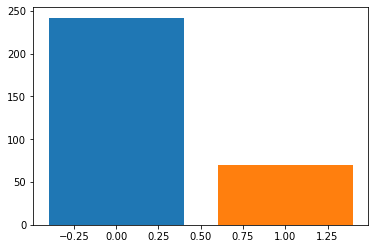

In [140]:
data_temp = [par, nopar]
for row, d in zip(range(2), data_temp):
    plt.bar(row, d)

In [139]:
df_ = data.loc[data['participant'] == 1]
df_ = df_.loc[df_['electrodes'] == 1]

nopar = df_['parei'].value_counts()[0]
par = df_['parei'].value_counts()[1]

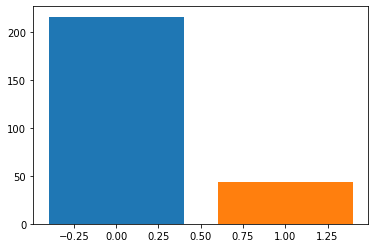

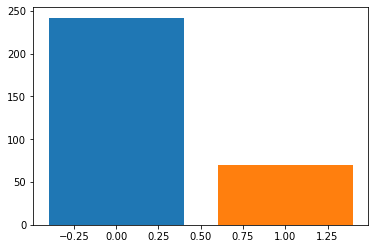

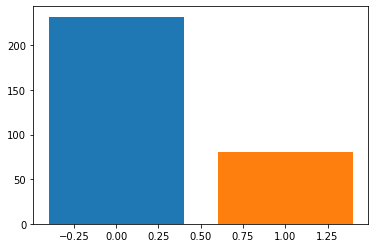

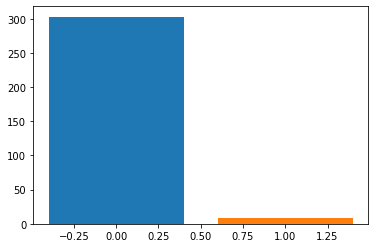

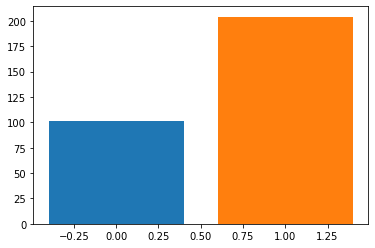

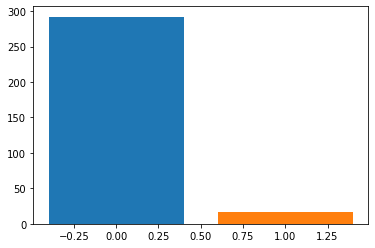

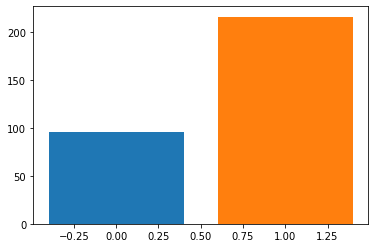

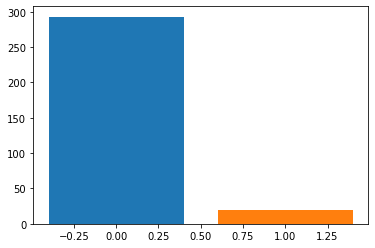

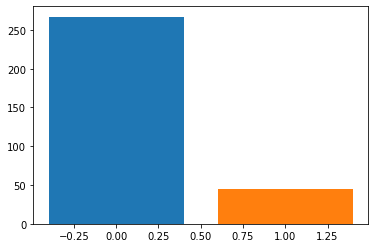

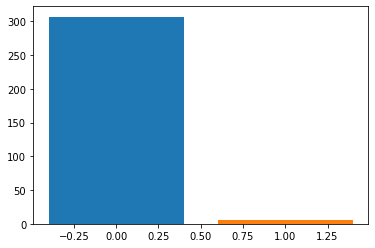

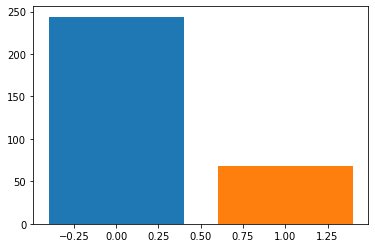

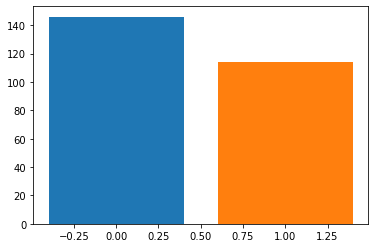

<Figure size 432x288 with 0 Axes>

In [144]:
participants = list(data['participant'].unique())
for p in participants:
    df_ = data.loc[data['participant'] == p]
    df_ = df_.loc[df_['electrodes'] == 1]
    nopar = df_['parei'].value_counts()[0]
    par = df_['parei'].value_counts()[1]
    data_temp = [par, nopar]
    for row, d in zip(range(2), data_temp):
        plt.bar(row, d)
    plt.show()
    plt.clf()


In [110]:
import pandas as pd
import seaborn as sbn
import numpy as np
import sys
sys.path.insert(0, 'C:/Users/Antoine/github/MEG_pareidolia/python_scripts/Functions')
import MEG_pareidolia_utils
from MEG_pareidolia_utils import merge_multi_GLM, get_pareidolia_bids
from ML_functions import *
from PARAMS import FOLDERPATH
import sklearn
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

################################CLASSIFICATORS#########################################################
from sklearn.utils import resample

##DIMENSIONALITY REDUCTION TO PREDICT QUESTIONNAIRE GROUPS

rng_seed = 1
kernel = 1.0 * RBF(1.0)

data = pd.read_csv('../Merged_dataframes/df_ALL_metadata_MEG_sub00to11_epo_long_ALL.csv')
list_participants = [1, 2, 4, 6, 10, 11]
df_p = []
for p in list_participants:
    df_p.append(data.loc[data['participant'] == p])
    
df_new = pd.concat(df_p)
TO_PREDICT = 'parei'
min_obs = 40
#n_seeds = 50
#savename='epo_RT_before_test'
variables = ['delta', 'alpha', 'theta', 'low_beta', 'high_beta', 'gamma1', 'gamma2']
variables = ['tenney', 'harmsim', 'cons']
n_permutations = 100

participants = list(data['participant'].unique())
#df_ = data.loc[data['participant'] == 6]

df_ml = df_new.loc[df_new['electrodes'] == 100]

dfs = []
for v in variables:
    dfs.append(df_ml[[v]])
dfs.append(df_ml[[TO_PREDICT, 'participant']])
df_final = pd.concat(dfs, axis=1)

X2 = df_ml.drop(TO_PREDICT, axis=1).values
y2 = df_ml[TO_PREDICT].values

#X=X.values
#y=y.values
n_samples, n_features = X2.shape
#n_neighbors = 15
n_components = 2

R_frame = df_ml.copy()


#Balance classes
'''parei = R_frame.loc[R_frame[TO_PREDICT] == 1]
NOparei = R_frame.loc[R_frame[TO_PREDICT] == 0]


parei = resample(parei,
             replace=True,
             n_samples=len(NOparei),
             random_state=42)'''
#print(participant, 'N observations : ', len(parei))

#R_frame = pd.concat([parei, NOparei])
##Keep only specific FDs
#R_frame = R_frame[(R_frame.loc[:, 'FD'] == 1.3) | (R_frame.loc[:, 'FD'] > 1.6)]
#R_frame = R_frame[R_frame['FD'] > 1.5]
R_frame.index = pd.RangeIndex(len(R_frame.index))

#Keep relevant variables
#R_frame = R_frame.loc[:, [c1, c2, TO_PREDICT, 'participant']]

groups = R_frame.loc[:, 'participant'].values

#R_frame = R_frame.drop('participant', axis=1)
# Création du dataset
X = R_frame[variables].values
object= StandardScaler()
X = object.fit_transform(X) 
## Encodage des espèces en valeurs numériques pour la coloration
le = LabelEncoder()
le.fit(R_frame.parei.unique())
y = le.transform(R_frame.parei)
R_frame = [X,y]


##Calculate the mean Accuracy scores on 9 classifiers for a definite set of Random Seeds

Acc_scores = []
Score_multiclass = []
clfs = [
                KNeighborsClassifier(n_neighbors=3, weights='uniform', leaf_size=30),
                LogisticRegression(random_state=rng_seed,max_iter=1000,penalty='l2',C=0.01,solver='liblinear'),
                SVC(kernel='rbf', C=1,gamma=.2,max_iter=1000),
                DecisionTreeClassifier(max_depth=30, random_state=rng_seed),
                RandomForestClassifier(max_depth=None, n_estimators=15, max_features=2, random_state=rng_seed),
                AdaBoostClassifier(n_estimators=15, learning_rate=0.5,random_state=rng_seed),
                MLPClassifier(hidden_layer_sizes=(5,), activation='relu', alpha=0.01, max_iter=10000, random_state=rng_seed)]
                #GaussianProcessClassifier(kernel=kernel),
                #GradientBoostingClassifier(n_estimators=15, learning_rate=0.5, subsample=1, max_depth=2, random_state=rng_seed),
            #]
            # Liste des noms associés
clf_names = [
    'k-NN','Régression Logistique',
    'SVM',
    'Arbre de décision','Forêt aléatoire','AdaBoost',
    'Perceptron']#,'Processus Gaussien','Gradient Boosting'   ]
df = pd.DataFrame()
list_df = []
for cnt, clf in enumerate(clfs):

    score, permutation_scores, pvalue = sklearn.model_selection.permutation_test_score(clf, X, y,
                                                                                       groups=groups, n_permutations=n_permutations,
                                                                                       cv=5)
    df['score'] = [score]
    df['pval'] = pvalue
    df['classifier'] = clf_names[cnt]
    list_df.append(df)
    
    print('SCORE : ', score, '/nCLASSIFIER', clf_names[cnt], 'Pval', pvalue)




SCORE :  0.4969590429660746 /nCLASSIFIER k-NN Pval 0.9603960396039604
SCORE :  0.5852183309742326 /nCLASSIFIER Régression Logistique Pval 0.4752475247524752


C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\Antoine\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

SCORE :  0.5846658447863873 /nCLASSIFIER SVM Pval 0.44554455445544555
SCORE :  0.5063528301599622 /nCLASSIFIER Arbre de décision Pval 0.6831683168316832
SCORE :  0.5019329406571998 /nCLASSIFIER Forêt aléatoire Pval 0.9207920792079208
SCORE :  0.5752887995981919 /nCLASSIFIER AdaBoost Pval 0.900990099009901
SCORE :  0.5775017883506081 /nCLASSIFIER Perceptron Pval 0.9900990099009901


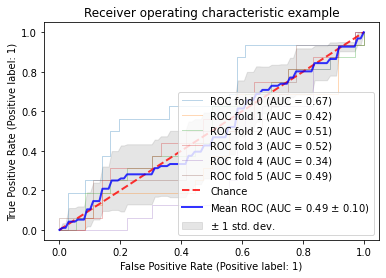

In [9]:
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
random_state = np.random.RandomState(0)

import pandas as pd
import seaborn as sbn
import numpy as np
import sys
sys.path.insert(0, 'C:/Users/Antoine/github/MEG_pareidolia/python_scripts/Functions')
import MEG_pareidolia_utils
from MEG_pareidolia_utils import merge_multi_GLM, get_pareidolia_bids
from ML_functions import *
from PARAMS import FOLDERPATH
import sklearn
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

################################CLASSIFICATORS#########################################################
from sklearn.utils import resample

##DIMENSIONALITY REDUCTION TO PREDICT QUESTIONNAIRE GROUPS

rng_seed = 1
kernel = 1.0 * RBF(1.0)

data = pd.read_csv('../Merged_dataframes/df_ALL_metadata_MEG_sub00to11_epo_long_ALL.csv')
list_participants = [1, 2, 4, 6, 10, 11]
df_p = []
for p in list_participants:
    df_p.append(data.loc[data['participant'] == p])
    
df_new = pd.concat(df_p)
TO_PREDICT = 'parei'
min_obs = 40
#n_seeds = 50
#savename='epo_RT_before_test'
variables = ['delta', 'alpha', 'theta', 'low_beta', 'high_beta', 'gamma1', 'gamma2']
#variables = ['tenney', 'harmsim', 'cons']
n_permutations = 100

participants = list(data['participant'].unique())
df_new = data.loc[data['participant'] == 6]

df_ml = df_new.loc[df_new['electrodes'] == 70]

dfs = []
for v in variables:
    dfs.append(df_ml[[v]])
dfs.append(df_ml[[TO_PREDICT, 'participant']])
df_final = pd.concat(dfs, axis=1)

X2 = df_ml.drop(TO_PREDICT, axis=1).values
y2 = df_ml[TO_PREDICT].values

#X=X.values
#y=y.values
n_samples, n_features = X2.shape
#n_neighbors = 15
n_components = 2

R_frame = df_ml.copy()


#Balance classes
'''parei = R_frame.loc[R_frame[TO_PREDICT] == 1]
NOparei = R_frame.loc[R_frame[TO_PREDICT] == 0]


parei = resample(parei,
             replace=True,
             n_samples=len(NOparei),
             random_state=42)'''
#print(participant, 'N observations : ', len(parei))

#R_frame = pd.concat([parei, NOparei])
##Keep only specific FDs
#R_frame = R_frame[(R_frame.loc[:, 'FD'] == 1.3) | (R_frame.loc[:, 'FD'] > 1.6)]
#R_frame = R_frame[R_frame['FD'] > 1.5]
R_frame.index = pd.RangeIndex(len(R_frame.index))

#Keep relevant variables
#R_frame = R_frame.loc[:, [c1, c2, TO_PREDICT, 'participant']]

groups = R_frame.loc[:, 'participant'].values

#R_frame = R_frame.drop('participant', axis=1)
# Création du dataset
X = R_frame[variables].values
object= StandardScaler()
X = object.fit_transform(X) 
## Encodage des espèces en valeurs numériques pour la coloration
le = LabelEncoder()
le.fit(R_frame.parei.unique())
y = le.transform(R_frame.parei)
R_frame = [X,y]


# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = svm.SVC(kernel="linear", probability=True, random_state=random_state)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X[test],
        y[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()

In [18]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

n_classes = 2
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(
    svm.SVC(kernel="linear", probability=True, random_state=random_state)
)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:], y_score[:])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

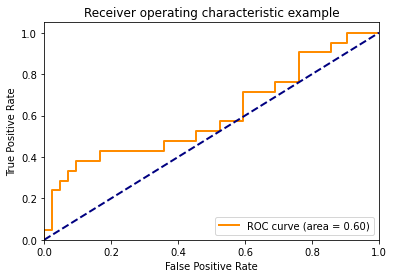

In [23]:
plt.figure()
lw = 2
plt.plot(
    fpr[1],
    tpr[1],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[0],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf1 = LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto").fit(X, y)
clf1.score(X, y)

0.6891025641025641

In [29]:
X[:, 0:2].shape

(312, 2)

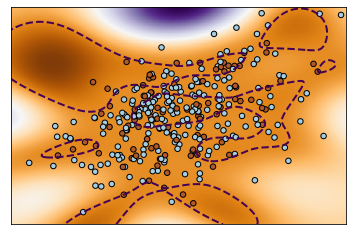

In [31]:
#NON-LINEAR SVM

xx, yy = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-3, 3, 500))

clf = svm.NuSVC(gamma="auto")
clf.fit(X[:, 0:2], y)

# plot the decision function for each datapoint on the grid
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    aspect="auto",
    origin="lower",
    cmap=plt.cm.PuOr_r,
)
contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2, linestyles="dashed")
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired, edgecolors="k")
plt.xticks(())
plt.yticks(())
plt.axis([-3, 3, -3, 3])
plt.show()

In [ ]:
k_range = list(range(1,50))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))
    
plt.plot(k_range, scores)
plt.xlabel('Valeur de k')
plt.ylabel('Exactitude')
plt.title('Exactitude pour différentes valeurs de k dans les k-NN')
plt.show()

In [35]:
value_to_plot

,score,pvalue,classifier,electrodes,participant
0,0.492857,0.495050,k-NN,0,1
1,0.600000,0.059406,Régression Logistique,0,1
2,0.535714,0.198020,SVM,0,1
3,0.600000,0.049505,Arbre de décision,0,1
4,0.585714,0.108911,Forêt aléatoire,0,1
...,...,...,...,...,...
1885,0.635714,0.029703,SVM,269,1
1886,0.500000,0.465347,Arbre de décision,269,1
1887,0.514286,0.475248,Forêt aléatoire,269,1
1888,0.500000,0.504950,AdaBoost,269,1


In [53]:
datapath = '../OUTPUTS/ML_accuracy_scores/'
filename = 'classifiers_epo_RT_before_allSpectral_allSpectral_100.csv'
data = pd.read_csv(datapath+filename)
value_to_plot_ = data.loc[data['participant'] == 1]
value_to_plot = list(value_to_plot_.loc[value_to_plot_['classifier'] == 'k-NN']['score'])
value_to_plot

[0.4928571428571429,
 0.4714285714285714,
 0.4928571428571428,
 0.5428571428571428,
 0.5,
 0.5214285714285716,
 0.6,
 0.5428571428571428,
 0.5499999999999999,
 0.6214285714285714,
 0.5357142857142857,
 0.4714285714285714,
 0.4928571428571428,
 0.5214285714285714,
 0.4999999999999999,
 0.5142857142857143,
 0.5642857142857143,
 0.5785714285714285,
 0.5285714285714286,
 0.5428571428571428,
 0.4928571428571428,
 0.5642857142857143,
 0.4785714285714285,
 0.5857142857142857,
 0.5857142857142857,
 0.5357142857142857,
 0.4571428571428572,
 0.557142857142857,
 0.5,
 0.5285714285714285,
 0.4857142857142857,
 0.4928571428571429,
 0.4857142857142858,
 0.5357142857142857,
 0.4857142857142858,
 0.4928571428571429,
 0.4785714285714285,
 0.5571428571428572,
 0.4857142857142858,
 0.4785714285714285,
 0.5428571428571428,
 0.4214285714285714,
 0.4928571428571428,
 0.4428571428571429,
 0.4857142857142857,
 0.5142857142857142,
 0.5071428571428571,
 0.4928571428571429,
 0.4714285714285714,
 0.46428571428571

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix


name = [0, 1]

def plot_confusion_matrix(clf,classes,                       
                          title,i,n,X_train,y_train,
                          cmap=plt.cm.Blues):
    """
    Cette fonction calcule et affiche la matrice de confusion pour un classificateur donné.
    clf : classificateur
    classes : les classes à déterminer dans le dataset
    title : 
    """
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    print(y_pred.shape)
    # Calcul de la matrice de confusion
    cnf_matrix = confusion_matrix(y_test, y_pred)
    print(cnf_matrix)
    np.set_printoptions(precision=2)

    cnf_matrix  = cnf_matrix .astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

    ax = plt.subplot(n/3,3,i)
    test = ax.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    cbar = plt.colorbar(test)

    tick_marks = np.arange(len(classes))
    #print(tick_marks)
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    thresh = cnf_matrix.max() / 2.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black",size=12)

    ax.set_ylabel('Vrai label')
    ax.set_xlabel('label Prédit')

# Affichage des matrices de confusion pour nos neuf classificateurs 
f = plt.figure(figsize= (15,15))

# Pour chacun des Classificateurs
for cnt, clf in enumerate(clfs):
    plot_confusion_matrix(OneVsRestClassifier(clf), name, clf_names[cnt],cnt+1,len(clfs),X_train,y_train, cmap=plt.cm.Purples)

plt.tight_layout()
plt.show()